<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/EURUSD/EURUSD_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "EURUSD=X"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2009-01-01  1.3980  1.4054  1.3955  1.3999     1.3999       0
2009-01-02  1.4003  1.4023  1.3843  1.3923     1.3923       0
2009-01-05  1.3958  1.3958  1.3556  1.3646     1.3646       0
2009-01-06  1.3632  1.3632  1.3318  1.3510     1.3510       0
2009-01-07  1.3499  1.3742  1.3437  1.3611     1.3611       0
...            ...     ...     ...     ...        ...     ...
2018-12-26  1.1413  1.1419  1.1376  1.1416     1.1416       0
2018-12-27  1.1364  1.1434  1.1359  1.1361     1.1361       0
2018-12-28  1.1431  1.1473  1.1431  1.1431     1.1431       0
2018-12-31  1.1439  1.1466  1.1422  1.1440     1.1440       0
2019-01-01  1.1494  1.1550  1.1465  1.1493     1.1493       0

[2605 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2605.000000  2605.000000  2605.000000  2605.000000  2605.000000  2605.0
mean      1.258565     1.263361     1.253492     1.258516     1.258516     0.0
std       0.118513     0.118918     0.118288     0.118428     0.118428     0.0
min       1.039400     1.042000     0.760600     1.039000     1.039000     0.0
25%       1.139700     1.143500     1.135900     1.139500     1.139500     0.0
50%       1.280900     1.287000     1.274700     1.281200     1.281200     0.0
75%       1.354800     1.359600     1.350000     1.354700     1.354700     0.0
max       1.512600     1.514500     1.504100     1.512800     1.512800     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  1.2806  1.2942  1.2736  1.2899     1.2899   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  1.265327  1.251267  1.247688  1.277964  1.273301  1.280127     1.27155     1.27055  1.252621  1.267512  1.284169  1.265785  1.272942  1.267512  1.280767  1.270181                1.291139                 1.267512                1.243886                1.302952                 1.267512                1.232073                1.314765                 1.267512                1.220260                1.326578                 1.267512                1.208447  1.273301  1.281785  1.268963                1.296927                 1.273301                1.249675                1.308740                 1.273301                1.237862                1.320553                 1.273301                1.226048                1.332366                 1.273301                1.214235   
2009-03-13  1.2900  1.2954  1.2871  1.2930     1.2930   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  1.279164  1.258241  1.249548  1.284710  1.277678  1.282820     1.27385     1.27115  1.255947  1.272487  1.291379  1.270775  1.278606  1.272487  1.291450  1.270284                1.298594                 1.272487                1.246381                1.311648                 1.272487                1.233327                1.324701                 1.272487                1.220274                1.337755                 1.272487                1.207220  1.277678  1.290492  1.269386                1.303785                 1.277678                1.251571                1.316839                 1.277678                1.238518                1.329892                 1.277678                1.225464                1.342946                 1.277678                1.212411   
2009-03-16  1.2886  1.

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000    2555.000000   2555.000000     2555.000000     2555.000000       2555.000000  2555.000000  2555.000000  2555.000000  2555.000000   2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000  2555.000000             2555.000000              2555.000000             2555.000000             2555.000000              2555.000000             2555.000000             2555.000000              2555.000000             2555.000000             2555.000000              2555.000000             2555.000000  2555.000000  2555.000000  2555.000000             2555.000000              2555.000000             2555.000000             2555.000000              2555.000000             2555.000000             2555.000000   
mean      1.257738     1.262444     1.252787     1.257722     1.257722    15.765949     2.000783   185.797652      30.467319      0.033268        0.966732        0.010959          0.989041     6.611350     2.535812    26.990215     2.000783      1.998826    26.990215     1.257927     1.258339    -0.033930     1.257720     1.257895     1.258224     1.257894     1.257138     1.256004     1.257893     1.257726     1.257894     1.257837     1.257893     1.257745     1.258251                1.272786                 1.257893                1.242999                1.280233                 1.257893                1.235552                1.287680                 1.257893                1.228106                1.295127                 1.257893                1.220659     1.257895     1.257758     1.258195                1.272788                 1.257895                1.243001                1.280235                 1.257895                1.235554                1.287682   
std       0.119397     0.119783     0.119233     0.119342     0.119342     8.804321     1.415320   104.383262       0.781546      0.179371        0.179371        0.104130          0.104130     3.413495     1.107650    14.927084     1.415320      1.414351    14.927084     0.119297     0.118481     1.261276     0.119463     0.118822     0.119106     0.118781     0.119157     0.121340     0.118967     0.119409     0.119031     0.119039     0.118967     0.119271     0.118274                0.120986                 0.118967                0.117464                0.122182                 0.118967                0.116912                0.123497                 0.118967                0.116497                0.124928                 0.118967                0.116220     0.118822     0.119215     0.118377                0.120835                 0.118822                0.117325                0.122028                 0.118822                0.116778                0.123341   
min       1.039400     1.042000     0.760600     1.039000     1.039000     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.509721  0.533757  0.689980  0.529548   0.529548   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.483748  0.448959  0.921018  0.508821  0.497783  0.516616    0.495675    0.503100  0.652634  0.486917  0.523864  0.484068  0.497327  0.486917  0.513593  0.493410                0.512923                 0.486917                0.462161                0.519130                 0.486917                0.458304                0.525021                 0.486917                0.461862                0.526243                 0.486917                0.465209  0.497783  0.516292  0.490569                0.528930                 0.497783                0.476602                0.534943                 0.497783                0.474082                0.540366                 0.497783                0.477144                0.543486                 0.497783   
2009-03-13  0.529586  0.536296  0.708137  0.536091   0.536091   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.513957  0.464683  0.921639  0.523254  0.507335  0.522661    0.500649    0.504406  0.657046  0.497709  0.539195  0.494884  0.509588  0.497709  0.536461  0.493641                0.528625                 0.497709                0.467544                0.536967                 0.497709                0.460962                0.544884                 0.497709                0.461889                0.547852                 0.497709                0.462762  0.507335  0.534997  0.491509                0.543625                 0.507335                0.480690                0.551850                 0.507335                0.475467                0.559366                 0.507335                0.475949                0.564396                 0.507335   
2009-03-16  0.526627  0.560212  0.708272  0.545800   0.545800   16          0         75

137788

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbilisltr
  JVM stdout: /tmp/tmpbilisltr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpbilisltr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 6 days
H2O cluster name:           H2O_from_python_unknownUser_cysjjj
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_114901_mod...  0.790139  0.549312              0.296432  0.434297  0.188614
1  DeepLearning_grid_1_AutoML_20190725_114901_mod...  0.783113  0.589668              0.300709  0.451201  0.203582
2  DeepLearning_grid_1_AutoML_20190725_114901_mod...  0.779264  0.563559              0.292400  0.438406  0.192200
3  DeepLearning_grid_1_AutoML_20190725_114901_mod...  0.771322  0.592504              0.315860  0.452702  0.204939
4  DeepLearning_grid_1_AutoML_20190725_114901_mod...  0.770345  0.602026              0.311095  0.457382  0.209199
5  DeepLearning_grid_1_AutoML_20190725_114901_mod...  0.766923  0.582809              0.306329  0.449052  0.201647
6  DeepLearning_grid_1_AutoML_20190725_114901_mod...  0.766618  0.597277              0.338221  0.454420  0.206498
7  DeepLearning_grid_1_AutoML_20190725_114901_mod...  0.737353  0.744776              0.386608  0.492587  0.242642
8  DeepLearning_grid_1_AutoML_20190725_114901_mod...  0.716887  2.092388              0.405303  0.601843  0.362215
9              DeepLearning_1_AutoML_20190725_114901  0.696481  0.841288              0.384653  0.556475  0.309664

variable  relative_importance  scaled_importance  percentage
0           CDLGRAVESTONEDOJI             1.000000           1.000000    0.007676
1            CDLDRAGONFLYDOJI             0.844208           0.844208    0.006480
2                   CDLTAKURI             0.815974           0.815974    0.006263
3                STOCHF_fastk             0.557366           0.557366    0.004278
4           CDLINVERTEDHAMMER             0.523187           0.523187    0.004016
...                       ...                  ...                ...         ...
1018  BBANDS_middleband_8_0_4             0.092617           0.092617    0.000711
1019                  MA_12_0             0.091726           0.091726    0.000704
1020         CDLCOUNTERATTACK             0.085962           0.085962    0.000660
1021      CDLXSIDEGAP3METHODS             0.081301           0.081301    0.000624
1022               CDL3INSIDE             0.077533           0.077533    0.000595

[1023 rows x 4 columns]

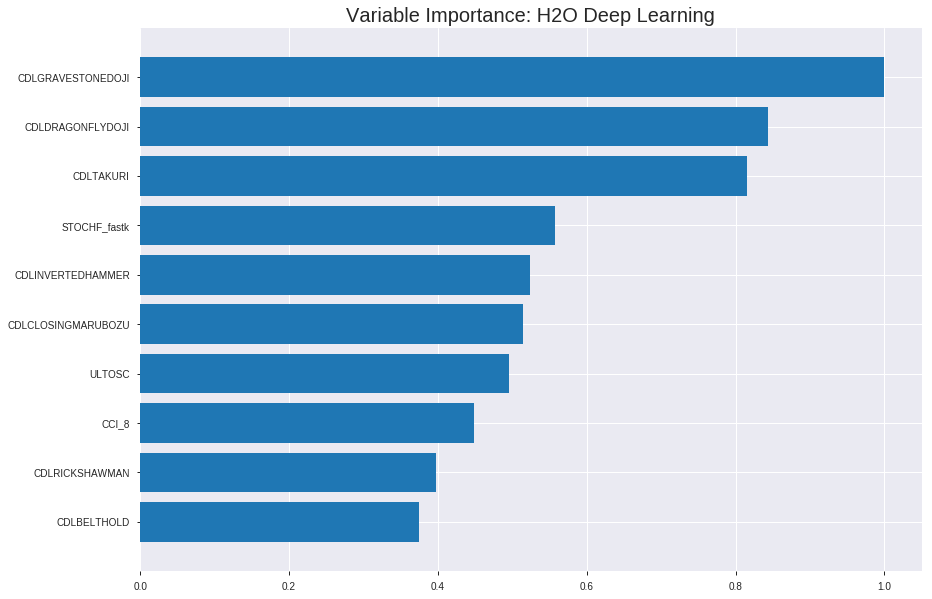

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_114901_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1746794817490004
RMSE: 0.417946745111145
LogLoss: 0.5257750632173912
Mean Per-Class Error: 0.2636171679197995
AUC: 0.8230908521303258
pr_auc: 0.8203325989048033
Gini: 0.6461817042606517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4468057864659805: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      441  434   0.496    (434.0/875.0)
1      76   836   0.0833   (76.0/912.0)
Total  517  1270  0.2854   (510.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446806     0.766269  245
max f2                       0.279856     0.870414  306
max f0point5                 0.521896     0.752564  185
max accuracy                 0.509458     0.73587   195
max precision                0.998415     1         0
max recall                   6.4974e-06   1         399
max specificity              0.998415     1         0
max absolute_mcc             0.509458     0.473038  195
max min_per_class_accuracy   0.505534     0.729143  199
max mean_per_class_accuracy  0.509458     0.736383  195

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 51.20 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.994401           1.95943    1.95943            1                0.996724  1                           0.996724            0.0197368       0.0197368                  95.943    95.943
    2        0.0201455                   0.989994           1.85057    1.905              0.944444         0.992426  0.972222                    0.994575            0.0186404       0.0383772                  85.0573   90.5001
    3        0.0302182                   0.983913           1.74172    1.85057            0.888889         0.987403  0.944444                    0.992184            0.0175439       0.0559211                  74.1715   85.0573
    4        0.040291                    0.979201           1.74172    1.82336            0.888889         0.981573  0.930556                    0.989532            0.0175439       0.0734649                  74.1715   82.3358
    5        0.0503637                   0.975027           1.85057    1.8288             0.944444         0.977046  0.933333                    0.987035            0.0186404       0.0921053                  85.0573   82.8801
    6        0.100168                    0.922536           1.82733    1.82807            0.932584         0.95021   0.932961                    0.968725            0.0910088       0.183114                   82.7333   82.8071
    7        0.149972                    0.831021           1.82733    1.82783            0.932584         0.875201  0.932836                    0.937667            0.0910088       0.274123                   82.7333   82.7826
    8        0.200336                    0.722115           1.61109    1.77334            0.822222         0.781727  0.905028                    0.898464            0.0811404       0.355263                   61.1087   77.3339
    9        0.299944                    0.5633             1.365      1.63773            0.696629         0.628054  0.835821                    0.808664            0.135965        0.491228                   36.4996   63.7732
    10       0.400112                    0.525515           1.29169    1.5511             0.659218         0.539235  0.791608                    0.741212            0.129386        0.620614                   29.1691   55.1101
    11       0.50028                     0.505797           1.07276    1.45533            0.547486         0.514979  0.742729                    0.695915            0.107456        0.72807                    7.27605   45.5326
    12       0.599888                    0.484201           0.935683   1.36904            0.477528         0.496283  0.698694                    0.662767            0.0932018       0.821272                   -6.43172  36.9042
    13       0.700056                    0.450412           0.831937   1.29219            0.424581         0.469295  0.659472                    0.635084            0.0833333       0.904605                   -16.8063  29.219
    14       0.799664                    0.346555           0.627458   1.20939            0.320225         0.409574  0.617215                    0.606994            0.0625          0.967105                   -37.2542  20.9389
    15       0.899832                    0.11107            0.240824   1.10157            0.122905         0.214256  0.562189                    0.563275            0.0241228       0.991228                   -75.9176  10.157
    16       1                           6.4974e-06         0.0875723  1                  0.0446927        0.050981  0.510353                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18623564013329538
RMSE: 0.4315502753252457
LogLoss: 0.5500523170885216
Mean Per-Class Error: 0.24737237237237242
AUC: 0.8153842618128332
pr_auc: 0.8039300957660654
Gini: 0.6307685236256664
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4743847289299294: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      173  86   0.332    (86.0/259.0)
1      41   211  0.1627   (41.0/252.0)
Total  214  297  0.2485   (127.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474385     0.76867   223
max f2                       0.389276     0.862926  299
max f0point5                 0.505107     0.74537   167
max accuracy                 0.475177     0.751468  221
max precision                0.994284     1         0
max recall                   0.0919008    1         394
max specificity              0.994284     1         0
max absolute_mcc             0.474385     0.512007  223
max min_per_class_accuracy   0.492188     0.725869  193
max mean_per_class_accuracy  0.474385     0.752628  223

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.982059           2.02778   2.02778            1                0.986607  1                           0.986607            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.975851           2.02778   2.02778            1                0.979848  1                           0.983535            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.968039           2.02778   2.02778            1                0.972947  1                           0.980226            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.944881           1.62222   1.93122            0.8              0.954773  0.952381                    0.974166            0.015873        0.0793651                  62.2222   93.1217
    5        0.0508806                   0.930636           2.02778   1.94979            1                0.940952  0.961538                    0.967779            0.0198413       0.0992063                  102.778   94.9786
    6        0.101761                    0.873682           1.7938    1.87179            0.884615         0.900003  0.923077                    0.933891            0.0912698       0.190476                   79.3803   87.1795
    7        0.150685                    0.749322           1.78444   1.84343            0.88             0.833498  0.909091                    0.901296            0.0873016       0.277778                   78.4444   84.3434
    8        0.201566                    0.633763           1.55983   1.77184            0.769231         0.698493  0.873786                    0.850103            0.0793651       0.357143                   55.9829   77.1845
    9        0.30137                     0.528458           1.39161   1.64592            0.686275         0.563335  0.811688                    0.755134            0.138889        0.496032                   39.1612   64.5924
    10       0.401174                    0.505635           1.35185   1.57276            0.666667         0.515149  0.77561                     0.695431            0.134921        0.630952                   35.1852   57.2764
    11       0.500978                    0.490842           0.954248  1.44954            0.470588         0.498085  0.714844                    0.656116            0.0952381       0.72619                    -4.57516  44.9544
    12       0.600783                    0.467626           1.19281   1.40689            0.588235         0.480283  0.693811                    0.626906            0.119048        0.845238                   19.281    40.6895
    13       0.700587                    0.433676           0.556645  1.28577            0.27451          0.453876  0.634078                    0.602256            0.0555556       0.900794                   -44.3355  28.577
    14       0.800391                    0.375484           0.636166  1.20477            0.313725         0.40905   0.594132                    0.578164            0.0634921       0.964286                   -36.3834  20.4768
    15       0.900196                    0.200717           0.198802  1.09324            0.0980392        0.297504  0.53913                     0.547048            0.0198413       0.984127                   -80.1198  9.32367
    16       1                           0.0403267          0.159041  1                  0.0784314        0.135447  0.493151                    0.505968          


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 12:17:57  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 12:17:59  9 min 43.065 sec   223 obs/sec       0.220481  1             394        0.697853         3.15649             -0.948828      0.549831        0.552637           1.30629          0.487969                         0.711552           3.94134               -1.0256          0.539399          0.55874              2.02778            0.489237
    2019-07-25 12:18:28  10 min 11.968 sec  328 obs/sec       5.10297   22            9119       0.500972         0.694985            -0.00432278    0.615015        0.635378           1.95943          0.439284                         0.499655           0.692444              0.001193         0.600156          0.598834             2.02778            0.493151
    2019-07-25 12:18:58  10 min 41.571 sec  360 obs/sec       10.9899   47            19639      0.472484         0.634616            0.106654       0.722348        0.716066           1.85057          0.358702                         0.489583           0.670889              0.0410551        0.721625          0.700901             2.02778            0.344423
    2019-07-25 12:19:27  11 min 10.995 sec  377 obs/sec       17.0867   73            30534      0.456994         0.60534             0.164269       0.781738        0.785594           1.85057          0.313374                         0.482368           0.656409              0.0691091        0.784864          0.778764             2.02778            0.287671
    2019-07-25 12:19:56  11 min 39.935 sec  386 obs/sec       23.1852   99            41432      0.443245         0.575141            0.213799       0.781195        0.78958            1.85057          0.349189                         0.486246           0.664518              0.0540831        0.767267          0.766829             2.02778            0.320939
    2019-07-25 12:20:25  12 min  8.682 sec  394 obs/sec       29.3386   125           52428      0.44974          0.590784            0.190588       0.772812        0.784379           1.95943          0.31953                          0.463795           0.62094               0.139415         0.801725          0.791306             2.02778            0.273973
    2019-07-25 12:20:54  12 min 37.703 sec  400 obs/sec       35.6654   152           63734      0.430693         0.552641            0.257697       0.811934        0.813203           1.85057          0.303302                         0.462481           0.615329              0.144283         0.797044          0.789045             2.02778            0.272016
    2019-07-25 12:21:23  13 min  6.953 sec  405 obs/sec       42.0666   179           75173      0.422036         0.53381             0.287238       0.810255        0.809876           1.95943          0.285954                         0.455209           0.600621              0.170985         0.806069          0.793567             2.02778            0.277886
    2019-07-

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLGRAVESTONEDOJI        1.0                    1.0                  0.007675560773324354
CDLDRAGONFLYDOJI         0.8442078828811646     0.8442078828811646   0.006479768910373867
CDLTAKURI                0.8159739375114441     0.8159739375114441   0.006263057546817857
STOCHF_fastk             0.5573661923408508     0.5573661923408508   0.0042780980823085915
CDLINVERTEDHAMMER        0.5231865644454956     0.5231865644454956   0.00401575027118818
---                      ---                    ---                  ---
BBANDS_middleband_8_0_4  0.09261742234230042    0.09261742234230042  0.0007108906538569757
MA_12_0                  0.09172623604536057    0.09172623604536057  0.0007040502992744599
CDLCOUNTERATTACK         0.08596184104681015    0.08596184104681015  0.0006598053351416393
CDLXSIDEGAP3METHODS      0.08130059391260147    0.08130059391260147  0.0006240276494835366
CDL3INSIDE               0.07753274589776993    0.07753274589776993  0.0005951073030610476


See the whole table with table.as_data_frame()


('accuracy', 0.71875)

('F1', 0.7701863354037267)

('auc', 0.7901392961876833)

('logloss', 0.5493120848099983)

('mean_per_class_error', 0.28665689149560114)

('rmse', 0.43429725657109064)

('mse', 0.18861410706517573)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


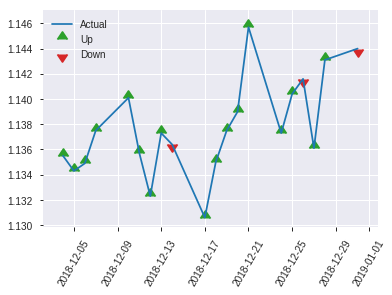


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18861410706517573
RMSE: 0.43429725657109064
LogLoss: 0.5493120848099983
Mean Per-Class Error: 0.28665689149560114
AUC: 0.7901392961876833
pr_auc: 0.7958186120615864
Gini: 0.5802785923753666
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.424858727805527: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   66   0.5323   (66.0/124.0)
1      8    124  0.0606   (8.0/132.0)
Total  66   190  0.2891   (74.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424859     0.770186  189
max f2                       0.381029     0.879567  210
max f0point5                 0.483238     0.717593  128
max accuracy                 0.451359     0.71875   173
max precision                0.99309      1         0
max recall                   0.0790822    1         255
max specificity              0.99309      1         0
max absolute_mcc             0.424859     0.465145  189
max min_per_class_accuracy   0.483238     0.704545  128
max mean_per_class_accuracy  0.451359     0.713343  173

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 50.78 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.989205           1.93939    1.93939            1                0.991267  1                           0.991267            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.983132           1.93939    1.93939            1                0.986889  1                           0.989078            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.968575           1.93939    1.93939            1                0.974969  1                           0.985551            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.956857           1.93939    1.93939            1                0.962591  1                           0.979289            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.952484           1.93939    1.93939            1                0.954478  1                           0.975472            0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.865333           1.93939    1.93939            1                0.907963  1                           0.941718            0.0984848       0.19697                    93.9394   93.9394
    7        0.152344                    0.701675           1.64103    1.83994            0.846154         0.796622  0.948718                    0.893352            0.0833333       0.280303                   64.1026   83.9938
    8        0.203125                    0.594636           1.04429    1.64103            0.538462         0.643105  0.846154                    0.830791            0.0530303       0.333333                   4.4289    64.1026
    9        0.300781                    0.527996           1.08606    1.46084            0.56             0.548999  0.753247                    0.7393              0.106061        0.439394                   8.60606   46.0842
    10       0.402344                    0.507912           1.41725    1.44984            0.730769         0.516597  0.747573                    0.683084            0.143939        0.583333                   41.7249   44.9838
    11       0.5                         0.48381            1.16364    1.39394            0.6              0.496918  0.71875                     0.646723            0.113636        0.69697                    16.3636   39.3939
    12       0.601562                    0.464433           1.04429    1.33491            0.538462         0.473914  0.688312                    0.617547            0.106061        0.80303                    4.4289    33.4908
    13       0.699219                    0.445111           0.930909   1.27848            0.48             0.455438  0.659218                    0.594906            0.0909091       0.893939                   -6.90909  27.8483
    14       0.800781                    0.400398           0.671329   1.20148            0.346154         0.422127  0.619512                    0.572993            0.0681818       0.962121                   -32.8671  20.1478
    15       0.898438                    0.279537           0.310303   1.10461            0.16             0.353292  0.569565                    0.549112            0.030303        0.992424                   -68.9697  10.4611
    16       1                           0.0790822          0.0745921  1                  0.0384615        0.142429  0.515625                   

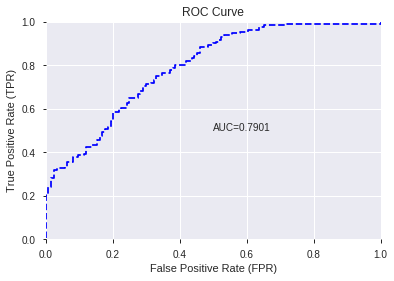

This function is available for GLM models only


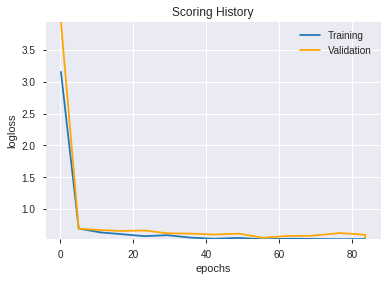

--2019-07-25 12:24:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.19.24
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.19.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  36.9MB/s    in 10s     

2019-07-25 12:24:54 (34.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_114901_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_114901_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_122507_model_9  0.809262  0.506164              0.284580  0.417764  0.174527
1  DeepLearning_grid_1_AutoML_20190725_122507_model_5  0.806818  0.506923              0.305230  0.414102  0.171481
2  DeepLearning_grid_1_AutoML_20190725_122507_model_8  0.806085  0.494613              0.305474  0.411582  0.169400
3  DeepLearning_grid_1_AutoML_20190725_122507_model_7  0.805657  0.567016              0.317815  0.435127  0.189336
4  DeepLearning_grid_1_AutoML_20190725_122507_model_6  0.789528  0.522006              0.313539  0.422199  0.178252
5  DeepLearning_grid_1_AutoML_20190725_122507_model_3  0.786901  0.534178              0.321114  0.429564  0.184525
6               DeepLearning_1_AutoML_20190725_122507  0.774132  0.632705              0.311828  0.466291  0.217428
7  DeepLearning_grid_1_AutoML_20190725_122507_model_4  0.772911  0.625683              0.308773  0.462206  0.213635
8  DeepLearning_grid_1_AutoML_20190725_122507_model_1  0.741813  0.642773              0.369257  0.467146  0.218226
9  DeepLearning_grid_1_AutoML_20190725_122507_model_2  0.717314  0.618492              0.372556  0.466431  0.217558

variable  relative_importance  scaled_importance  percentage
0       CDLRICKSHAWMAN             1.000000           1.000000    0.034082
1                  DIV             0.984975           0.984975    0.033570
2                  SUB             0.974987           0.974987    0.033229
3    CDLGRAVESTONEDOJI             0.881070           0.881070    0.030029
4                CCI_8             0.822125           0.822125    0.028020
5         STOCHF_fastk             0.805074           0.805074    0.027438
6     CDLDRAGONFLYDOJI             0.770066           0.770066    0.026245
7               TRANGE             0.753005           0.753005    0.025664
8    CDLLONGLEGGEDDOJI             0.725035           0.725035    0.024711
9            CDLTAKURI             0.724865           0.724865    0.024705
10             CDLDOJI             0.673225           0.673225    0.022945
11          MINUS_DI_8             0.664684           0.664684    0.022654
12            CORREL_8             0.654609           0.654609    0.022310
13   CDLINVERTEDHAMMER             0.647363           0.647363    0.022063
14       CDLHANGINGMAN             0.623561           0.623561    0.021252
15            WILLR_12             0.614575           0.614575    0.020946
16            WILLR_14             0.611778           0.611778    0.020851
17  CDLCLOSINGMARUBOZU             0.606626           0.606626    0.020675
18             WILLR_8             0.593622           0.593622    0.020232
19      is_month_start             0.585935           0.585935    0.019970
20              ULTOSC             0.565976           0.565976    0.019290
21        is_month_end             0.559206           0.559206    0.019059
22       days_in_month             0.558306           0.558306    0.019028
23         MINUS_DM_12             0.534672           0.534672    0.018223
24              CCI_12             0.517655           0.517655    0.017643
25         MINUS_DI_14             0.516499           0.516499    0.017603
26          CDLHIKKAKE             0.514353           0.514353    0.017530
27     CDLSHOOTINGSTAR             0.511938           0.511938    0.017448
28           PLUS_DI_8             0.511324           0.511324    0.017427
29           CDLHAMMER             0.509738           0.509738    0.017373
30          MINUS_DM_8             0.507584           0.507584    0.017299
31         CDLBELTHOLD             0.500124           0.500124    0.017045
32           PLUS_DM_8             0.495582           0.495582    0.016890
33      STOCHRSI_fastk             0.491796           0.491796    0.016761
34          aroonup_24             0.486069           0.486069    0.016566
35         MINUS_DI_12             0.482609           0.482609    0.016448
36           aroonup_8             0.478449           0.478449    0.016306
37                DX_8             0.473511           0.473511    0.016138
38              CCI_14             0.471798           0.471798    0.016080
39        STOCHF_fastd             0.470853           0.470853    0.016048
40          PLUS_DI_14             0.466058           0.466058    0.015884
41          aroonup_12             0.463414           0.463414    0.015794
42          PLUS_DM_12             0.459877           0.459877    0.015673
43         STOCH_slowk             0.459174           0.459174    0.015650
44          PLUS_DI_12             0.448904           0.448904    0.015299
45              CCI_20             0.444051           0.444051    0.015134
46          PLUS_DM_14             0.438408           0.438408    0.014942
47              CCI_30             0.432594           0.432594    0.014744
48              CCI_24             0.428286           0.428286    0.014597
49         AROONOSC_12             0.425126           0.425126    0.014489

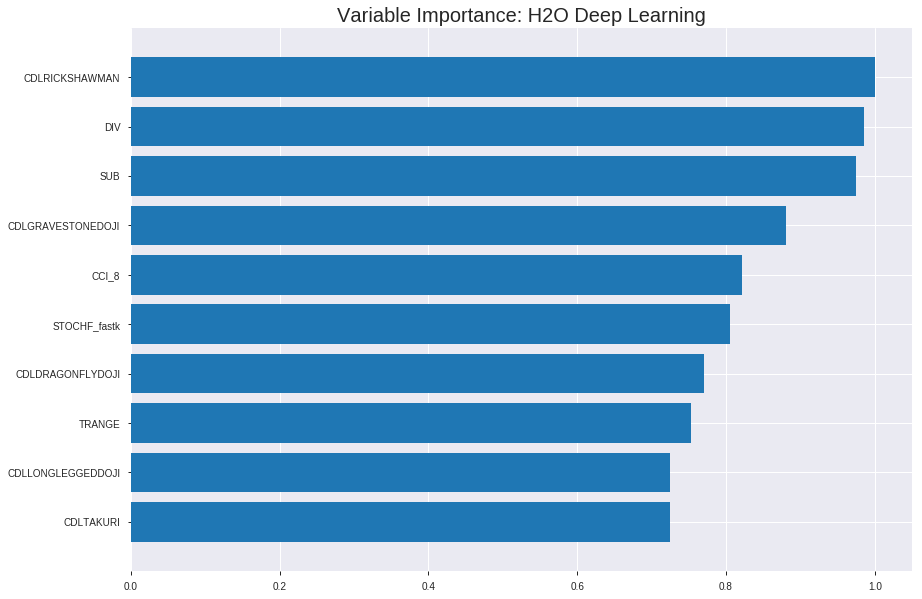

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_122507_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17449995284243547
RMSE: 0.4177319150393413
LogLoss: 0.5175552887775374
Mean Per-Class Error: 0.2828615288220552
AUC: 0.8099179197994988
pr_auc: 0.8110194948354021
Gini: 0.6198358395989976
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43749151766743016: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      395  480   0.5486   (480.0/875.0)
1      44   868   0.0482   (44.0/912.0)
Total  439  1348  0.2932   (524.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437492     0.768142  258
max f2                       0.259473     0.873719  306
max f0point5                 0.542556     0.734568  179
max accuracy                 0.517278     0.718523  212
max precision                0.980859     1         0
max recall                   0.00502672   1         399
max specificity              0.980859     1         0
max absolute_mcc             0.437492     0.468195  258
max min_per_class_accuracy   0.521143     0.710857  206
max mean_per_class_accuracy  0.517278     0.717138  212

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 51.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.973842           1.95943   1.95943            1                0.976517   1                           0.976517            0.0197368       0.0197368                  95.943    95.943
    2        0.0201455                   0.971469           1.85057   1.905              0.944444         0.972386   0.972222                    0.974451            0.0186404       0.0383772                  85.0573   90.5001
    3        0.0302182                   0.969152           1.85057   1.88686            0.944444         0.970473   0.962963                    0.973125            0.0186404       0.0570175                  85.0573   88.6858
    4        0.040291                    0.966565           1.95943   1.905              1                0.967779   0.972222                    0.971789            0.0197368       0.0767544                  95.943    90.5001
    5        0.0503637                   0.963698           1.85057   1.89412            0.944444         0.965163   0.966667                    0.970463            0.0186404       0.0953947                  85.0573   89.4115
    6        0.100168                    0.94558            1.7833    1.83902            0.910112         0.955525   0.938547                    0.963036            0.0888158       0.184211                   78.3301   83.9018
    7        0.149972                    0.893517           1.80532   1.82783            0.921348         0.930019   0.932836                    0.952071            0.0899123       0.274123                   80.5317   82.7826
    8        0.200336                    0.732365           1.58932   1.76787            0.811111         0.816755   0.902235                    0.918053            0.0800439       0.354167                   58.9315   76.7865
    9        0.299944                    0.554814           1.34298   1.62677            0.685393         0.61983    0.830224                    0.819017            0.133772        0.487939                   34.298    62.6765
    10       0.400112                    0.53092            1.11655   1.49903            0.569832         0.539039   0.765035                    0.748924            0.111842        0.599781                   11.6547   49.9032
    11       0.50028                     0.521215           1.06181   1.41149            0.541899         0.526237   0.720358                    0.704337            0.10636         0.70614                    6.18139   41.1491
    12       0.599888                    0.515188           1.03476   1.34894            0.52809          0.51812    0.688433                    0.673417            0.10307         0.809211                   3.47551   34.8936
    13       0.700056                    0.500704           0.941402  1.29062            0.480447         0.509414   0.658673                    0.64995             0.0942982       0.903509                   -5.8598   29.0624
    14       0.799664                    0.244554           0.693506  1.21625            0.353933         0.417467   0.620714                    0.620991            0.0690789       0.972588                   -30.6494  21.6245
    15       0.899832                    0.0513104          0.164198  1.09913            0.0837989        0.117635   0.560945                    0.564959            0.0164474       0.989035                   -83.5802  9.91329
    16       1                           0.00502672         0.109465  1                  0.0558659        0.0385879  0.510353                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17174547164734555
RMSE: 0.41442185228019235
LogLoss: 0.5219233881832598
Mean Per-Class Error: 0.25498712998713
AUC: 0.8240025740025739
pr_auc: 0.8023219267898741
Gini: 0.6480051480051479
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5129419629566149: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      164  95   0.3668   (95.0/259.0)
1      37   215  0.1468   (37.0/252.0)
Total  201  310  0.2583   (132.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.512942     0.765125  232
max f2                       0.238705     0.857143  303
max f0point5                 0.826034     0.765707  94
max accuracy                 0.513253     0.74364   230
max precision                0.976122     1         0
max recall                   0.02979      1         397
max specificity              0.976122     1         0
max absolute_mcc             0.513253     0.499443  230
max min_per_class_accuracy   0.527232     0.737452  198
max mean_per_class_accuracy  0.513253     0.745013  230

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 52.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.974675           2.02778   2.02778            1                0.975339   1                           0.975339            0.0238095       0.0238095                  102.778    102.778
    2        0.0215264                   0.971612           1.62222   1.84343            0.8              0.97252    0.909091                    0.974058            0.015873        0.0396825                  62.2222    84.3434
    3        0.0313112                   0.970505           1.62222   1.77431            0.8              0.971079   0.875                       0.973127            0.015873        0.0555556                  62.2222    77.4306
    4        0.0410959                   0.96947            1.21667   1.64153            0.6              0.969956   0.809524                    0.972372            0.0119048       0.0674603                  21.6667    64.1534
    5        0.0508806                   0.968081           2.02778   1.71581            1                0.968738   0.846154                    0.971673            0.0198413       0.0873016                  102.778    71.5812
    6        0.101761                    0.960289           1.7938    1.75481            0.884615         0.964177   0.865385                    0.967925            0.0912698       0.178571                   79.3803    75.4808
    7        0.150685                    0.951024           1.86556   1.79076            0.92             0.957177   0.883117                    0.964435            0.0912698       0.269841                   86.5556    79.0765
    8        0.201566                    0.927345           2.02778   1.85059            1                0.940548   0.912621                    0.958405            0.103175        0.373016                   102.778    85.0593
    9        0.30137                     0.653678           1.43137   1.71176            0.705882         0.806029   0.844156                    0.907943            0.142857        0.515873                   43.1373    71.176
    10       0.401174                    0.538698           1.27233   1.60244            0.627451         0.57696    0.790244                    0.825601            0.126984        0.642857                   27.2331    60.2439
    11       0.500978                    0.526983           0.994009  1.48123            0.490196         0.532306   0.730469                    0.767171            0.0992063       0.742063                   -0.599129  48.1228
    12       0.600783                    0.512974           1.07353   1.4135             0.529412         0.520559   0.697068                    0.726203            0.107143        0.849206                   7.35294    41.35
    13       0.700587                    0.464167           0.675926  1.30843            0.333333         0.49935    0.645251                    0.693886            0.0674603       0.916667                   -32.4074   30.8426
    14       0.800391                    0.166898           0.437364  1.19981            0.215686         0.316482   0.591687                    0.646826            0.0436508       0.960317                   -56.2636   19.981
    15       0.900196                    0.0472722          0.238562  1.09324            0.117647         0.0828397  0.53913                     0.584297            0.0238095       0.984127                   -76.1438   9.32367
    16       1                           0.0236562          0.159041  1                  0.0784314        0.0392487  0.493151      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 12:32:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 12:32:13  2 min 21.834 sec  427 obs/sec       0.482932  1             863        0.560614         1.01216             -0.257692      0.744158        0.724934           1.41514          0.338556                         0.530999           0.896245              -0.128051        0.76798           0.749866             2.02778            0.307241
    2019-07-25 12:32:24  2 min 32.695 sec  741 obs/sec       4.92445   10            8800       0.445214         0.576974            0.206799       0.774879        0.768451           1.63286          0.307219                         0.435545           0.559532              0.24106          0.802269          0.80572              2.02778            0.297456
    2019-07-25 12:32:35  2 min 43.393 sec  897 obs/sec       10.8271   22            19348      0.429381         0.547546            0.262211       0.789466        0.792855           1.95943          0.293229                         0.422054           0.547808              0.287349         0.810198          0.791124             1.68981            0.277886
    2019-07-25 12:32:45  2 min 53.714 sec  1002 obs/sec      17.305    35            30924      0.433715         0.553468            0.247243       0.769872        0.77951            1.95943          0.315613                         0.430163           0.551516              0.259699         0.785584          0.781965             1.68981            0.311155
    2019-07-25 12:32:55  3 min  3.955 sec  1079 obs/sec      24.2087   49            43261      0.425757         0.542905            0.274613       0.792801        0.800184           1.85057          0.302182                         0.416521           0.546353              0.305911         0.808926          0.782238             1.35185            0.287671
    2019-07-25 12:33:06  3 min 14.270 sec  1143 obs/sec      31.5976   64            56465      0.417732         0.517555            0.301701       0.809918        0.811019           1.95943          0.293229                         0.414422           0.521923              0.312889         0.824003          0.802322             2.02778            0.258317
    2019-07-25 12:33:16  3 min 24.381 sec  1191 obs/sec      39.0095   79            69710      0.416237         0.519144            0.30669        0.81388         0.816657           1.95943          0.284275                         0.418971           0.546237              0.297722         0.817966          0.795044             2.02778            0.264188
    2019-07-25 12:33:26  3 min 34.652 sec  1235 obs/sec      46.836    95            83696      0.418476         0.516973            0.29921        0.810036        0.817613           1.95943          0.288752                         0.421561           0.531889              0.289011         0.807088          0.797546             2.02778            0.309198
    2019-07-25 12:33:37

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLRICKSHAWMAN     1.0                    1.0                  0.03408187065859334
DIV                0.9849749803543091     0.9849749803543091   0.03356978988238608
SUB                0.9749870300292969     0.9749870300292969   0.03322938185126456
CDLGRAVESTONEDOJI  0.8810698390007019     0.8810698390007019   0.030028508294009583
CCI_8              0.8221254944801331     0.8221254944801331   0.02801957476800399
---                ---                    ---                  ---
CCI_20             0.44405078887939453    0.44405078887939453  0.015134081552433863
PLUS_DM_14         0.43840837478637695    0.43840837478637695  0.014941777525113414
CCI_30             0.4325941205024719     0.4325941205024719   0.01474361686263319
CCI_24             0.428286075592041      0.428286075592041    0.014596790633204473
AROONOSC_12        0.4251256585121155     0.4251256585121155   0.01448907770705924


See the whole table with table.as_data_frame()


('accuracy', 0.7421875)

('F1', 0.7788161993769471)

('auc', 0.8092619745845552)

('logloss', 0.5061644308136029)

('mean_per_class_error', 0.25806451612903225)

('rmse', 0.417764005080201)

('mse', 0.17452676394065023)

deeplearning prediction progress: |███████████████████████████████████████| 100%


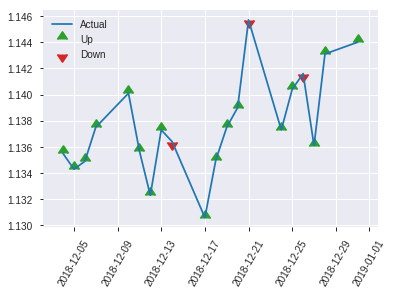


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.17452676394065023
RMSE: 0.417764005080201
LogLoss: 0.5061644308136029
Mean Per-Class Error: 0.25806451612903225
AUC: 0.8092619745845552
pr_auc: 0.8193209665348393
Gini: 0.6185239491691104
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3556609952701877: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   64   0.5161   (64.0/124.0)
1      7    125  0.053    (7.0/132.0)
Total  67   189  0.2773   (71.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355661     0.778816  188
max f2                       0.151183     0.883941  212
max f0point5                 0.519449     0.75      131
max accuracy                 0.519449     0.742188  131
max precision                0.974658     1         0
max recall                   0.052688     1         236
max specificity              0.974658     1         0
max absolute_mcc             0.355661     0.489831  188
max min_per_class_accuracy   0.519604     0.733871  129
max mean_per_class_accuracy  0.519449     0.741935  131

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 51.84 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.973329           1.93939    1.93939            1                0.973845  1                           0.973845            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.971575           1.93939    1.93939            1                0.972435  1                           0.97314             0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.968623           1.93939    1.93939            1                0.971299  1                           0.97268             0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.963458           1.93939    1.93939            1                0.964827  1                           0.970538            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.962291           1.93939    1.93939            1                0.963159  1                           0.969403            0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.94222            1.93939    1.93939            1                0.955652  1                           0.962527            0.0984848       0.19697                    93.9394   93.9394
    7        0.152344                    0.928521           1.79021    1.88967            0.923077         0.936028  0.974359                    0.953694            0.0909091       0.287879                   79.021    88.9666
    8        0.203125                    0.86231            1.64103    1.82751            0.846154         0.907826  0.942308                    0.942227            0.0833333       0.371212                   64.1026   82.7506
    9        0.300781                    0.572457           0.930909   1.5364             0.48             0.692725  0.792208                    0.86122             0.0909091       0.462121                   -6.90909  53.6403
    10       0.402344                    0.530649           1.19347    1.44984            0.615385         0.54405   0.747573                    0.781158            0.121212        0.583333                   19.3473   44.9838
    11       0.5                         0.51972            1.47394    1.45455            0.76             0.523381  0.75                        0.730811            0.143939        0.727273                   47.3939   45.4545
    12       0.601562                    0.512592           0.745921   1.33491            0.384615         0.51598   0.688312                    0.69454             0.0757576       0.80303                    -25.4079  33.4908
    13       0.699219                    0.463698           0.930909   1.27848            0.48             0.500889  0.659218                    0.667494            0.0909091       0.893939                   -6.90909  27.8483
    14       0.800781                    0.229446           0.745921   1.21094            0.384615         0.340494  0.62439                     0.626021            0.0757576       0.969697                   -25.4079  21.0939
    15       0.898438                    0.0588419          0.232727   1.10461            0.12             0.127809  0.569565                    0.571867            0.0227273       0.992424                   -76.7273  10.4611
    16       1                           0.0308223          0.0745921  1                  0.0384615        0.045494  0.515625                   

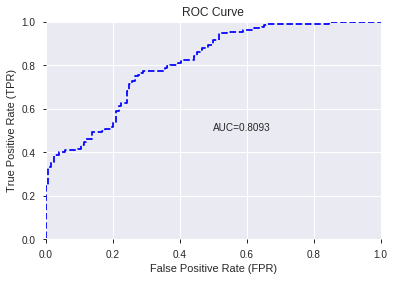

This function is available for GLM models only


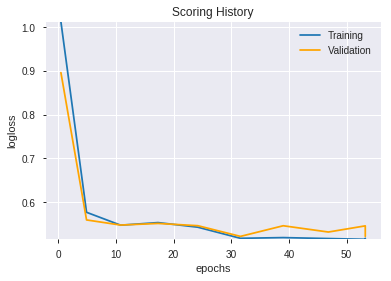

--2019-07-25 12:33:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_122507_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_122507_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLRICKSHAWMAN',
 'DIV',
 'SUB',
 'CDLGRAVESTONEDOJI',
 'CCI_8',
 'STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'TRANGE',
 'CDLLONGLEGGEDDOJI',
 'CDLTAKURI',
 'CDLDOJI',
 'MINUS_DI_8',
 'CORREL_8',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'WILLR_12',
 'WILLR_14',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'is_month_start',
 'ULTOSC',
 'is_month_end',
 'days_in_month',
 'MINUS_DM_12',
 'CCI_12',
 'MINUS_DI_14',
 'CDLHIKKAKE',
 'CDLSHOOTINGSTAR',
 'PLUS_DI_8',
 'CDLHAMMER',
 'MINUS_DM_8',
 'CDLBELTHOLD',
 'PLUS_DM_8',
 'STOCHRSI_fastk',
 'aroonup_24',
 'MINUS_DI_12',
 'aroonup_8',
 'DX_8',
 'CCI_14',
 'STOCHF_fastd',
 'PLUS_DI_14',
 'aroonup_12',
 'PLUS_DM_12',
 'STOCH_slowk',
 'PLUS_DI_12',
 'CCI_20',
 'PLUS_DM_14',
 'CCI_30',
 'CCI_24',
 'AROONOSC_12']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_123355_model_1  0.816777  0.512395              0.283602  0.416802  0.173724

variable  relative_importance  scaled_importance  percentage
0          MINUS_DI_12             2.859960           1.000000    0.111356
1           PLUS_DI_12             2.584125           0.903553    0.100616
2           PLUS_DM_12             1.850738           0.647120    0.072061
3           PLUS_DM_14             1.819879           0.636330    0.070859
4          MINUS_DI_14             1.711853           0.598558    0.066653
5            PLUS_DI_8             1.618568           0.565941    0.063021
6           MINUS_DI_8             1.353562           0.473280    0.052702
7           PLUS_DI_14             1.275880           0.446118    0.049678
8               CCI_14             1.275505           0.445987    0.049663
9                CCI_8             1.088855           0.380724    0.042396
10              CCI_12             1.039739           0.363550    0.040483
11            WILLR_14             0.908213           0.317561    0.035362
12    CDLDRAGONFLYDOJI             0.853472           0.298421    0.033231
13        STOCHF_fastk             0.846031           0.295819    0.032941
14                 DIV             0.622604           0.217697    0.024242
15   CDLGRAVESTONEDOJI             0.551043           0.192675    0.021455
16              CCI_30             0.475668           0.166320    0.018521
17           CDLTAKURI             0.284762           0.099569    0.011088
18         MINUS_DM_12             0.251738           0.088021    0.009802
19             WILLR_8             0.251501           0.087939    0.009792
20                 SUB             0.251441           0.087918    0.009790
21       CDLHANGINGMAN             0.145264           0.050792    0.005656
22          aroonup_12             0.144313           0.050460    0.005619
23      STOCHRSI_fastk             0.119274           0.041705    0.004644
24   CDLINVERTEDHAMMER             0.118053           0.041278    0.004597
25              TRANGE             0.115340           0.040329    0.004491
26            WILLR_12             0.112034           0.039173    0.004362
27     CDLSHOOTINGSTAR             0.103656           0.036244    0.004036
28                DX_8             0.085112           0.029760    0.003314
29              CCI_24             0.084831           0.029662    0.003303
30         AROONOSC_12             0.081335           0.028439    0.003167
31         CDLBELTHOLD             0.077729           0.027178    0.003026
32              CCI_20             0.077285           0.027023    0.003009
33          MINUS_DM_8             0.075291           0.026326    0.002932
34           CDLHAMMER             0.068356           0.023901    0.002662
35              ULTOSC             0.066725           0.023331    0.002598
36            CORREL_8             0.060221           0.021057    0.002345
37      is_month_start             0.049616           0.017349    0.001932
38          aroonup_24             0.048914           0.017103    0.001905
39             CDLDOJI             0.046854           0.016383    0.001824
40      CDLRICKSHAWMAN             0.042579           0.014888    0.001658
41         STOCH_slowk             0.040209           0.014059    0.001566
42       days_in_month             0.030331           0.010606    0.001181
43           aroonup_8             0.024492           0.008564    0.000954
44        STOCHF_fastd             0.023662           0.008274    0.000921
45           PLUS_DM_8             0.022650           0.007920    0.000882
46   CDLLONGLEGGEDDOJI             0.022466           0.007855    0.000875
47          CDLHIKKAKE             0.008974           0.003138    0.000349
48  CDLCLOSINGMARUBOZU             0.007655           0.002676    0.000298
49        is_month_end             0.004747           0.001660    0.000185

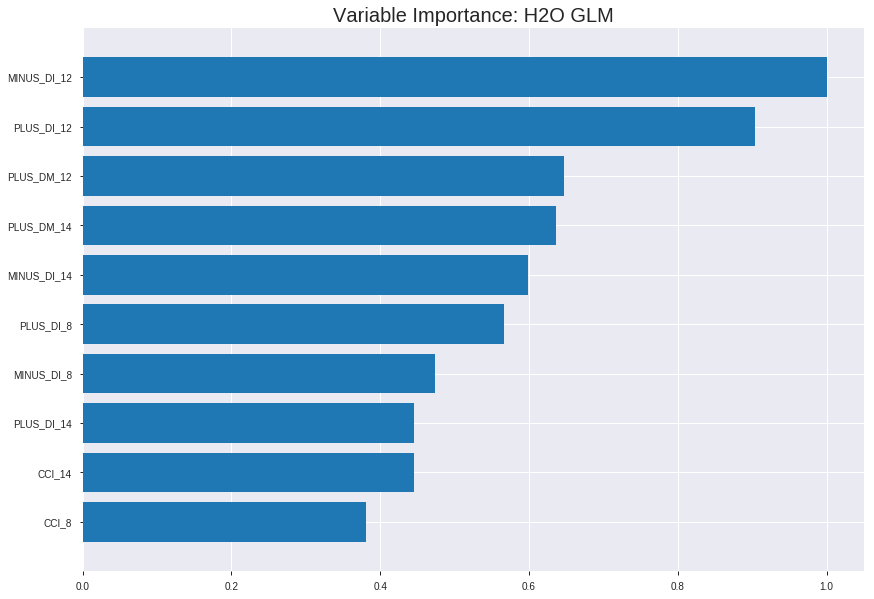

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_123355_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1795471860633264
RMSE: 0.4237300863324746
LogLoss: 0.5339952034598132
Null degrees of freedom: 1786
Residual degrees of freedom: 1736
Null deviance: 2476.5418801583887
Residual deviance: 1908.4988571653726
AIC: 2010.4988571653726
AUC: 0.8052850877192983
pr_auc: 0.8020652175274673
Gini: 0.6105701754385966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4411604518140086: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      541  334   0.3817   (334.0/875.0)
1      145  767   0.159    (145.0/912.0)
Total  686  1101  0.268    (479.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44116      0.762047  235
max f2                       0.221758     0.865385  320
max f0point5                 0.614293     0.732223  149
max accuracy                 0.44116      0.731953  235
max precision                0.997115     1         0
max recall                   0.00686317   1         398
max specificity              0.997115     1         0
max absolute_mcc             0.44116      0.472103  235
max min_per_class_accuracy   0.519963     0.712719  196
max mean_per_class_accuracy  0.44116      0.729647  235

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 51.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.976552           1.95943   1.95943            1                0.987316  1                           0.987316            0.0197368       0.0197368                  95.943    95.943
    2        0.0201455                   0.963783           1.85057   1.905              0.944444         0.970423  0.972222                    0.97887             0.0186404       0.0383772                  85.0573   90.5001
    3        0.0302182                   0.954403           1.85057   1.88686            0.944444         0.958997  0.962963                    0.972245            0.0186404       0.0570175                  85.0573   88.6858
    4        0.040291                    0.944692           1.85057   1.87779            0.944444         0.950237  0.958333                    0.966743            0.0186404       0.0756579                  85.0573   87.7787
    5        0.0503637                   0.934126           1.95943   1.89412            1                0.938618  0.966667                    0.961118            0.0197368       0.0953947                  95.943    89.4115
    6        0.100168                    0.882808           1.71725   1.80618            0.876404         0.908525  0.921788                    0.934968            0.0855263       0.180921                   71.7253   80.6178
    7        0.149972                    0.801313           1.60717   1.74009            0.820225         0.842049  0.88806                     0.904111            0.0800439       0.260965                   60.7173   74.0091
    8        0.200336                    0.74071            1.56754   1.69671            0.8              0.77252   0.865922                    0.871029            0.0789474       0.339912                   56.7544   69.6713
    9        0.299944                    0.657696           1.42004   1.60483            0.724719         0.696148  0.81903                     0.812953            0.141447        0.48136                    42.0036   60.4832
    10       0.400112                    0.590289           1.14939   1.49081            0.586592         0.624604  0.760839                    0.7658              0.115132        0.596491                   14.9386   49.0811
    11       0.50028                     0.521581           1.11655   1.41587            0.569832         0.55854   0.722595                    0.724301            0.111842        0.708333                   11.6547   41.5874
    12       0.599888                    0.449737           1.13383   1.36904            0.578652         0.486789  0.698694                    0.684864            0.112939        0.821272                   13.3827   36.9042
    13       0.700056                    0.377236           0.766257  1.28279            0.391061         0.415754  0.654676                    0.646358            0.0767544       0.898026                   -23.3743  28.2792
    14       0.799664                    0.285609           0.594434  1.19705            0.303371         0.335387  0.610917                    0.607623            0.0592105       0.957237                   -40.5566  19.7048
    15       0.899832                    0.101464           0.295556  1.0967             0.150838         0.19748   0.559701                    0.561966            0.0296053       0.986842                   -70.4444  9.66958
    16       1                           0.00254185         0.131358  1                  0.0670391        0.046694  0.510353                    0.510352          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17333794794127239
RMSE: 0.41633874182121505
LogLoss: 0.5194492308995969
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 708.9054443622276
Residual deviance: 530.877113979388
AIC: 632.877113979388
AUC: 0.8255423791138078
pr_auc: 0.8208135802482674
Gini: 0.6510847582276156
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.518161166459733: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      181  78   0.3012   (78.0/259.0)
1      48   204  0.1905   (48.0/252.0)
Total  229  282  0.2466   (126.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518161     0.764045  211
max f2                       0.258273     0.859046  320
max f0point5                 0.745796     0.75495   104
max accuracy                 0.544969     0.757339  197
max precision                0.998938     1         0
max recall                   0.0290687    1         387
max specificity              0.998938     1         0
max absolute_mcc             0.544969     0.515047  197
max min_per_class_accuracy   0.553541     0.752896  192
max mean_per_class_accuracy  0.544969     0.757508  197

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 53.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.98328            2.02778   2.02778            1                0.99032    1                           0.99032             0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.981119           2.02778   2.02778            1                0.981858   1                           0.986474            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.972683           2.02778   2.02778            1                0.976517   1                           0.983362            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.958719           1.62222   1.93122            0.8              0.967545   0.952381                    0.979596            0.015873        0.0793651                  62.2222   93.1217
    5        0.0508806                   0.951644           2.02778   1.94979            1                0.955427   0.961538                    0.974948            0.0198413       0.0992063                  102.778   94.9786
    6        0.101761                    0.920379           1.87179   1.91079            0.923077         0.934822   0.942308                    0.954885            0.0952381       0.194444                   87.1795   91.0791
    7        0.150685                    0.868451           1.86556   1.8961             0.92             0.8911     0.935065                    0.934176            0.0912698       0.285714                   86.5556   89.6104
    8        0.201566                    0.819999           1.48184   1.79153            0.730769         0.845272   0.883495                    0.911734            0.0753968       0.361111                   48.1838   79.1532
    9        0.30137                     0.709849           1.51089   1.69859            0.745098         0.767354   0.837662                    0.86392             0.150794        0.511905                   51.0893   69.8593
    10       0.401174                    0.614478           1.23257   1.58266            0.607843         0.659364   0.780488                    0.813031            0.123016        0.634921                   23.2571   58.2656
    11       0.500978                    0.550654           1.23257   1.51291            0.607843         0.58266    0.746094                    0.767137            0.123016        0.757937                   23.2571   51.2912
    12       0.600783                    0.475502           0.795207  1.39368            0.392157         0.515852   0.687296                    0.725392            0.0793651       0.837302                   -20.4793  39.3684
    13       0.700587                    0.382768           0.675926  1.29143            0.333333         0.435491   0.636872                    0.684093            0.0674603       0.904762                   -32.4074  29.1434
    14       0.800391                    0.273263           0.516885  1.19485            0.254902         0.327954   0.589242                    0.639685            0.0515873       0.956349                   -48.3115  19.4852
    15       0.900196                    0.110254           0.238562  1.08883            0.117647         0.191291   0.536957                    0.589972            0.0238095       0.980159                   -76.1438  8.88285
    16       1                           0.00189558         0.198802  1                  0.0980392        0.0539302  0.493151                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 12:33:56  0.000 sec   2            .16E2     51            1.3677030722695824  1.3676162339405897
     2019-07-25 12:33:56  0.030 sec   4            .99E1     51            1.3578752489413084  1.3568542083670792
     2019-07-25 12:33:56  0.054 sec   6            .61E1     51            1.3437023215040778  1.34121914375254
     2019-07-25 12:33:56  0.076 sec   8            .38E1     51            1.3243032320232584  1.3196279674300642
     2019-07-25 12:33:56  0.104 sec   10           .24E1     51            1.2995770887892024  1.291816592117981
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 12:33:57  0.670 sec   50           .11E-3    51            1.0693016621257732  1.0417436069389727
     2019-07-25 12:33:57  0.684 sec   51           .66E-4    51            1.0690501462089683  1.0413811284927679
     2019-07-25 12:33:57  0.714 sec   53           .41E-4    51            1.0685598207312021  1.0403702617161072
     2019-07-25 12:33:57  0.739 sec   54           .26E-4    51            1.0683553505499566  1.0398996177454198
     2019-07-25 12:33:57  0.769 sec   56           .16E-4    51            1.0679904069196267  1.0388984617991939


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.73828125)

('F1', 0.7731629392971247)

('auc', 0.8167766373411535)

('logloss', 0.512394502107961)

('mean_per_class_error', 0.2596529814271751)

('rmse', 0.41680246000037724)

('mse', 0.17372429066236605)

glm prediction progress: |████████████████████████████████████████████████| 100%


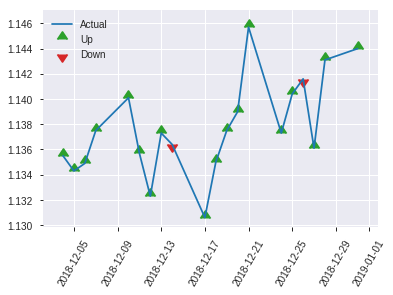


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.17372429066236605
RMSE: 0.41680246000037724
LogLoss: 0.512394502107961
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.6697985653149
Residual deviance: 262.345985079276
AIC: 364.345985079276
AUC: 0.8167766373411535
pr_auc: 0.8283132445405279
Gini: 0.6335532746823069
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3693715665946212: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   60   0.4839   (60.0/124.0)
1      11   121  0.0833   (11.0/132.0)
Total  75   181  0.2773   (71.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369372     0.773163  180
max f2                       0.192641     0.87217   222
max f0point5                 0.559041     0.762868  102
max accuracy                 0.539596     0.738281  112
max precision                0.985056     1         0
max recall                   0.0488849    1         243
max specificity              0.985056     1         0
max absolute_mcc             0.539596     0.483793  112
max min_per_class_accuracy   0.514304     0.727273  128
max mean_per_class_accuracy  0.539596     0.740347  112

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 50.13 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.972704           1.93939    1.93939            1                0.979363   1                           0.979363            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.957168           1.93939    1.93939            1                0.962924   1                           0.971144            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.954064           1.93939    1.93939            1                0.955042   1                           0.967118            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.951908           1.93939    1.93939            1                0.953073   1                           0.963288            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.937942           1.93939    1.93939            1                0.945859   1                           0.960606            0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.850153           1.93939    1.93939            1                0.910051   1                           0.935329            0.0984848       0.19697                    93.9394   93.9394
    7        0.152344                    0.78002            1.79021    1.88967            0.923077         0.814146   0.974359                    0.894935            0.0909091       0.287879                   79.021    88.9666
    8        0.203125                    0.736286           1.49184    1.79021            0.769231         0.752901   0.923077                    0.859426            0.0757576       0.363636                   49.1841   79.021
    9        0.300781                    0.638418           1.24121    1.61196            0.64             0.68485    0.831169                    0.802746            0.121212        0.484848                   24.1212   61.1964
    10       0.402344                    0.559041           1.41725    1.56281            0.730769         0.600445   0.805825                    0.751679            0.143939        0.628788                   41.7249   56.2813
    11       0.5                         0.514815           0.930909   1.43939            0.48             0.535188   0.742188                    0.709396            0.0909091       0.719697                   -6.90909  43.9394
    12       0.601562                    0.447333           0.895105   1.3475             0.461538         0.476077   0.694805                    0.670004            0.0909091       0.810606                   -10.4895  34.7501
    13       0.699219                    0.37324            0.930909   1.28932            0.48             0.405692   0.664804                    0.633089            0.0909091       0.901515                   -6.90909  28.9318
    14       0.800781                    0.272271           0.522145   1.19202            0.269231         0.318203   0.614634                    0.593152            0.0530303       0.954545                   -47.7855  19.2018
    15       0.898438                    0.148105           0.387879   1.10461            0.2              0.213044   0.569565                    0.551836            0.0378788       0.992424                   -61.2121  10.4611
    16       1                           0.015842           0.0745921  1                  0.0384615        0.0543859  0.515625  

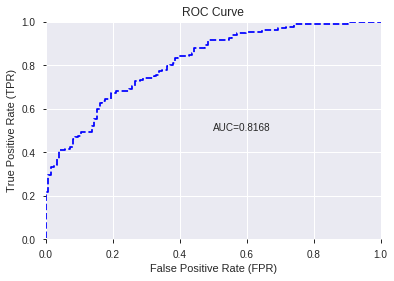

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


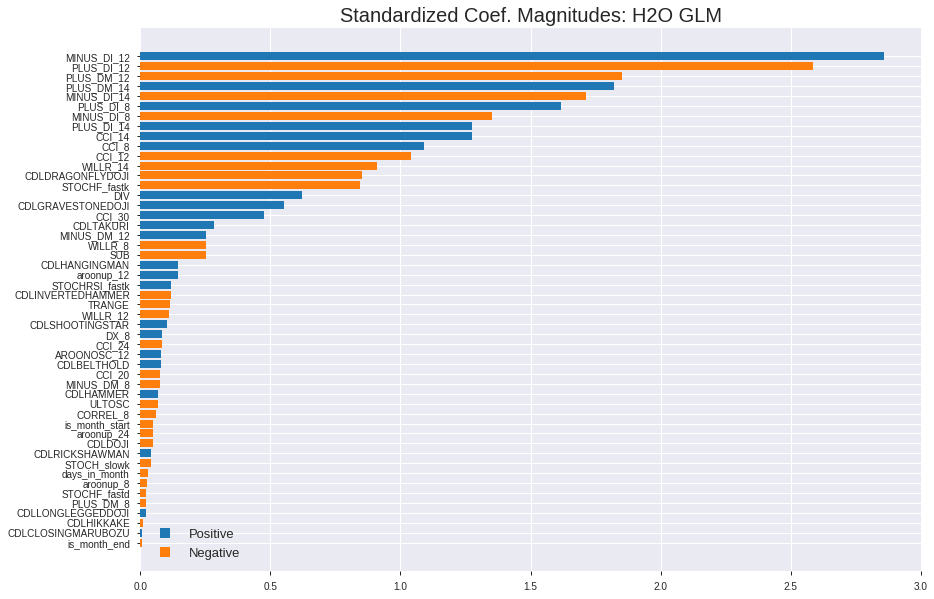

'log_likelihood'
--2019-07-25 12:34:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_123355_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_123355_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['MINUS_DI_12',
 'PLUS_DI_12',
 'PLUS_DM_12',
 'PLUS_DM_14',
 'MINUS_DI_14',
 'PLUS_DI_8',
 'MINUS_DI_8',
 'PLUS_DI_14',
 'CCI_14',
 'CCI_8',
 'CCI_12',
 'WILLR_14',
 'CDLDRAGONFLYDOJI',
 'STOCHF_fastk',
 'DIV',
 'CDLGRAVESTONEDOJI',
 'CCI_30',
 'CDLTAKURI',
 'MINUS_DM_12',
 'WILLR_8',
 'SUB',
 'CDLHANGINGMAN',
 'aroonup_12',
 'STOCHRSI_fastk',
 'CDLINVERTEDHAMMER',
 'TRANGE',
 'WILLR_12',
 'CDLSHOOTINGSTAR',
 'DX_8',
 'CCI_24',
 'AROONOSC_12',
 'CDLBELTHOLD',
 'CCI_20',
 'MINUS_DM_8',
 'CDLHAMMER',
 'ULTOSC',
 'CORREL_8',
 'is_month_start',
 'aroonup_24',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'STOCH_slowk',
 'days_in_month',
 'aroonup_8',
 'STOCHF_fastd',
 'PLUS_DM_8',
 'CDLLONGLEGGEDDOJI',
 'CDLHIKKAKE',
 'CDLCLOSINGMARUBOZU',
 'is_month_end']

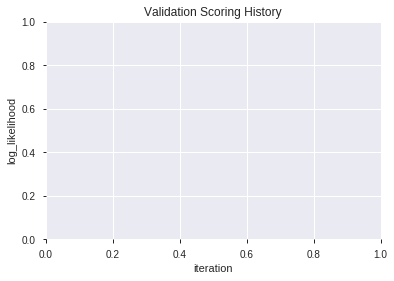

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_123412_model_7  0.822153  0.510922              0.275049  0.414429  0.171751
1  XGBoost_grid_1_AutoML_20190725_123412_model_3  0.820137  0.513624              0.278348  0.415713  0.172818
2               XGBoost_1_AutoML_20190725_123412  0.819404  0.516548              0.304497  0.416963  0.173858
3  XGBoost_grid_1_AutoML_20190725_123412_model_6  0.818426  0.513233              0.296432  0.416730  0.173664
4               XGBoost_2_AutoML_20190725_123412  0.816716  0.518278              0.300464  0.417873  0.174618
5  XGBoost_grid_1_AutoML_20190725_123412_model_2  0.812622  0.521941              0.288123  0.419974  0.176378
6  XGBoost_grid_1_AutoML_20190725_123412_model_4  0.811034  0.530740              0.296676  0.422614  0.178603
7               XGBoost_3_AutoML_20190725_123412  0.803519  0.524905              0.295943  0.421989  0.178075
8  XGBoost_grid_1_AutoML_20190725_123412_model_1  0.798631  0.532868              0.302786  0.425322  0.180899
9  XGBoost_grid_1_AutoML_20190725_123412_model_5  0.786901  0.555213              0.318671  0.437162  0.191111

variable  relative_importance  scaled_importance  percentage
0     CDLDRAGONFLYDOJI           842.361267           1.000000    0.077262
1    CDLGRAVESTONEDOJI           662.041687           0.785936    0.060723
2         STOCHF_fastk           604.733154           0.717902    0.055467
3                CCI_8           507.875977           0.602919    0.046583
4              WILLR_8           494.351715           0.586864    0.045342
5             WILLR_12           475.137421           0.564054    0.043580
6            CDLTAKURI           466.228058           0.553478    0.042763
7           MINUS_DI_8           451.367218           0.535836    0.041400
8               ULTOSC           374.781219           0.444917    0.034375
9          STOCH_slowk           333.834534           0.396308    0.030620
10              CCI_14           316.817932           0.376107    0.029059
11            WILLR_14           311.116058           0.369338    0.028536
12              TRANGE           303.593292           0.360407    0.027846
13            CORREL_8           293.732849           0.348702    0.026941
14           PLUS_DM_8           287.642670           0.341472    0.026383
15                DX_8           284.845612           0.338151    0.026126
16              CCI_12           279.360443           0.331640    0.025623
17                 DIV           261.403381           0.310322    0.023976
18          MINUS_DM_8           239.066696           0.283805    0.021927
19           PLUS_DI_8           235.684525           0.279790    0.021617
20                 SUB           232.004898           0.275422    0.021280
21              CCI_30           200.313629           0.237800    0.018373
22         MINUS_DM_12           200.069855           0.237511    0.018351
23          PLUS_DI_14           192.563217           0.228599    0.017662
24         MINUS_DI_14           182.312805           0.216431    0.016722
25              CCI_24           173.089905           0.205482    0.015876
26          aroonup_24           169.702408           0.201460    0.015565
27          PLUS_DI_12           169.594894           0.201333    0.015555
28          PLUS_DM_12           168.312302           0.199810    0.015438
29              CCI_20           167.437302           0.198771    0.015358
30           aroonup_8           165.678848           0.196684    0.015196
31          aroonup_12           158.509903           0.188173    0.014539
32      STOCHRSI_fastk           139.002335           0.165015    0.012749
33          PLUS_DM_14           120.932320           0.143563    0.011092
34         MINUS_DI_12           106.069290           0.125919    0.009729
35       days_in_month           100.506660           0.119315    0.009219
36         AROONOSC_12            95.141663           0.112946    0.008726
37        STOCHF_fastd            64.446480           0.076507    0.005911
38      CDLRICKSHAWMAN            25.301952           0.030037    0.002321
39   CDLLONGLEGGEDDOJI            23.163176           0.027498    0.002125
40             CDLDOJI            15.771650           0.018723    0.001447
41  CDLCLOSINGMARUBOZU             5.049486           0.005994    0.000463
42     CDLSHOOTINGSTAR             1.683090           0.001998    0.000154

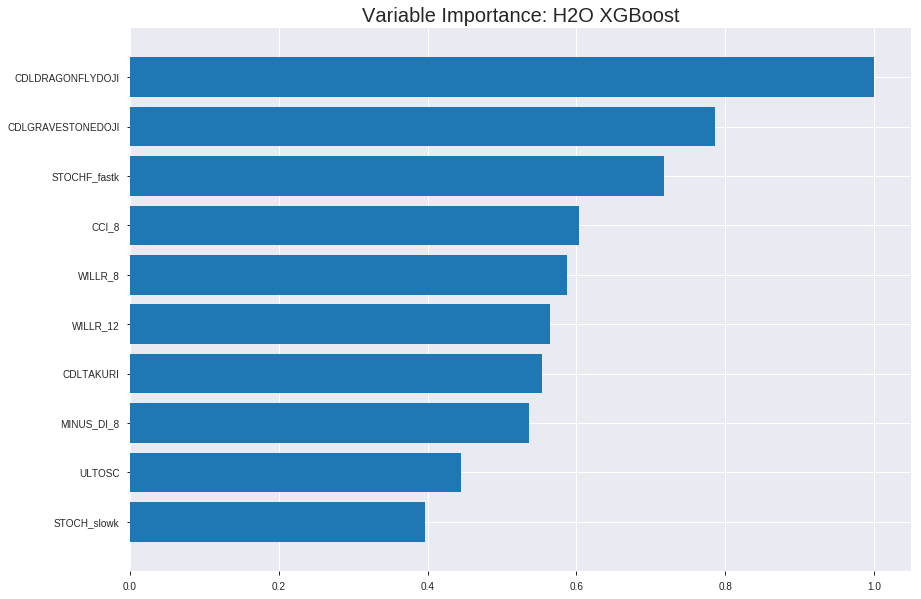

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_123412_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10603599049934392
RMSE: 0.3256316792011243
LogLoss: 0.3632970603000571
Mean Per-Class Error: 0.09541917293233082
AUC: 0.9577537593984962
pr_auc: 0.9565042753361688
Gini: 0.9155075187969923
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5067521035671234: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      777  98   0.112    (98.0/875.0)
1      75   837  0.0822   (75.0/912.0)
Total  852  935  0.0968   (173.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.506752     0.906335  206
max f2                       0.427915     0.929392  233
max f0point5                 0.551731     0.914522  186
max accuracy                 0.538135     0.904309  193
max precision                0.959227     1         0
max recall                   0.119738     1         359
max specificity              0.959227     1         0
max absolute_mcc             0.538135     0.809025  193
max min_per_class_accuracy   0.525902     0.901316  198
max mean_per_class_accuracy  0.538135     0.904581  193

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 50.79 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.941678           1.95943    1.95943            1                0.950629   1                           0.950629            0.0197368       0.0197368                  95.943    95.943
    2        0.0201455                   0.932512           1.95943    1.95943            1                0.937116   1                           0.943873            0.0197368       0.0394737                  95.943    95.943
    3        0.0302182                   0.922663           1.95943    1.95943            1                0.927412   1                           0.938386            0.0197368       0.0592105                  95.943    95.943
    4        0.040291                    0.915703           1.95943    1.95943            1                0.919782   1                           0.933735            0.0197368       0.0789474                  95.943    95.943
    5        0.0503637                   0.908298           1.95943    1.95943            1                0.911874   1                           0.929363            0.0197368       0.0986842                  95.943    95.943
    6        0.100168                    0.868997           1.95943    1.95943            1                0.889047   1                           0.909317            0.0975877       0.196272                   95.943    95.943
    7        0.149972                    0.826926           1.9154     1.94481            0.977528         0.847878   0.992537                    0.888914            0.0953947       0.291667                   91.5398   94.4807
    8        0.200336                    0.788069           1.87234    1.92659            0.955556         0.808858   0.98324                     0.868788            0.0942982       0.385965                   87.2344   92.659
    9        0.299944                    0.707834           1.88237    1.91191            0.960674         0.745765   0.975746                    0.827934            0.1875          0.573465                   88.2374   91.1906
    10       0.400112                    0.632889           1.70766    1.86077            0.871508         0.670505   0.94965                     0.788521            0.171053        0.744518                   70.766    86.0773
    11       0.50028                     0.532473           1.52157    1.79286            0.776536         0.583519   0.914989                    0.747475            0.152412        0.89693                    52.1568   79.2856
    12       0.599888                    0.414918           0.638466   1.60118            0.325843         0.47688    0.817164                    0.702544            0.0635965       0.960526                   -36.1534  60.1176
    13       0.700056                    0.312313           0.218931   1.4034             0.111732         0.365461   0.716227                    0.654312            0.0219298       0.982456                   -78.1069  40.3397
    14       0.799664                    0.209655           0.0770562  1.23818            0.0393258        0.263187   0.63191                     0.605593            0.00767544      0.990132                   -92.2944  23.8184
    15       0.899832                    0.109682           0.0985188  1.11132            0.0502793        0.160524   0.567164                    0.556048            0.00986842      1                          -90.1481  11.1318
    16       1                           0.0342776          0          1                  0                0.0753027  0.510353        



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17743530667642146
RMSE: 0.4212307048120085
LogLoss: 0.5313845514431097
Mean Per-Class Error: 0.25681038181038185
AUC: 0.8179735858307287
pr_auc: 0.8014163202188119
Gini: 0.6359471716614573
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4453796446323395: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      158  101  0.39     (101.0/259.0)
1      33   219  0.131    (33.0/252.0)
Total  191  320  0.2622   (134.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44538      0.765734  247
max f2                       0.196967     0.85595   336
max f0point5                 0.744579     0.763575  117
max accuracy                 0.65747      0.741683  154
max precision                0.965112     1         0
max recall                   0.050837     1         395
max specificity              0.965112     1         0
max absolute_mcc             0.460256     0.49779   239
max min_per_class_accuracy   0.574556     0.72619   190
max mean_per_class_accuracy  0.460256     0.74319   239

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 54.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.947029           2.02778   2.02778            1                0.955581  1                           0.955581            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.935759           2.02778   2.02778            1                0.938661  1                           0.94789             0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.929158           1.62222   1.90104            0.8              0.933325  0.9375                      0.943339            0.015873        0.0595238                  62.2222   90.1042
    4        0.0410959                   0.923982           1.62222   1.83466            0.8              0.92578   0.904762                    0.939158            0.015873        0.0753968                  62.2222   83.4656
    5        0.0508806                   0.916468           1.62222   1.7938             0.8              0.920067  0.884615                    0.935487            0.015873        0.0912698                  62.2222   79.3803
    6        0.101761                    0.889817           1.87179   1.8328             0.923077         0.900598  0.903846                    0.918042            0.0952381       0.186508                   87.1795   83.2799
    7        0.150685                    0.860008           1.78444   1.8171             0.88             0.874232  0.896104                    0.903818            0.0873016       0.27381                    78.4444   81.71
    8        0.201566                    0.829344           1.63782   1.77184            0.807692         0.844268  0.873786                    0.888786            0.0833333       0.357143                   63.7821   77.1845
    9        0.30137                     0.754507           1.63017   1.72493            0.803922         0.795428  0.850649                    0.857869            0.162698        0.519841                   63.0174   72.4928
    10       0.401174                    0.661754           1.23257   1.60244            0.607843         0.707481  0.790244                    0.820455            0.123016        0.642857                   23.2571   60.2439
    11       0.500978                    0.567912           0.874728  1.45747            0.431373         0.61871   0.71875                     0.780264            0.0873016       0.730159                   -12.5272  45.7465
    12       0.600783                    0.464909           1.15305   1.40689            0.568627         0.518026  0.693811                    0.7367              0.115079        0.845238                   15.305    40.6895
    13       0.700587                    0.361187           0.636166  1.2971             0.313725         0.416294  0.639665                    0.691055            0.0634921       0.90873                    -36.3834  29.7098
    14       0.800391                    0.24579            0.397603  1.18494            0.196078         0.312374  0.584352                    0.643836            0.0396825       0.948413                   -60.2397  18.4936
    15       0.900196                    0.128697           0.318083  1.08883            0.156863         0.182969  0.536957                    0.59274             0.031746        0.980159                   -68.1917  8.88285
    16       1                           0.0355161          0.198802  1                  0.0980392        0.082851  0.493151                    0.541851           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 12:34:34  14.751 sec  0                  0.5              0.693147            0.5             0                  1                0.489647                         0.5                0.693147              0.5               0                    1                  0.506849
    2019-07-25 12:34:34  14.897 sec  5                  0.466544         0.627932            0.867885        0.873187           1.95943          0.214885                         0.471469           0.637206              0.806214          0.77445              1.7381             0.264188
    2019-07-25 12:34:35  14.999 sec  10                 0.440414         0.578328            0.891182        0.89327            1.95943          0.187465                         0.454039           0.603156              0.810075          0.802833             2.02778            0.273973
    2019-07-25 12:34:35  15.112 sec  15                 0.420181         0.539911            0.899333        0.901283           1.95943          0.189144                         0.441006           0.576825              0.812251          0.804726             2.02778            0.25636
    2019-07-25 12:34:35  15.211 sec  20                 0.405161         0.510909            0.905204        0.905178           1.95943          0.174035                         0.434241           0.562244              0.810665          0.791543             2.02778            0.272016
    2019-07-25 12:34:35  15.336 sec  25                 0.392018         0.485582            0.912123        0.914787           1.95943          0.157806                         0.429224           0.551245              0.813737          0.798067             2.02778            0.270059
    2019-07-25 12:34:35  15.433 sec  30                 0.382269         0.46657             0.918204        0.919918           1.95943          0.156128                         0.426375           0.543997              0.815514          0.802273             2.02778            0.277886
    2019-07-25 12:34:35  15.535 sec  35                 0.37195          0.44706             0.92537         0.925101           1.95943          0.144376                         0.4231             0.536778              0.818387          0.805521             2.02778            0.262231
    2019-07-25 12:34:35  15.640 sec  40                 0.364075         0.432232            0.931722        0.932795           1.95943          0.132625                         0.422347           0.534708              0.81733           0.800061             2.02778            0.258317
    2019-07-25 12:34:35  15.742 sec  45                 0.35652          0.418208            0.936779        0.935458           1.95943          0.124231                         0.42214            0.533293              0.817139          0.801727             2.02778            0.260274
    2019-07-25 12:34:35  15.843 sec  50                 0.350891         0.407413            0.939964        0.94072            1.95943          0.123111                         0.421765           0.53222               0.818533          0.802816             2.02778            0.262231
    2019-07-25 12:34:35  15.951 sec  55                 0.343622         0.394422            0.945375        0.943842           1.95943          0.11136                          0.42197            0.532984              0.817338          0.

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ----------------------
CDLDRAGONFLYDOJI    842.3612670898438      1.0                   0.07726218126912235
CDLGRAVESTONEDOJI   662.0416870117188      0.7859355752418604    0.060723096880188565
STOCHF_fastk        604.733154296875       0.7179023750535006    0.055466703434917025
CCI_8               507.8759765625         0.6029194318455426    0.046582870433926574
WILLR_8             494.3517150878906      0.5868642521940227    0.04534241223338252
---                 ---                    ---                   ---
CDLRICKSHAWMAN      25.301952362060547     0.030036937060832256  0.002320719275963241
CDLLONGLEGGEDDOJI   23.163175582885742     0.02749791151118446   0.0021245486236994198
CDLDOJI             15.771650314331055     0.018723142825427298  0.0014465908549058314
CDLCLOSINGMARUBOZU  5.04948616027832       0.005994442476828362  0.0004631437012520397
CDLSHOOTINGSTAR     1.6830902099609375     0.001998062204089239  0.00015437464419932494


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.73828125)

('F1', 0.7752442996742671)

('auc', 0.822152981427175)

('logloss', 0.510921816071807)

('mean_per_class_error', 0.2620967741935484)

('rmse', 0.41442907261890705)

('mse', 0.17175145623176735)

xgboost prediction progress: |████████████████████████████████████████████| 100%


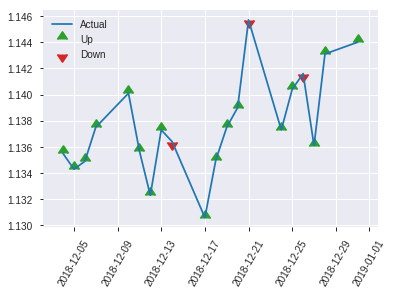


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17175145623176735
RMSE: 0.41442907261890705
LogLoss: 0.510921816071807
Mean Per-Class Error: 0.2620967741935484
AUC: 0.822152981427175
pr_auc: 0.8313112971663525
Gini: 0.6443059628543499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40332189202308655: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   56   0.4516   (56.0/124.0)
1      13   119  0.0985   (13.0/132.0)
Total  81   175  0.2695   (69.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403322     0.775244  174
max f2                       0.185164     0.870147  218
max f0point5                 0.6618       0.779915  83
max accuracy                 0.516622     0.738281  132
max precision                0.955099     1         0
max recall                   0.0879526    1         239
max specificity              0.955099     1         0
max absolute_mcc             0.6618       0.49421   83
max min_per_class_accuracy   0.520765     0.725806  129
max mean_per_class_accuracy  0.516622     0.737903  132

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 52.13 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.9334             1.93939    1.93939            1                0.947614   1                           0.947614            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.927641           1.93939    1.93939            1                0.928971   1                           0.938293            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.913146           1.93939    1.93939            1                0.920324   1                           0.9338              0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.910767           1.93939    1.93939            1                0.911718   1                           0.927778            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.905044           1.93939    1.93939            1                0.908461   1                           0.924806            0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.858812           1.93939    1.93939            1                0.88263    1                           0.903718            0.0984848       0.19697                    93.9394   93.9394
    7        0.152344                    0.817309           1.64103    1.83994            0.846154         0.836155   0.948718                    0.881197            0.0833333       0.280303                   64.1026   83.9938
    8        0.203125                    0.781727           1.19347    1.67832            0.615385         0.796309   0.865385                    0.859975            0.0606061       0.340909                   19.3473   67.8322
    9        0.300781                    0.681986           1.70667    1.68752            0.88             0.739181   0.87013                     0.820756            0.166667        0.507576                   70.6667   68.7525
    10       0.402344                    0.607004           1.04429    1.52515            0.538462         0.643614   0.786408                    0.776041            0.106061        0.613636                   4.4289    52.5154
    11       0.5                         0.526896           1.00848    1.42424            0.52             0.57327    0.734375                    0.736437            0.0984848       0.712121                   0.848485  42.4242
    12       0.601562                    0.452783           0.895105   1.33491            0.461538         0.487834   0.688312                    0.694465            0.0909091       0.80303                    -10.4895  33.4908
    13       0.699219                    0.391152           1.08606    1.30015            0.56             0.419739   0.670391                    0.656095            0.106061        0.909091                   8.60606   30.0152
    14       0.800781                    0.271023           0.522145   1.20148            0.269231         0.341813   0.619512                    0.616235            0.0530303       0.962121                   -47.7855  20.1478
    15       0.898438                    0.131632           0.310303   1.10461            0.16             0.20211    0.569565                    0.571222            0.030303        0.992424                   -68.9697  10.4611
    16       1                           0.0455344          0.0745921  1                  0.0384615        0.0793764  0.515625 

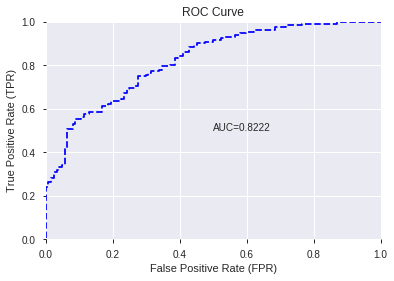

This function is available for GLM models only


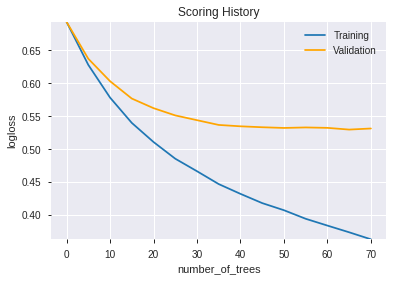

--2019-07-25 12:34:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_123412_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_123412_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'CCI_8',
 'WILLR_8',
 'WILLR_12',
 'CDLTAKURI',
 'MINUS_DI_8',
 'ULTOSC',
 'STOCH_slowk',
 'CCI_14',
 'WILLR_14',
 'TRANGE',
 'CORREL_8',
 'PLUS_DM_8',
 'DX_8',
 'CCI_12',
 'DIV',
 'MINUS_DM_8',
 'PLUS_DI_8',
 'SUB',
 'CCI_30',
 'MINUS_DM_12',
 'PLUS_DI_14',
 'MINUS_DI_14',
 'CCI_24',
 'aroonup_24',
 'PLUS_DI_12',
 'PLUS_DM_12',
 'CCI_20',
 'aroonup_8',
 'aroonup_12',
 'STOCHRSI_fastk',
 'PLUS_DM_14',
 'MINUS_DI_12',
 'days_in_month',
 'AROONOSC_12',
 'STOCHF_fastd',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLCLOSINGMARUBOZU',
 'CDLSHOOTINGSTAR']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse     mse
0  GLM_grid_1_AutoML_20190725_123450_model_1  0.801381  0.533204              0.266496  0.425558  0.1811

variable  relative_importance  scaled_importance    percentage
0                        CCI_8             0.354210           1.000000  2.114367e-02
1                 STOCHF_fastk             0.349284           0.986091  2.084958e-02
2            CDLGRAVESTONEDOJI             0.345125           0.974351  2.060136e-02
3                   MINUS_DI_8             0.276077           0.779415  1.647970e-02
4             CDLDRAGONFLYDOJI             0.267581           0.755430  1.597258e-02
...                        ...                  ...                ...           ...
1018   BBANDS_lowerband_12_4_3             0.000038           0.000109  2.294643e-06
1019   BBANDS_lowerband_14_2_5             0.000035           0.000099  2.101543e-06
1020                   ROCR_24             0.000020           0.000055  1.168798e-06
1021  BBANDS_middleband_30_5_3             0.000012           0.000035  7.436713e-07
1022  BBANDS_middleband_30_5_4             0.000005           0.000014  3.010728e-07

[1023 rows x 4 columns]

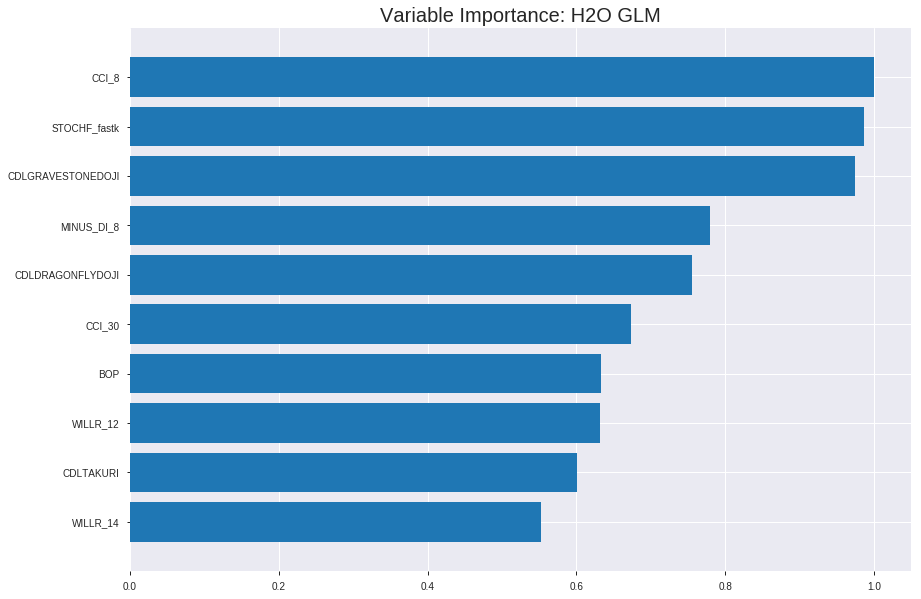

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_123450_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1728512042536828
RMSE: 0.4157537783997673
LogLoss: 0.5161251916895062
Null degrees of freedom: 1786
Residual degrees of freedom: 763
Null deviance: 2476.5418801583887
Residual deviance: 1844.6314350982952
AIC: 3892.6314350982952
AUC: 0.8245770676691729
pr_auc: 0.8267589047642514
Gini: 0.6491541353383459
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38041573996540173: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      423  452   0.5166   (452.0/875.0)
1      62   850   0.068    (62.0/912.0)
Total  485  1302  0.2876   (514.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.380416     0.767841  267
max f2                       0.340248     0.871851  286
max f0point5                 0.566182     0.752064  171
max accuracy                 0.505062     0.73643   205
max precision                0.994487     1         0
max recall                   0.0312202    1         391
max specificity              0.994487     1         0
max absolute_mcc             0.45853      0.475873  228
max min_per_class_accuracy   0.519856     0.729143  195
max mean_per_class_accuracy  0.505062     0.735702  205

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 51.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.965159           1.95943   1.95943            1                0.976162   1                           0.976162            0.0197368       0.0197368                  95.943    95.943
    2        0.0201455                   0.945724           1.95943   1.95943            1                0.952358   1                           0.96426             0.0197368       0.0394737                  95.943    95.943
    3        0.0302182                   0.933824           1.85057   1.92314            0.944444         0.940241   0.981481                    0.956254            0.0186404       0.058114                   85.0573   92.3144
    4        0.040291                    0.918917           1.85057   1.905              0.944444         0.926701   0.972222                    0.948866            0.0186404       0.0767544                  85.0573   90.5001
    5        0.0503637                   0.908113           1.85057   1.89412            0.944444         0.913764   0.966667                    0.941845            0.0186404       0.0953947                  85.0573   89.4115
    6        0.100168                    0.850607           1.82733   1.86091            0.932584         0.881531   0.949721                    0.911857            0.0910088       0.186404                   82.7333   86.0911
    7        0.149972                    0.777926           1.73927   1.82052            0.88764          0.814186   0.929104                    0.879421            0.0866228       0.273026                   73.9269   82.0515
    8        0.200336                    0.715038           1.76349   1.80618            0.9              0.745561   0.921788                    0.845769            0.0888158       0.361842                   76.3487   80.6178
    9        0.299944                    0.634266           1.26592   1.62677            0.646067         0.673815   0.830224                    0.788665            0.126096        0.487939                   26.5924   62.6765
    10       0.400112                    0.574822           1.30264   1.54562            0.664804         0.603359   0.788811                    0.742274            0.130482        0.618421                   30.2638   54.562
    11       0.50028                     0.521429           1.07276   1.45094            0.547486         0.545792   0.740492                    0.702933            0.107456        0.725877                   7.27605   45.0942
    12       0.599888                    0.467938           1.02375   1.38001            0.522472         0.495898   0.704291                    0.668556            0.101974        0.827851                   2.3747    38.0009
    13       0.700056                    0.394552           0.788151  1.29532            0.402235         0.428805   0.661071                    0.634251            0.0789474       0.906798                   -21.1849  29.5323
    14       0.799664                    0.314018           0.627458  1.21213            0.320225         0.360869   0.618614                    0.600198            0.0625          0.969298                   -37.2542  21.2132
    15       0.899832                    0.131453           0.175145  1.0967             0.0893855        0.235509   0.559701                    0.559601            0.0175439       0.986842                   -82.4855  9.66958
    16       1                           0.00600319         0.131358  1                  0.0670391        0.0679377  0.510353                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17849604179636966
RMSE: 0.4224879191129252
LogLoss: 0.5341657697463424
Null degrees of freedom: 510
Residual degrees of freedom: -513
Null deviance: 708.9054443622276
Residual deviance: 545.917416680762
AIC: 2593.917416680762
AUC: 0.8125957590243305
pr_auc: 0.8040844354835964
Gini: 0.6251915180486609
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37849078637736744: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      147  112  0.4324   (112.0/259.0)
1      30   222  0.119    (30.0/252.0)
Total  177  334  0.2779   (142.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378491     0.757679  253
max f2                       0.1473       0.850551  342
max f0point5                 0.574801     0.743927  145
max accuracy                 0.467143     0.741683  201
max precision                0.988984     1         0
max recall                   0.0360907    1         387
max specificity              0.988984     1         0
max absolute_mcc             0.447629     0.487461  214
max min_per_class_accuracy   0.478404     0.738095  192
max mean_per_class_accuracy  0.447629     0.742439  214

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 48.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.972995           1.68981   1.68981            0.833333         0.978182  0.833333                    0.978182            0.0198413       0.0198413                  68.9815   68.9815
    2        0.0215264                   0.956481           2.02778   1.84343            1                0.965252  0.909091                    0.972305            0.0198413       0.0396825                  102.778   84.3434
    3        0.0313112                   0.94092            2.02778   1.90104            1                0.946792  0.9375                      0.964332            0.0198413       0.0595238                  102.778   90.1042
    4        0.0410959                   0.92554            2.02778   1.93122            1                0.935979  0.952381                    0.957581            0.0198413       0.0793651                  102.778   93.1217
    5        0.0508806                   0.914935           2.02778   1.94979            1                0.92196   0.961538                    0.950731            0.0198413       0.0992063                  102.778   94.9786
    6        0.101761                    0.859153           2.02778   1.98878            1                0.886857  0.980769                    0.918794            0.103175        0.202381                   102.778   98.8782
    7        0.150685                    0.802056           1.62222   1.86977            0.8              0.832739  0.922078                    0.890854            0.0793651       0.281746                   62.2222   86.9769
    8        0.201566                    0.745752           1.40385   1.75216            0.692308         0.779189  0.864078                    0.862667            0.0714286       0.353175                   40.3846   75.2157
    9        0.30137                     0.627877           1.47113   1.65909            0.72549          0.68285   0.818182                    0.803117            0.146825        0.5                        47.1133   65.9091
    10       0.401174                    0.543276           1.27233   1.56287            0.627451         0.580977  0.770732                    0.747853            0.126984        0.626984                   27.2331   56.2873
    11       0.500978                    0.472715           1.11329   1.47331            0.54902          0.50633   0.726562                    0.699737            0.111111        0.738095                   11.329    47.3307
    12       0.600783                    0.415771           0.914488  1.38047            0.45098          0.445834  0.680782                    0.657558            0.0912698       0.829365                   -8.5512   38.0474
    13       0.700587                    0.347416           0.715686  1.28577            0.352941         0.377798  0.634078                    0.617704            0.0714286       0.900794                   -28.4314  28.577
    14       0.800391                    0.245338           0.357843  1.17006            0.176471         0.305172  0.577017                    0.578733            0.0357143       0.936508                   -64.2157  17.0062
    15       0.900196                    0.0947899          0.477124  1.09324            0.235294         0.171134  0.53913                     0.533542            0.047619        0.984127                   -52.2876  9.32367
    16       1                           0.00081764         0.159041  1                  0.0784314        0.051326  0.493151                    0.485415          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 12:34:55  0.000 sec   2            .16E2     847           1.364287804514716   1.365494967803005
     2019-07-25 12:34:57  2.362 sec   4            .12E2     879           1.3572234280073183  1.3581956995761026
     2019-07-25 12:34:59  4.675 sec   6            .84E1     933           1.3482353419752409  1.3487880917203865
     2019-07-25 12:35:01  6.963 sec   8            .61E1     996           1.3369559644994795  1.3368060999078784
     2019-07-25 12:35:04  9.181 sec   10           .45E1     1020          1.3231559308250915  1.322008258080852
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 12:35:44  49.624 sec  44           .2E-1     1024          1.0222312598833874  1.0692262593523882
     2019-07-25 12:35:46  51.958 sec  46           .15E-1    1024          1.013244756709434   1.071510548083203
     2019-07-25 12:35:49  54.306 sec  48           .11E-1    1024          1.0051679419655708  1.0747503367630264
     2019-07-25 12:35:51  56.644 sec  50           .78E-2    1024          0.9978859305582942  1.0788887431463392
     2019-07-25 12:35:54  58.983 sec  52           .57E-2    1024          0.9911208192176378  1.0839009069262862


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.73828125)

('F1', 0.7774086378737541)

('auc', 0.801380742913001)

('logloss', 0.533204495525619)

('mean_per_class_error', 0.2664956011730205)

('rmse', 0.4255582701164475)

('mse', 0.1810998412645033)

glm prediction progress: |████████████████████████████████████████████████| 100%


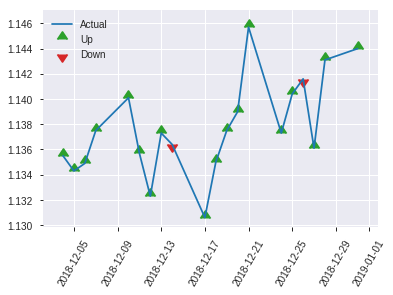


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1810998412645033
RMSE: 0.4255582701164475
LogLoss: 0.533204495525619
Null degrees of freedom: 255
Residual degrees of freedom: -768
Null deviance: 354.6697985653149
Residual deviance: 273.0007017091169
AIC: 2321.000701709117
AUC: 0.801380742913001
pr_auc: 0.8081434189086076
Gini: 0.602761485826002
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39457436959582165: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   52   0.4194   (52.0/124.0)
1      15   117  0.1136   (15.0/132.0)
Total  87   169  0.2617   (67.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394574     0.777409  168
max f2                       0.258254     0.874832  214
max f0point5                 0.443474     0.725138  147
max accuracy                 0.394574     0.738281  168
max precision                0.967896     1         0
max recall                   0.0490138    1         250
max specificity              0.967896     1         0
max absolute_mcc             0.394574     0.492742  168
max min_per_class_accuracy   0.483914     0.69697   128
max mean_per_class_accuracy  0.394574     0.733504  168

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 49.20 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.959317           1.93939    1.93939            1                0.96632   1                           0.96632             0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.945775           1.93939    1.93939            1                0.951037  1                           0.958679            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.923539           1.93939    1.93939            1                0.924818  1                           0.950213            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.907924           1.93939    1.93939            1                0.915728  1                           0.940808            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.90162            1.93939    1.93939            1                0.903595  1                           0.935083            0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.828426           1.79021    1.8648             0.923077         0.865444  0.961538                    0.900264            0.0909091       0.189394                   79.021    86.4802
    7        0.152344                    0.756642           1.79021    1.83994            0.923077         0.797613  0.948718                    0.866047            0.0909091       0.280303                   79.021    83.9938
    8        0.203125                    0.696364           1.49184    1.75291            0.769231         0.714707  0.903846                    0.828212            0.0757576       0.356061                   49.1841   75.2914
    9        0.300781                    0.607133           1.16364    1.56159            0.6              0.6488    0.805195                    0.769961            0.113636        0.469697                   16.3636   56.159
    10       0.402344                    0.542378           1.11888    1.44984            0.576923         0.571895  0.747573                    0.719964            0.113636        0.583333                   11.8881   44.9838
    11       0.5                         0.485102           1.08606    1.37879            0.56             0.514197  0.710938                    0.679775            0.106061        0.689394                   8.60606   37.8788
    12       0.601562                    0.423033           1.19347    1.3475             0.615385         0.459504  0.694805                    0.642586            0.121212        0.810606                   19.3473   34.7501
    13       0.699219                    0.372741           0.930909   1.28932            0.48             0.398753  0.664804                    0.608531            0.0909091       0.901515                   -6.90909  28.9318
    14       0.800781                    0.297688           0.596737   1.20148            0.307692         0.340147  0.619512                    0.574493            0.0606061       0.962121                   -40.3263  20.1478
    15       0.898438                    0.176526           0.310303   1.10461            0.16             0.245967  0.569565                    0.538783            0.030303        0.992424                   -68.9697  10.4611
    16       1                           0.0328407          0.0745921  1                  0.0384615        0.077743  0.515625                    

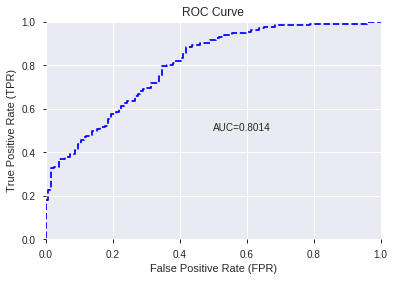

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


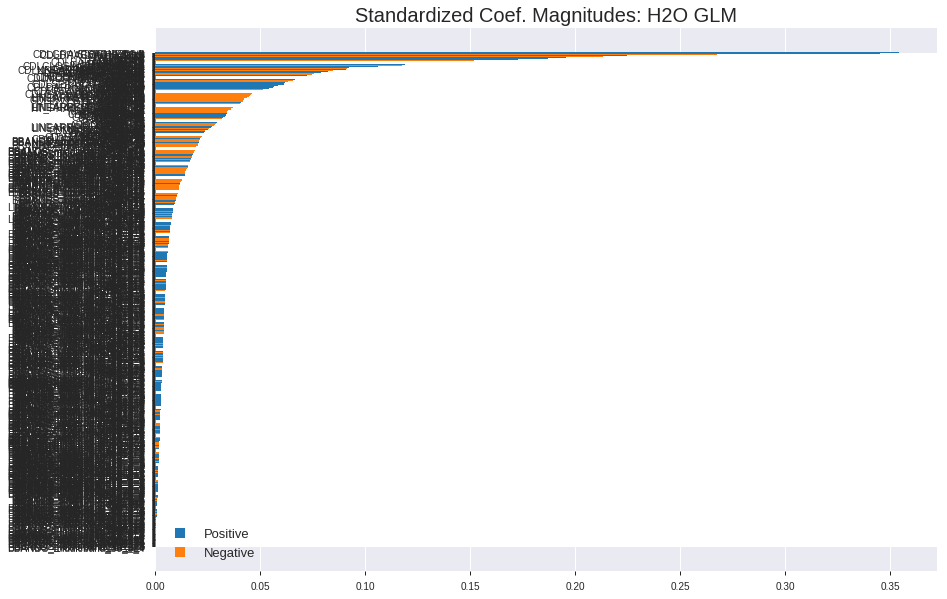

'log_likelihood'
--2019-07-25 12:36:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_123450_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_123450_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

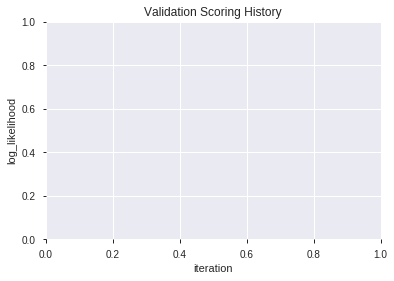

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_123632_model_7  0.826674  0.510701              0.252688  0.413022  0.170587
1               XGBoost_1_AutoML_20190725_123632  0.823497  0.515336              0.246945  0.415428  0.172581
2  XGBoost_grid_1_AutoML_20190725_123632_model_4  0.818671  0.529133              0.260508  0.420594  0.176899
3  XGBoost_grid_1_AutoML_20190725_123632_model_3  0.815127  0.523939              0.294721  0.419984  0.176387
4  XGBoost_grid_1_AutoML_20190725_123632_model_6  0.815066  0.524930              0.269795  0.419892  0.176309
5               XGBoost_3_AutoML_20190725_123632  0.810423  0.528090              0.291422  0.421638  0.177779
6  XGBoost_grid_1_AutoML_20190725_123632_model_5  0.808895  0.529285              0.282136  0.423863  0.179660
7  XGBoost_grid_1_AutoML_20190725_123632_model_1  0.805535  0.529139              0.299731  0.423064  0.178983
8               XGBoost_2_AutoML_20190725_123632  0.803091  0.534264              0.282380  0.425892  0.181384
9  XGBoost_grid_1_AutoML_20190725_123632_model_2  0.801381  0.534504              0.325147  0.425083  0.180696

variable  relative_importance  scaled_importance  percentage
0           CDLDRAGONFLYDOJI           933.416687           1.000000    0.065603
1          CDLGRAVESTONEDOJI           628.848206           0.673706    0.044197
2               STOCHF_fastk           565.401978           0.605734    0.039738
3                    WILLR_8           401.304413           0.429931    0.028205
4                  CDLTAKURI           343.152893           0.367631    0.024118
..                       ...                  ...                ...         ...
411  BBANDS_lowerband_12_5_2             1.824798           0.001955    0.000128
412  BBANDS_upperband_14_0_3             1.693313           0.001814    0.000119
413   BBANDS_lowerband_8_6_2             1.384310           0.001483    0.000097
414   BBANDS_lowerband_8_0_2             1.231901           0.001320    0.000087
415  BBANDS_upperband_24_3_2             0.387461           0.000415    0.000027

[416 rows x 4 columns]

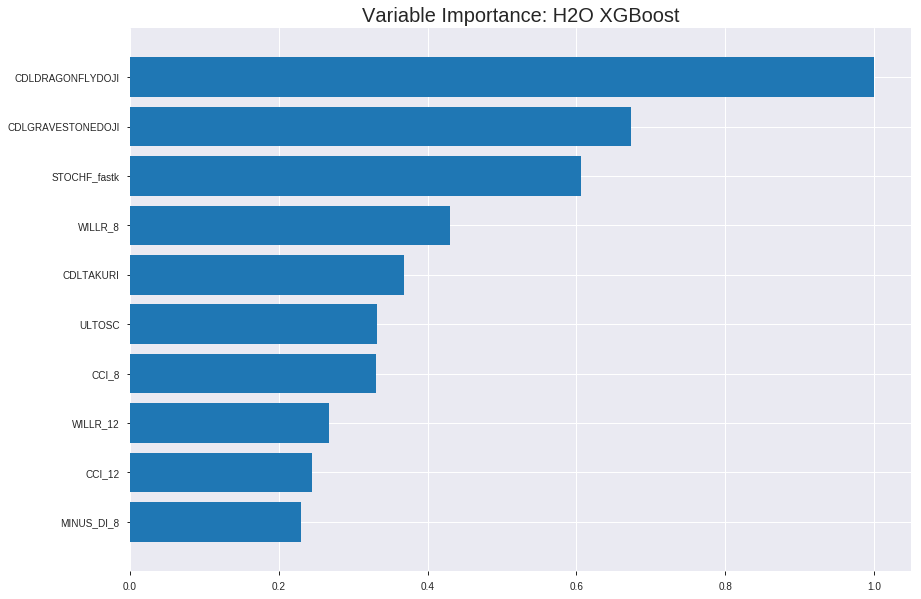

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_123632_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.0729236608264906
RMSE: 0.27004381279061107
LogLoss: 0.28470191086667085
Mean Per-Class Error: 0.03904949874686714
AUC: 0.9897675438596492
pr_auc: 0.990022627874086
Gini: 0.9795350877192983
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5143941044807434: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      840  35   0.04     (35.0/875.0)
1      35   877  0.0384   (35.0/912.0)
Total  875  912  0.0392   (70.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.514394     0.961623  197
max f2                       0.469291     0.963882  211
max f0point5                 0.596372     0.967704  172
max accuracy                 0.531864     0.960828  192
max precision                0.967482     1         0
max recall                   0.14408      1         343
max specificity              0.967482     1         0
max absolute_mcc             0.531864     0.921728  192
max min_per_class_accuracy   0.514394     0.96      197
max mean_per_class_accuracy  0.531864     0.960951  192

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 50.91 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.949488           1.95943    1.95943            1                0.956525   1                           0.956525            0.0197368       0.0197368                  95.943    95.943
    2        0.0201455                   0.942204           1.95943    1.95943            1                0.94568    1                           0.951102            0.0197368       0.0394737                  95.943    95.943
    3        0.0302182                   0.936435           1.95943    1.95943            1                0.939556   1                           0.947254            0.0197368       0.0592105                  95.943    95.943
    4        0.040291                    0.927597           1.95943    1.95943            1                0.931213   1                           0.943243            0.0197368       0.0789474                  95.943    95.943
    5        0.0503637                   0.920501           1.95943    1.95943            1                0.92421    1                           0.939437            0.0197368       0.0986842                  95.943    95.943
    6        0.100168                    0.885706           1.95943    1.95943            1                0.902102   1                           0.920873            0.0975877       0.196272                   95.943    95.943
    7        0.149972                    0.85415            1.95943    1.95943            1                0.870189   1                           0.904042            0.0975877       0.29386                    95.943    95.943
    8        0.200336                    0.826178           1.95943    1.95943            1                0.839307   1                           0.887768            0.0986842       0.392544                   95.943    95.943
    9        0.299944                    0.759808           1.94842    1.95577            0.994382         0.79266    0.998134                    0.856183            0.194079        0.586623                   94.8422   95.5774
    10       0.400112                    0.687468           1.92659    1.94847            0.98324          0.724993   0.994406                    0.82334             0.192982        0.779605                   92.659    94.8468
    11       0.50028                     0.542097           1.70766    1.90025            0.871508         0.625002   0.969799                    0.783628            0.171053        0.950658                   70.766    90.0252
    12       0.599888                    0.352183           0.374273   1.64687            0.191011         0.436391   0.840485                    0.725971            0.0372807       0.987939                   -62.5727  64.6872
    13       0.700056                    0.263409           0.0656792  1.42063            0.0335196        0.304165   0.72502                     0.665617            0.00657895      0.994518                   -93.4321  42.0626
    14       0.799664                    0.182453           0.0440321  1.24915            0.0224719        0.222593   0.637509                    0.610432            0.00438596      0.998904                   -95.5968  24.9154
    15       0.899832                    0.103321           0.0109465  1.11132            0.00558659       0.140716   0.567164                    0.558144            0.00109649      1                          -98.9053  11.1318
    16       1                           0.0251214          0          1                  0                0.0687364  0.510353         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1731291185013963
RMSE: 0.4160878735332193
LogLoss: 0.5191225232259752
Mean Per-Class Error: 0.2439939939939939
AUC: 0.8221563400134829
pr_auc: 0.8147382759929456
Gini: 0.6443126800269658
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49521058797836304: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      184  75   0.2896   (75.0/259.0)
1      50   202  0.1984   (50.0/252.0)
Total  234  277  0.2446   (125.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495211     0.763705  213
max f2                       0.219994     0.853315  321
max f0point5                 0.545758     0.756579  188
max accuracy                 0.545758     0.755382  188
max precision                0.963045     1         0
max recall                   0.0773362    1         385
max specificity              0.963045     1         0
max absolute_mcc             0.495211     0.513786  213
max min_per_class_accuracy   0.537718     0.742063  196
max mean_per_class_accuracy  0.495211     0.756006  213

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 51.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.931614           2.02778   2.02778            1                0.942123   1                           0.942123            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.923499           2.02778   2.02778            1                0.926206   1                           0.934888            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.915456           2.02778   2.02778            1                0.918358   1                           0.929722            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.910915           2.02778   2.02778            1                0.913065   1                           0.925756            0.0198413       0.0833333                  102.778   102.778
    5        0.0508806                   0.905546           1.62222   1.94979            0.8              0.908111   0.961538                    0.922363            0.015873        0.0992063                  62.2222   94.9786
    6        0.101761                    0.865227           1.94979   1.94979            0.961538         0.886335   0.961538                    0.904349            0.0992063       0.198413                   94.9786   94.9786
    7        0.150685                    0.823922           1.62222   1.84343            0.8              0.847309   0.909091                    0.885829            0.0793651       0.277778                   62.2222   84.3434
    8        0.201566                    0.800401           1.40385   1.73247            0.692308         0.809785   0.854369                    0.866634            0.0714286       0.349206                   40.3846   73.247
    9        0.30137                     0.704467           1.63017   1.69859            0.803922         0.759868   0.837662                    0.831276            0.162698        0.511905                   63.0174   69.8593
    10       0.401174                    0.612554           1.11329   1.55298            0.54902          0.658093   0.765854                    0.788192            0.111111        0.623016                   11.329    55.2981
    11       0.500978                    0.536624           1.23257   1.48915            0.607843         0.565835   0.734375                    0.743894            0.123016        0.746032                   23.2571   48.9149
    12       0.600783                    0.458474           0.954248  1.40029            0.470588         0.487248   0.690554                    0.701259            0.0952381       0.84127                    -4.57516  40.029
    13       0.700587                    0.350693           0.636166  1.29143            0.313725         0.402818   0.636872                    0.658744            0.0634921       0.904762                   -36.3834  29.1434
    14       0.800391                    0.224791           0.516885  1.19485            0.254902         0.284334   0.589242                    0.612057            0.0515873       0.956349                   -48.3115  19.4852
    15       0.900196                    0.122512           0.238562  1.08883            0.117647         0.165567   0.536957                    0.562555            0.0238095       0.980159                   -76.1438  8.88285
    16       1                           0.0397839          0.198802  1                  0.0980392        0.0878709  0.493151                    0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 12:37:52  50.751 sec  0                  0.5              0.693147            0.5             0                  1                0.489647                         0.5                0.693147              0.5               0                    1                  0.506849
    2019-07-25 12:37:54  52.056 sec  5                  0.463955         0.623118            0.892235        0.89346            1.95943          0.188025                         0.475719           0.645436              0.800139          0.772954             1.68981            0.287671
    2019-07-25 12:37:54  52.393 sec  10                 0.436356         0.571268            0.915991        0.91713            1.95943          0.161724                         0.457704           0.610298              0.806521          0.788392             1.68981            0.2818
    2019-07-25 12:37:54  52.731 sec  15                 0.414005         0.529512            0.924232        0.924156           1.95943          0.143257                         0.446007           0.586811              0.80826           0.791607             1.68981            0.270059
    2019-07-25 12:37:55  53.053 sec  20                 0.39542          0.495105            0.934689        0.934529           1.95943          0.128148                         0.438492           0.570796              0.806329          0.795273             2.02778            0.27593
    2019-07-25 12:37:55  53.367 sec  25                 0.380612         0.468097            0.945482        0.94455            1.95943          0.109121                         0.432932           0.558724              0.809447          0.799081             2.02778            0.268102
    2019-07-25 12:37:55  53.706 sec  30                 0.366496         0.442538            0.950504        0.951305           1.95943          0.106883                         0.428883           0.549766              0.812971          0.802709             2.02778            0.272016
    2019-07-25 12:37:56  54.010 sec  35                 0.355545         0.422907            0.955506        0.956682           1.95943          0.0962507                        0.427681           0.54603               0.811822          0.804042             2.02778            0.285714
    2019-07-25 12:37:56  54.344 sec  40                 0.343698         0.402247            0.961575        0.960716           1.95943          0.0900951                        0.425284           0.540535              0.812151          0.804584             2.02778            0.2818
    2019-07-25 12:37:56  54.678 sec  45                 0.333533         0.384501            0.966353        0.967513           1.95943          0.0822608                        0.424131           0.538065              0.813362          0.801249             2.02778            0.252446
    2019-07-25 12:37:57  54.989 sec  50                 0.324016         0.368482            0.970518        0.972446           1.95943          0.0744264                        0.422223           0.533461              0.814588          0.804864             2.02778            0.252446
    2019-07-25 12:37:57  55.317 sec  55                 0.315366         0.354354            0.974337        0.976177           1.95943          0.0665921                        0.421569           0.531576              0.814787          0.8066

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
CDLDRAGONFLYDOJI         933.4166870117188      1.0                    0.06560254759761586
CDLGRAVESTONEDOJI        628.8482055664062      0.6737057675491409     0.04419681468243084
STOCHF_fastk             565.4019775390625      0.6057337365042886     0.03973767628050429
WILLR_8                  401.3044128417969      0.4299306177250275     0.028204543812978503
CDLTAKURI                343.15289306640625     0.36763098179119874    0.024117528981315365
---                      ---                    ---                    ---
BBANDS_lowerband_12_5_2  1.8247976303100586     0.0019549657250633114  0.00012825073203017346
BBANDS_upperband_14_0_3  1.6933131217956543     0.0018141020461255107  0.00011900971582788111
BBANDS_lowerband_8_6_2   1.3843097686767578     0.0014830565897729427  9.729229052053732e-05
BBANDS_lowerband_8_0_2   1.2319011688232422     0.0013197762435200348  8.658068383372573e-05
BBANDS_upperband_24_3_2  0.38746070861816406    0.0004150994020244033  2.7231578279047796e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.75390625)

('F1', 0.7746478873239436)

('auc', 0.8266739980449658)

('logloss', 0.5107010287605567)

('mean_per_class_error', 0.24694525904203324)

('rmse', 0.4130215695128406)

('mse', 0.1705868168828502)

xgboost prediction progress: |████████████████████████████████████████████| 100%


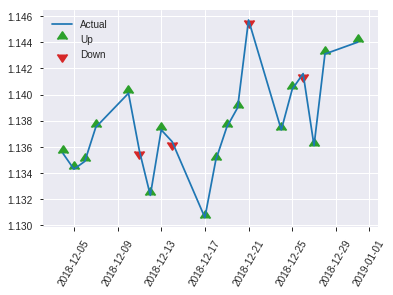


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1705868168828502
RMSE: 0.4130215695128406
LogLoss: 0.5107010287605567
Mean Per-Class Error: 0.24694525904203324
AUC: 0.8266739980449658
pr_auc: 0.8401037654187368
Gini: 0.6533479960899315
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4309595227241516: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      82   42   0.3387   (42.0/124.0)
1      22   110  0.1667   (22.0/132.0)
Total  104  152  0.25     (64.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43096      0.774648  151
max f2                       0.205684     0.869565  207
max f0point5                 0.514112     0.764331  123
max accuracy                 0.476263     0.753906  136
max precision                0.961059     1         0
max recall                   0.0585923    1         251
max specificity              0.961059     1         0
max absolute_mcc             0.476263     0.507117  136
max min_per_class_accuracy   0.497792     0.75      129
max mean_per_class_accuracy  0.476263     0.753055  136

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 49.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.935363           1.93939   1.93939            1                0.949865   1                           0.949865            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.924625           1.93939   1.93939            1                0.927174   1                           0.93852             0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.915292           1.93939   1.93939            1                0.916633   1                           0.933048            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.913061           1.93939   1.93939            1                0.914141   1                           0.927891            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.899919           1.93939   1.93939            1                0.912209   1                           0.925479            0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.861494           1.93939   1.93939            1                0.876705   1                           0.901092            0.0984848       0.19697                    93.9394   93.9394
    7        0.152344                    0.805138           1.93939   1.93939            1                0.835856   1                           0.879347            0.0984848       0.295455                   93.9394   93.9394
    8        0.203125                    0.773764           1.49184   1.82751            0.769231         0.787456   0.942308                    0.856374            0.0757576       0.371212                   49.1841   82.7506
    9        0.300781                    0.672367           1.08606   1.58678            0.56             0.723171   0.818182                    0.813126            0.106061        0.477273                   8.60606   58.6777
    10       0.402344                    0.584687           1.34266   1.52515            0.692308         0.631958   0.786408                    0.767395            0.136364        0.613636                   34.2657   52.5154
    11       0.5                         0.500923           1.24121   1.4697             0.64             0.540197   0.757812                    0.72302             0.121212        0.734848                   24.1212   46.9697
    12       0.601562                    0.417153           0.969697  1.38528            0.5              0.462098   0.714286                    0.678968            0.0984848       0.833333                   -3.0303   38.5281
    13       0.699219                    0.313465           0.698182  1.28932            0.36             0.371076   0.664804                    0.635967            0.0681818       0.901515                   -30.1818  28.9318
    14       0.800781                    0.209631           0.596737  1.20148            0.307692         0.262609   0.619512                    0.588614            0.0606061       0.962121                   -40.3263  20.1478
    15       0.898438                    0.130161           0.232727  1.09618            0.12             0.17478    0.565217                    0.543632            0.0227273       0.984848                   -76.7273  9.61792
    16       1                           0.0370966          0.149184  1                  0.0769231        0.0805821  0.515625                   

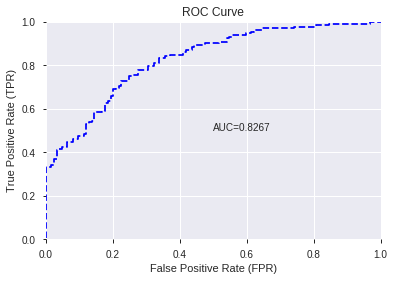

This function is available for GLM models only


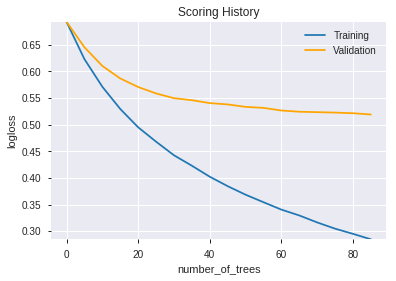

--2019-07-25 12:38:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_123632_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_123632_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_123813_model_8  0.825574  0.503531              0.273216  0.411487  0.169321
1  DeepLearning_grid_1_AutoML_20190725_123813_model_5  0.813630  0.527791              0.305474  0.423146  0.179052
2  DeepLearning_grid_1_AutoML_20190725_123813_model_4  0.804374  0.589950              0.299976  0.433346  0.187788
3  DeepLearning_grid_1_AutoML_20190725_123813_model_6  0.804069  0.508916              0.288612  0.416024  0.173076
4  DeepLearning_grid_1_AutoML_20190725_123813_model_9  0.798937  0.524968              0.296921  0.424602  0.180287
5  DeepLearning_grid_1_AutoML_20190725_123813_model_3  0.784335  0.541069              0.337488  0.431277  0.186000
6  DeepLearning_grid_1_AutoML_20190725_123813_model_2  0.776576  0.570091              0.289712  0.441561  0.194976
7  DeepLearning_grid_1_AutoML_20190725_123813_model_7  0.765090  0.626642              0.324413  0.457573  0.209373
8               DeepLearning_1_AutoML_20190725_123813  0.763807  0.578898              0.301442  0.447040  0.199845
9  DeepLearning_grid_1_AutoML_20190725_123813_model_1  0.748717  0.655387              0.372312  0.466637  0.217750

variable  relative_importance  scaled_importance  percentage
0       CDLRICKSHAWMAN             1.000000           1.000000    0.041067
1    CDLLONGLEGGEDDOJI             0.891361           0.891361    0.036606
2              CDLDOJI             0.888842           0.888842    0.036502
3                  DIV             0.799418           0.799418    0.032830
4                  SUB             0.792781           0.792781    0.032557
5         STOCHF_fastk             0.790341           0.790341    0.032457
6                CCI_8             0.721537           0.721537    0.029631
7               TRANGE             0.595930           0.595930    0.024473
8             WILLR_14             0.582846           0.582846    0.023936
9        days_in_month             0.551476           0.551476    0.022648
10            WILLR_12             0.543939           0.543939    0.022338
11             WILLR_8             0.541344           0.541344    0.022231
12  CDLCLOSINGMARUBOZU             0.536565           0.536565    0.022035
13   CDLGRAVESTONEDOJI             0.523642           0.523642    0.021504
14    CDLDRAGONFLYDOJI             0.493077           0.493077    0.020249
15            CORREL_8             0.486523           0.486523    0.019980
16      STOCHRSI_fastk             0.469518           0.469518    0.019282
17          aroonup_24             0.461173           0.461173    0.018939
18              ULTOSC             0.452334           0.452334    0.018576
19          PLUS_DI_14             0.449977           0.449977    0.018479
20                DX_8             0.445450           0.445450    0.018293
21          MINUS_DI_8             0.445050           0.445050    0.018277
22       CDLHANGINGMAN             0.440368           0.440368    0.018085
23         CDLBELTHOLD             0.439071           0.439071    0.018031
24        STOCHF_fastd             0.431083           0.431083    0.017703
25           CDLTAKURI             0.428960           0.428960    0.017616
26         STOCH_slowk             0.423224           0.423224    0.017381
27              CCI_12             0.410120           0.410120    0.016842
28           aroonup_8             0.407688           0.407688    0.016743
29           PLUS_DI_8             0.403840           0.403840    0.016585
30              CCI_20             0.399427           0.399427    0.016403
31          PLUS_DM_12             0.398007           0.398007    0.016345
32           PLUS_DM_8             0.395055           0.395055    0.016224
33      is_month_start             0.390458           0.390458    0.016035
34   CDLINVERTEDHAMMER             0.387759           0.387759    0.015924
35          PLUS_DI_12             0.384135           0.384135    0.015775
36         MINUS_DM_12             0.384037           0.384037    0.015771
37          aroonup_12             0.383957           0.383957    0.015768
38         MINUS_DI_12             0.383151           0.383151    0.015735
39              CCI_14             0.382554           0.382554    0.015710
40         AROONOSC_12             0.382094           0.382094    0.015692
41              CCI_30             0.378820           0.378820    0.015557
42          CDLHIKKAKE             0.375668           0.375668    0.015428
43          PLUS_DM_14             0.371793           0.371793    0.015268
44         MINUS_DI_14             0.371609           0.371609    0.015261
45     CDLSHOOTINGSTAR             0.364967           0.364967    0.014988
46              CCI_24             0.358977           0.358977    0.014742
47        is_month_end             0.344970           0.344970    0.014167
48          MINUS_DM_8             0.342424           0.342424    0.014062
49           CDLHAMMER             0.323055           0.323055    0.013267

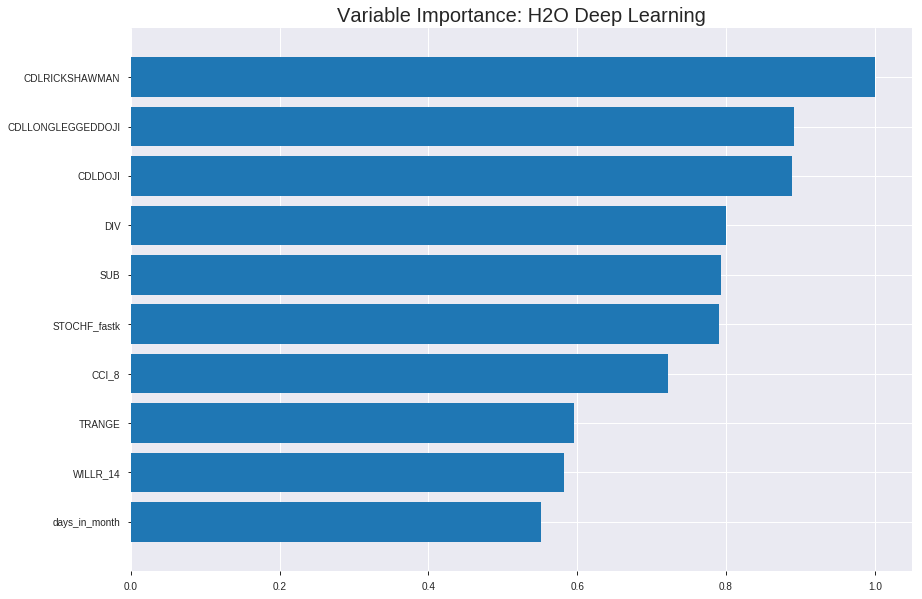

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_123813_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16550870182838073
RMSE: 0.40682760701356135
LogLoss: 0.486980328387366
Mean Per-Class Error: 0.2807243107769424
AUC: 0.8230363408521303
pr_auc: 0.840688590034717
Gini: 0.6460726817042606
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36665221700577927: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      393  482   0.5509   (482.0/875.0)
1      38   874   0.0417   (38.0/912.0)
Total  431  1356  0.291    (520.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.366652     0.770723  264
max f2                       0.196868     0.882643  305
max f0point5                 0.534791     0.757846  180
max accuracy                 0.49531      0.722999  215
max precision                0.996916     1         0
max recall                   0.00430852   1         397
max specificity              0.996916     1         0
max absolute_mcc             0.321017     0.476864  273
max min_per_class_accuracy   0.503836     0.590857  205
max mean_per_class_accuracy  0.49531      0.719276  215

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 48.32 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.981132           1.95943    1.95943            1                0.987639   1                           0.987639            0.0197368       0.0197368                  95.943    95.943
    2        0.0201455                   0.975662           1.95943    1.95943            1                0.97772    1                           0.982679            0.0197368       0.0394737                  95.943    95.943
    3        0.0302182                   0.970454           1.95943    1.95943            1                0.973784   1                           0.979714            0.0197368       0.0592105                  95.943    95.943
    4        0.040291                    0.963416           1.95943    1.95943            1                0.966167   1                           0.976327            0.0197368       0.0789474                  95.943    95.943
    5        0.0503637                   0.958552           1.85057    1.93766            0.944444         0.960571   0.988889                    0.973176            0.0186404       0.0975877                  85.0573   93.7658
    6        0.100168                    0.912552           1.9154     1.92659            0.977528         0.93834    0.98324                     0.955855            0.0953947       0.192982                   91.5398   92.659
    7        0.149972                    0.841282           1.84935    1.90094            0.94382          0.880508   0.970149                    0.930833            0.0921053       0.285088                   84.9349   90.0939
    8        0.200336                    0.707262           1.65463    1.83902            0.844444         0.782017   0.938547                    0.893421            0.0833333       0.368421                   65.463    83.9018
    9        0.299944                    0.516175           1.30996    1.66332            0.668539         0.5684     0.848881                    0.785485            0.130482        0.498904                   30.9956   66.3322
    10       0.62563                     0.503836           1.03695    1.33725            0.52921          0.504504   0.682469                    0.639214            0.337719        0.836623                   3.69491   33.725
    11       0.700056                    0.487763           1.01655    1.30315            0.518797         0.498591   0.665068                    0.624264            0.0756579       0.912281                   1.65463   30.3154
    12       0.799664                    0.183742           0.693506   1.22721            0.353933         0.373554   0.626312                    0.593035            0.0690789       0.98136                    -30.6494  22.7215
    13       0.899832                    0.0289517          0.142305   1.10644            0.0726257        0.0769473  0.564677                    0.535585            0.0142544       0.995614                   -85.7695  10.6444
    14       1                           0.00212109         0.0437861  1                  0.0223464        0.0123775  0.510353                    0.483176            0.00438596      1                          -95.6214  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.16802289568685355
RMSE: 0.4099059595649392
LogLoss: 0.5202412155996514
Mean Per-Class Error: 0.2548798798798799
AUC: 0.831624992339278
pr_auc: 0.8101882755164487
Gini: 0.663249984678556
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45998728598207056: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      144  115  0.444    (115.0/259.0)
1      22   230  0.0873   (22.0/252.0)
Total  166  345  0.2681   (137.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459987     0.770519  241
max f2                       0.266673     0.862816  273
max f0point5                 0.523978     0.777311  169
max accuracy                 0.50497      0.745597  194
max precision                0.921689     0.943396  50
max recall                   0.00635009   1         394
max specificity              0.990822     0.996139  0
max absolute_mcc             0.523978     0.508929  169
max min_per_class_accuracy   0.503914     0.654762  199
max mean_per_class_accuracy  0.50205      0.74512   207

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 48.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.974526           1.68981   1.68981            0.833333         0.983119   0.833333                    0.983119            0.0198413       0.0198413                  68.9815   68.9815
    2        0.0215264                   0.967092           2.02778   1.84343            1                0.97145    0.909091                    0.977815            0.0198413       0.0396825                  102.778   84.3434
    3        0.0313112                   0.962986           1.62222   1.77431            0.8              0.964379   0.875                       0.973616            0.015873        0.0555556                  62.2222   77.4306
    4        0.0410959                   0.959072           2.02778   1.83466            1                0.961295   0.904762                    0.970683            0.0198413       0.0753968                  102.778   83.4656
    5        0.0508806                   0.952984           2.02778   1.87179            1                0.955596   0.923077                    0.967781            0.0198413       0.0952381                  102.778   87.1795
    6        0.101761                    0.922791           1.94979   1.91079            0.961538         0.938878   0.942308                    0.95333             0.0992063       0.194444                   94.9786   91.0791
    7        0.150685                    0.887462           1.54111   1.79076            0.76             0.90691    0.883117                    0.938258            0.0753968       0.269841                   54.1111   79.0765
    8        0.201566                    0.822786           1.87179   1.81122            0.923077         0.859251   0.893204                    0.918315            0.0952381       0.365079                   87.1795   81.1219
    9        0.30137                     0.576922           1.66993   1.76443            0.823529         0.708249   0.87013                     0.848748            0.166667        0.531746                   66.9935   76.443
    10       0.401174                    0.504522           1.11329   1.60244            0.54902          0.524126   0.790244                    0.767988            0.111111        0.642857                   11.329    60.2439
    11       0.587084                    0.503836           1.00322   1.41269            0.494737         0.503857   0.696667                    0.684347            0.186508        0.829365                   0.321637  41.2685
    12       0.600783                    0.502224           1.15873   1.40689            0.571429         0.502836   0.693811                    0.680208            0.015873        0.845238                   15.873    40.6895
    13       0.700587                    0.408856           0.755447  1.31409            0.372549         0.475374   0.648045                    0.651028            0.0753968       0.920635                   -24.4553  31.4091
    14       0.800391                    0.117047           0.437364  1.20477            0.215686         0.242692   0.594132                    0.600111            0.0436508       0.964286                   -56.2636  20.4768
    15       0.900196                    0.0260036          0.198802  1.09324            0.0980392        0.0649873  0.53913                     0.540782            0.0198413       0.984127                   -80.1198  9.32367
    16       1                           0.00175666         0.159041  1                  0.0784314        0.0137288  0.493151                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 12:44:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 12:44:05  1 min 29.026 sec  603 obs/sec       0.520425  1             930        0.626777         1.36092             -0.572074      0.746842        0.733891           1.63286          0.334639                         0.635688           1.32435               -0.616703        0.793023          0.797888             2.02778            0.338552
    2019-07-25 12:44:15  1 min 39.959 sec  977 obs/sec       6.26301   12            11192      0.433966         0.552928            0.246372       0.806397        0.806423           1.85057          0.29211                          0.426923           0.541673              0.27081          0.819314          0.821398             2.02778            0.299413
    2019-07-25 12:44:26  1 min 50.780 sec  1106 obs/sec      13.1511   25            23501      0.417618         0.512464            0.302083       0.811232        0.819592           1.95943          0.29211                          0.419594           0.53403               0.295632         0.808421          0.794933             1.68981            0.30137
    2019-07-25 12:44:37  2 min  1.588 sec  1182 obs/sec      20.5288   39            36685      0.414227         0.507576            0.313369       0.818154        0.829902           1.95943          0.288752                         0.418709           0.53082               0.298601         0.819843          0.803771             1.68981            0.299413
    2019-07-25 12:44:48  2 min 12.171 sec  1230 obs/sec      27.9664   53            49976      0.406828         0.48698             0.337681       0.823036        0.840689           1.95943          0.29099                          0.409906           0.520241              0.327782         0.831625          0.810188             1.68981            0.268102
    2019-07-25 12:44:58  2 min 22.255 sec  1285 obs/sec      35.7437   68            63874      0.402711         0.47692             0.351016       0.831727        0.841288           1.95943          0.271405                         0.415291           0.557003              0.310004         0.822401          0.774215             0.675926           0.262231
    2019-07-25 12:45:08  2 min 32.677 sec  1318 obs/sec      43.601    83            77915      0.398087         0.464526            0.365836       0.834378        0.846755           1.95943          0.27756                          0.423257           0.573145              0.283278         0.809531          0.782725             2.02778            0.30137
    2019-07-25 12:45:09  2 min 33.740 sec  1317 obs/sec      43.601    83            77915      0.406828         0.48698             0.337681       0.823036        0.840689           1.95943          0.29099                          0.409906           0.520241              0.327782         0.831625          0.810188             1.68981            0.268102

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLRICKSHAWMAN     1.0                    1.0                  0.04106709191688075
CDLLONGLEGGEDDOJI  0.8913607597351074     0.8913607597351074   0.036605594251142314
CDLDOJI            0.8888420462608337     0.8888420462608337   0.03650215801338203
DIV                0.7994180917739868     0.7994180917739868   0.03282977625489973
SUB                0.792781412601471      0.792781412601471    0.032557227141299175
---                ---                    ---                  ---
CDLSHOOTINGSTAR    0.3649667501449585     0.3649667501449585   0.014988123074808263
CCI_24             0.3589766025543213     0.3589766025543213   0.014742125133107882
is_month_end       0.3449696898460388     0.3449696898460388   0.01416690196144512
MINUS_DM_8         0.34242352843284607    0.34242352843284607  0.014062338516654319
CDLHAMMER          0.3230551481246948     0.3230551481246948   0.01326693546225837


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.74609375)

('F1', 0.7901234567901234)

('auc', 0.8255742913000977)

('logloss', 0.5035306082466937)

('mean_per_class_error', 0.25427663734115347)

('rmse', 0.41148686517602445)

('mse', 0.1693214402123917)

deeplearning prediction progress: |███████████████████████████████████████| 100%


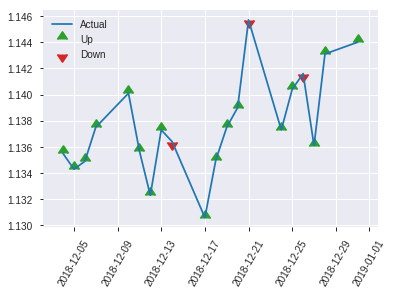


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1693214402123917
RMSE: 0.41148686517602445
LogLoss: 0.5035306082466937
Mean Per-Class Error: 0.25427663734115347
AUC: 0.8255742913000977
pr_auc: 0.8320467268642521
Gini: 0.6511485826001955
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26086267236027677: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   64   0.5161   (64.0/124.0)
1      4    128  0.0303   (4.0/132.0)
Total  64   192  0.2656   (68.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.260863     0.790123  149
max f2                       0.260863     0.888889  149
max f0point5                 0.503836     0.753012  90
max accuracy                 0.503836     0.746094  90
max precision                0.980636     1         0
max recall                   0.0120444    1         208
max specificity              0.980636     1         0
max absolute_mcc             0.260863     0.523479  149
max min_per_class_accuracy   0.503836     0.733871  90
max mean_per_class_accuracy  0.503836     0.745723  90

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 46.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.975179           1.93939    1.93939            1                0.978867   1                           0.978867            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.963233           1.93939    1.93939            1                0.967972   1                           0.973419            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.959938           1.93939    1.93939            1                0.960255   1                           0.970128            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.942261           1.93939    1.93939            1                0.948602   1                           0.964257            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.934374           0.969697   1.79021            0.5              0.938529   0.923077                    0.960299            0.00757576      0.0909091                  -3.0303   79.021
    6        0.101562                    0.892455           1.93939    1.8648             1                0.915778   0.961538                    0.938038            0.0984848       0.189394                   93.9394   86.4802
    7        0.152344                    0.81591            1.93939    1.88967            1                0.850333   0.974359                    0.908803            0.0984848       0.287879                   93.9394   88.9666
    8        0.203125                    0.651845           1.64103    1.82751            0.846154         0.751287   0.942308                    0.869424            0.0833333       0.371212                   64.1026   82.7506
    9        0.300781                    0.513767           1.31879    1.66234            0.68             0.562632   0.857143                    0.769816            0.128788        0.5                        31.8788   66.2338
    10       0.519531                    0.503836           1.17749    1.45819            0.607143         0.504916   0.75188                     0.658279            0.257576        0.757576                   17.7489   45.8191
    11       0.601562                    0.49983            0.554113   1.33491            0.285714         0.501868   0.688312                    0.63695             0.0454545       0.80303                    -44.5887  33.4908
    12       0.699219                    0.401709           1.00848    1.28932            0.52             0.472483   0.664804                    0.61398             0.0984848       0.901515                   0.848485  28.9318
    13       0.800781                    0.136154           0.745921   1.2204             0.384615         0.253805   0.629268                    0.568299            0.0757576       0.977273                   -25.4079  22.0399
    14       0.898438                    0.0303145          0.0775758  1.09618            0.04             0.0724253  0.565217                    0.5144              0.00757576      0.984848                   -92.2424  9.61792
    15       1                           0.00603164         0.149184   1                  0.0769231        0.0188377  0.515625                    0.464069            0.0151515       1                          -85.0816  0

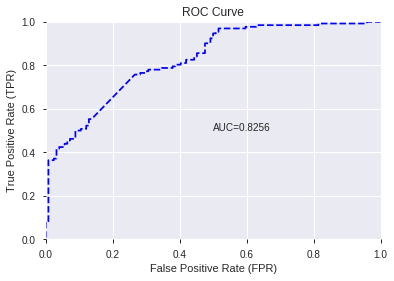

This function is available for GLM models only


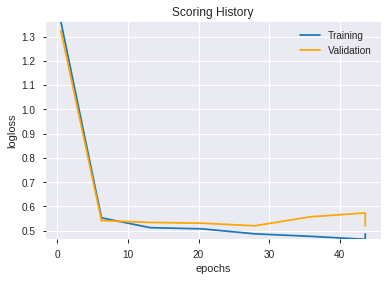

--2019-07-25 12:46:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_123813_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_123813_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'DIV',
 'SUB',
 'STOCHF_fastk',
 'CCI_8',
 'TRANGE',
 'WILLR_14',
 'days_in_month',
 'WILLR_12',
 'WILLR_8',
 'CDLCLOSINGMARUBOZU',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CORREL_8',
 'STOCHRSI_fastk',
 'aroonup_24',
 'ULTOSC',
 'PLUS_DI_14',
 'DX_8',
 'MINUS_DI_8',
 'CDLHANGINGMAN',
 'CDLBELTHOLD',
 'STOCHF_fastd',
 'CDLTAKURI',
 'STOCH_slowk',
 'CCI_12',
 'aroonup_8',
 'PLUS_DI_8',
 'CCI_20',
 'PLUS_DM_12',
 'PLUS_DM_8',
 'is_month_start',
 'CDLINVERTEDHAMMER',
 'PLUS_DI_12',
 'MINUS_DM_12',
 'aroonup_12',
 'MINUS_DI_12',
 'CCI_14',
 'AROONOSC_12',
 'CCI_30',
 'CDLHIKKAKE',
 'PLUS_DM_14',
 'MINUS_DI_14',
 'CDLSHOOTINGSTAR',
 'CCI_24',
 'is_month_end',
 'MINUS_DM_8',
 'CDLHAMMER']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_124652_model_1  0.816777  0.512395              0.283602  0.416802  0.173724

variable  relative_importance  scaled_importance  percentage
0          MINUS_DI_12             2.859960           1.000000    0.111356
1           PLUS_DI_12             2.584125           0.903553    0.100616
2           PLUS_DM_12             1.850738           0.647120    0.072061
3           PLUS_DM_14             1.819879           0.636330    0.070859
4          MINUS_DI_14             1.711853           0.598558    0.066653
5            PLUS_DI_8             1.618568           0.565941    0.063021
6           MINUS_DI_8             1.353562           0.473280    0.052702
7           PLUS_DI_14             1.275880           0.446118    0.049678
8               CCI_14             1.275505           0.445987    0.049663
9                CCI_8             1.088855           0.380724    0.042396
10              CCI_12             1.039739           0.363550    0.040483
11            WILLR_14             0.908213           0.317561    0.035362
12    CDLDRAGONFLYDOJI             0.853472           0.298421    0.033231
13        STOCHF_fastk             0.846031           0.295819    0.032941
14                 DIV             0.622604           0.217697    0.024242
15   CDLGRAVESTONEDOJI             0.551043           0.192675    0.021455
16              CCI_30             0.475668           0.166320    0.018521
17           CDLTAKURI             0.284762           0.099569    0.011088
18         MINUS_DM_12             0.251738           0.088021    0.009802
19             WILLR_8             0.251501           0.087939    0.009792
20                 SUB             0.251441           0.087918    0.009790
21       CDLHANGINGMAN             0.145264           0.050792    0.005656
22          aroonup_12             0.144313           0.050460    0.005619
23      STOCHRSI_fastk             0.119274           0.041705    0.004644
24   CDLINVERTEDHAMMER             0.118053           0.041278    0.004597
25              TRANGE             0.115340           0.040329    0.004491
26            WILLR_12             0.112034           0.039173    0.004362
27     CDLSHOOTINGSTAR             0.103656           0.036244    0.004036
28                DX_8             0.085112           0.029760    0.003314
29              CCI_24             0.084831           0.029662    0.003303
30         AROONOSC_12             0.081335           0.028439    0.003167
31         CDLBELTHOLD             0.077729           0.027178    0.003026
32              CCI_20             0.077285           0.027023    0.003009
33          MINUS_DM_8             0.075291           0.026326    0.002932
34           CDLHAMMER             0.068356           0.023901    0.002662
35              ULTOSC             0.066725           0.023331    0.002598
36            CORREL_8             0.060221           0.021057    0.002345
37      is_month_start             0.049616           0.017349    0.001932
38          aroonup_24             0.048914           0.017103    0.001905
39             CDLDOJI             0.046854           0.016383    0.001824
40      CDLRICKSHAWMAN             0.042579           0.014888    0.001658
41         STOCH_slowk             0.040209           0.014059    0.001566
42       days_in_month             0.030331           0.010606    0.001181
43           aroonup_8             0.024492           0.008564    0.000954
44        STOCHF_fastd             0.023662           0.008274    0.000921
45           PLUS_DM_8             0.022650           0.007920    0.000882
46   CDLLONGLEGGEDDOJI             0.022466           0.007855    0.000875
47          CDLHIKKAKE             0.008974           0.003138    0.000349
48  CDLCLOSINGMARUBOZU             0.007655           0.002676    0.000298
49        is_month_end             0.004747           0.001660    0.000185

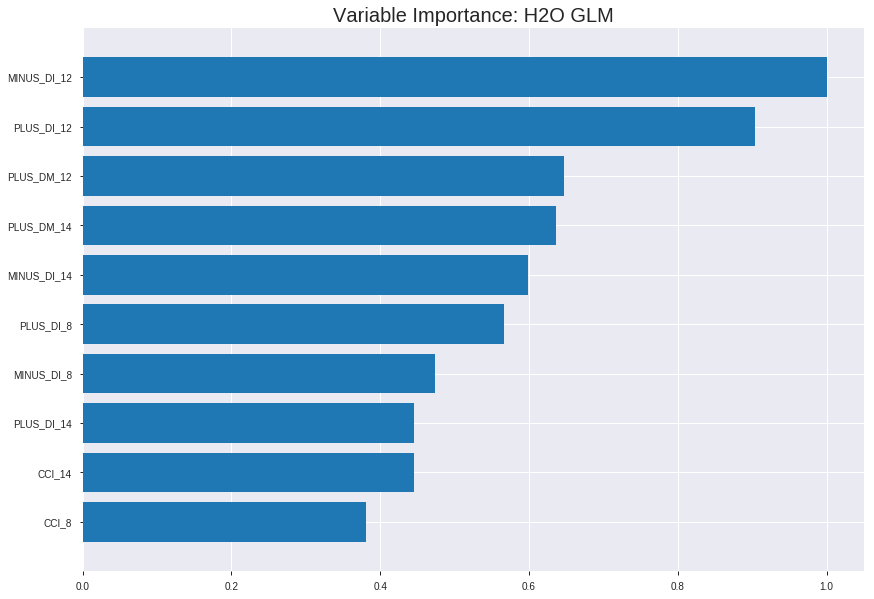

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_124652_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1795471860633264
RMSE: 0.4237300863324746
LogLoss: 0.5339952034598132
Null degrees of freedom: 1786
Residual degrees of freedom: 1736
Null deviance: 2476.5418801583887
Residual deviance: 1908.4988571653726
AIC: 2010.4988571653726
AUC: 0.8052850877192983
pr_auc: 0.8020652175274673
Gini: 0.6105701754385966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4411604518140086: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      541  334   0.3817   (334.0/875.0)
1      145  767   0.159    (145.0/912.0)
Total  686  1101  0.268    (479.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44116      0.762047  235
max f2                       0.221758     0.865385  320
max f0point5                 0.614293     0.732223  149
max accuracy                 0.44116      0.731953  235
max precision                0.997115     1         0
max recall                   0.00686317   1         398
max specificity              0.997115     1         0
max absolute_mcc             0.44116      0.472103  235
max min_per_class_accuracy   0.519963     0.712719  196
max mean_per_class_accuracy  0.44116      0.729647  235

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 51.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.976552           1.95943   1.95943            1                0.987316  1                           0.987316            0.0197368       0.0197368                  95.943    95.943
    2        0.0201455                   0.963783           1.85057   1.905              0.944444         0.970423  0.972222                    0.97887             0.0186404       0.0383772                  85.0573   90.5001
    3        0.0302182                   0.954403           1.85057   1.88686            0.944444         0.958997  0.962963                    0.972245            0.0186404       0.0570175                  85.0573   88.6858
    4        0.040291                    0.944692           1.85057   1.87779            0.944444         0.950237  0.958333                    0.966743            0.0186404       0.0756579                  85.0573   87.7787
    5        0.0503637                   0.934126           1.95943   1.89412            1                0.938618  0.966667                    0.961118            0.0197368       0.0953947                  95.943    89.4115
    6        0.100168                    0.882808           1.71725   1.80618            0.876404         0.908525  0.921788                    0.934968            0.0855263       0.180921                   71.7253   80.6178
    7        0.149972                    0.801313           1.60717   1.74009            0.820225         0.842049  0.88806                     0.904111            0.0800439       0.260965                   60.7173   74.0091
    8        0.200336                    0.74071            1.56754   1.69671            0.8              0.77252   0.865922                    0.871029            0.0789474       0.339912                   56.7544   69.6713
    9        0.299944                    0.657696           1.42004   1.60483            0.724719         0.696148  0.81903                     0.812953            0.141447        0.48136                    42.0036   60.4832
    10       0.400112                    0.590289           1.14939   1.49081            0.586592         0.624604  0.760839                    0.7658              0.115132        0.596491                   14.9386   49.0811
    11       0.50028                     0.521581           1.11655   1.41587            0.569832         0.55854   0.722595                    0.724301            0.111842        0.708333                   11.6547   41.5874
    12       0.599888                    0.449737           1.13383   1.36904            0.578652         0.486789  0.698694                    0.684864            0.112939        0.821272                   13.3827   36.9042
    13       0.700056                    0.377236           0.766257  1.28279            0.391061         0.415754  0.654676                    0.646358            0.0767544       0.898026                   -23.3743  28.2792
    14       0.799664                    0.285609           0.594434  1.19705            0.303371         0.335387  0.610917                    0.607623            0.0592105       0.957237                   -40.5566  19.7048
    15       0.899832                    0.101464           0.295556  1.0967             0.150838         0.19748   0.559701                    0.561966            0.0296053       0.986842                   -70.4444  9.66958
    16       1                           0.00254185         0.131358  1                  0.0670391        0.046694  0.510353                    0.510352          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17333794794127239
RMSE: 0.41633874182121505
LogLoss: 0.5194492308995969
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 708.9054443622276
Residual deviance: 530.877113979388
AIC: 632.877113979388
AUC: 0.8255423791138078
pr_auc: 0.8208135802482674
Gini: 0.6510847582276156
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.518161166459733: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      181  78   0.3012   (78.0/259.0)
1      48   204  0.1905   (48.0/252.0)
Total  229  282  0.2466   (126.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518161     0.764045  211
max f2                       0.258273     0.859046  320
max f0point5                 0.745796     0.75495   104
max accuracy                 0.544969     0.757339  197
max precision                0.998938     1         0
max recall                   0.0290687    1         387
max specificity              0.998938     1         0
max absolute_mcc             0.544969     0.515047  197
max min_per_class_accuracy   0.553541     0.752896  192
max mean_per_class_accuracy  0.544969     0.757508  197

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 53.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.98328            2.02778   2.02778            1                0.99032    1                           0.99032             0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.981119           2.02778   2.02778            1                0.981858   1                           0.986474            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.972683           2.02778   2.02778            1                0.976517   1                           0.983362            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.958719           1.62222   1.93122            0.8              0.967545   0.952381                    0.979596            0.015873        0.0793651                  62.2222   93.1217
    5        0.0508806                   0.951644           2.02778   1.94979            1                0.955427   0.961538                    0.974948            0.0198413       0.0992063                  102.778   94.9786
    6        0.101761                    0.920379           1.87179   1.91079            0.923077         0.934822   0.942308                    0.954885            0.0952381       0.194444                   87.1795   91.0791
    7        0.150685                    0.868451           1.86556   1.8961             0.92             0.8911     0.935065                    0.934176            0.0912698       0.285714                   86.5556   89.6104
    8        0.201566                    0.819999           1.48184   1.79153            0.730769         0.845272   0.883495                    0.911734            0.0753968       0.361111                   48.1838   79.1532
    9        0.30137                     0.709849           1.51089   1.69859            0.745098         0.767354   0.837662                    0.86392             0.150794        0.511905                   51.0893   69.8593
    10       0.401174                    0.614478           1.23257   1.58266            0.607843         0.659364   0.780488                    0.813031            0.123016        0.634921                   23.2571   58.2656
    11       0.500978                    0.550654           1.23257   1.51291            0.607843         0.58266    0.746094                    0.767137            0.123016        0.757937                   23.2571   51.2912
    12       0.600783                    0.475502           0.795207  1.39368            0.392157         0.515852   0.687296                    0.725392            0.0793651       0.837302                   -20.4793  39.3684
    13       0.700587                    0.382768           0.675926  1.29143            0.333333         0.435491   0.636872                    0.684093            0.0674603       0.904762                   -32.4074  29.1434
    14       0.800391                    0.273263           0.516885  1.19485            0.254902         0.327954   0.589242                    0.639685            0.0515873       0.956349                   -48.3115  19.4852
    15       0.900196                    0.110254           0.238562  1.08883            0.117647         0.191291   0.536957                    0.589972            0.0238095       0.980159                   -76.1438  8.88285
    16       1                           0.00189558         0.198802  1                  0.0980392        0.0539302  0.493151                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 12:46:53  0.000 sec   2            .16E2     51            1.3677030722695824  1.3676162339405897
     2019-07-25 12:46:53  0.014 sec   4            .99E1     51            1.3578752489413084  1.3568542083670792
     2019-07-25 12:46:53  0.028 sec   6            .61E1     51            1.3437023215040778  1.34121914375254
     2019-07-25 12:46:53  0.042 sec   8            .38E1     51            1.3243032320232584  1.3196279674300642
     2019-07-25 12:46:53  0.056 sec   10           .24E1     51            1.2995770887892024  1.291816592117981
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 12:46:53  0.411 sec   50           .11E-3    51            1.0693016621257732  1.0417436069389727
     2019-07-25 12:46:53  0.419 sec   51           .66E-4    51            1.0690501462089683  1.0413811284927679
     2019-07-25 12:46:53  0.435 sec   53           .41E-4    51            1.0685598207312021  1.0403702617161072
     2019-07-25 12:46:53  0.445 sec   54           .26E-4    51            1.0683553505499566  1.0398996177454198
     2019-07-25 12:46:53  0.460 sec   56           .16E-4    51            1.0679904069196267  1.0388984617991939


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.73828125)

('F1', 0.7731629392971247)

('auc', 0.8167766373411535)

('logloss', 0.512394502107961)

('mean_per_class_error', 0.2596529814271751)

('rmse', 0.41680246000037724)

('mse', 0.17372429066236605)

glm prediction progress: |████████████████████████████████████████████████| 100%


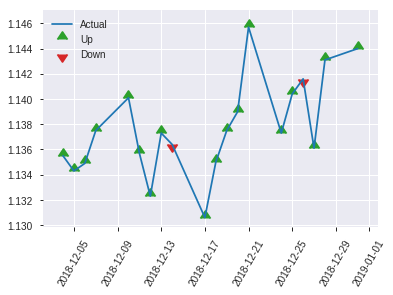


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.17372429066236605
RMSE: 0.41680246000037724
LogLoss: 0.512394502107961
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.6697985653149
Residual deviance: 262.345985079276
AIC: 364.345985079276
AUC: 0.8167766373411535
pr_auc: 0.8283132445405279
Gini: 0.6335532746823069
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3693715665946212: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   60   0.4839   (60.0/124.0)
1      11   121  0.0833   (11.0/132.0)
Total  75   181  0.2773   (71.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369372     0.773163  180
max f2                       0.192641     0.87217   222
max f0point5                 0.559041     0.762868  102
max accuracy                 0.539596     0.738281  112
max precision                0.985056     1         0
max recall                   0.0488849    1         243
max specificity              0.985056     1         0
max absolute_mcc             0.539596     0.483793  112
max min_per_class_accuracy   0.514304     0.727273  128
max mean_per_class_accuracy  0.539596     0.740347  112

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 50.13 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.972704           1.93939    1.93939            1                0.979363   1                           0.979363            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.957168           1.93939    1.93939            1                0.962924   1                           0.971144            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.954064           1.93939    1.93939            1                0.955042   1                           0.967118            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.951908           1.93939    1.93939            1                0.953073   1                           0.963288            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.937942           1.93939    1.93939            1                0.945859   1                           0.960606            0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.850153           1.93939    1.93939            1                0.910051   1                           0.935329            0.0984848       0.19697                    93.9394   93.9394
    7        0.152344                    0.78002            1.79021    1.88967            0.923077         0.814146   0.974359                    0.894935            0.0909091       0.287879                   79.021    88.9666
    8        0.203125                    0.736286           1.49184    1.79021            0.769231         0.752901   0.923077                    0.859426            0.0757576       0.363636                   49.1841   79.021
    9        0.300781                    0.638418           1.24121    1.61196            0.64             0.68485    0.831169                    0.802746            0.121212        0.484848                   24.1212   61.1964
    10       0.402344                    0.559041           1.41725    1.56281            0.730769         0.600445   0.805825                    0.751679            0.143939        0.628788                   41.7249   56.2813
    11       0.5                         0.514815           0.930909   1.43939            0.48             0.535188   0.742188                    0.709396            0.0909091       0.719697                   -6.90909  43.9394
    12       0.601562                    0.447333           0.895105   1.3475             0.461538         0.476077   0.694805                    0.670004            0.0909091       0.810606                   -10.4895  34.7501
    13       0.699219                    0.37324            0.930909   1.28932            0.48             0.405692   0.664804                    0.633089            0.0909091       0.901515                   -6.90909  28.9318
    14       0.800781                    0.272271           0.522145   1.19202            0.269231         0.318203   0.614634                    0.593152            0.0530303       0.954545                   -47.7855  19.2018
    15       0.898438                    0.148105           0.387879   1.10461            0.2              0.213044   0.569565                    0.551836            0.0378788       0.992424                   -61.2121  10.4611
    16       1                           0.015842           0.0745921  1                  0.0384615        0.0543859  0.515625  

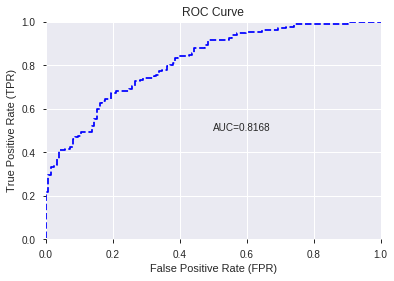

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


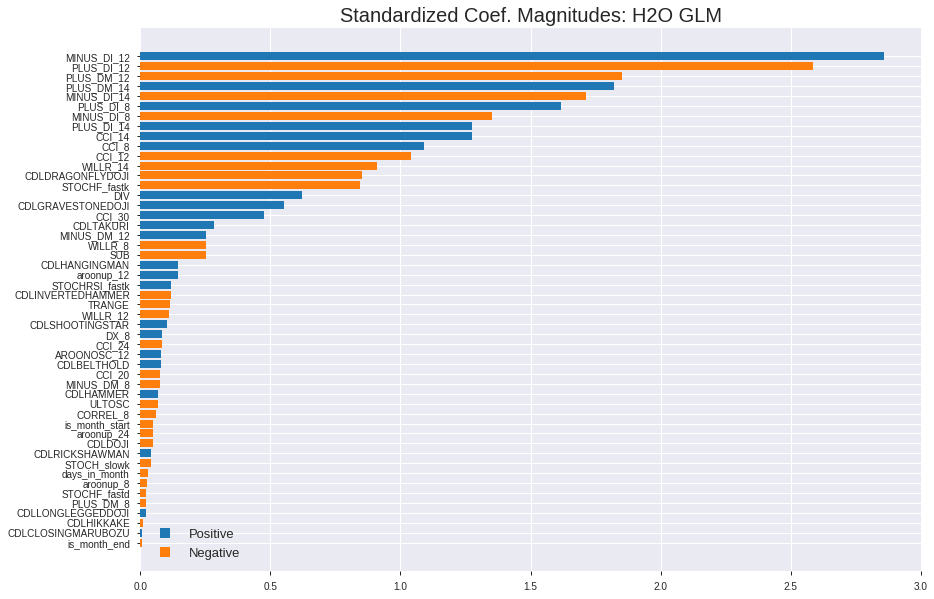

'log_likelihood'
--2019-07-25 12:46:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_124652_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_124652_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['MINUS_DI_12',
 'PLUS_DI_12',
 'PLUS_DM_12',
 'PLUS_DM_14',
 'MINUS_DI_14',
 'PLUS_DI_8',
 'MINUS_DI_8',
 'PLUS_DI_14',
 'CCI_14',
 'CCI_8',
 'CCI_12',
 'WILLR_14',
 'CDLDRAGONFLYDOJI',
 'STOCHF_fastk',
 'DIV',
 'CDLGRAVESTONEDOJI',
 'CCI_30',
 'CDLTAKURI',
 'MINUS_DM_12',
 'WILLR_8',
 'SUB',
 'CDLHANGINGMAN',
 'aroonup_12',
 'STOCHRSI_fastk',
 'CDLINVERTEDHAMMER',
 'TRANGE',
 'WILLR_12',
 'CDLSHOOTINGSTAR',
 'DX_8',
 'CCI_24',
 'AROONOSC_12',
 'CDLBELTHOLD',
 'CCI_20',
 'MINUS_DM_8',
 'CDLHAMMER',
 'ULTOSC',
 'CORREL_8',
 'is_month_start',
 'aroonup_24',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'STOCH_slowk',
 'days_in_month',
 'aroonup_8',
 'STOCHF_fastd',
 'PLUS_DM_8',
 'CDLLONGLEGGEDDOJI',
 'CDLHIKKAKE',
 'CDLCLOSINGMARUBOZU',
 'is_month_end']

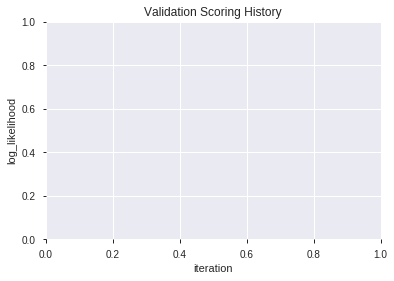

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_124708_model_7  0.822153  0.510922              0.275049  0.414429  0.171751
1  XGBoost_grid_1_AutoML_20190725_124708_model_3  0.820137  0.513624              0.278348  0.415713  0.172818
2               XGBoost_1_AutoML_20190725_124708  0.819404  0.516548              0.304497  0.416963  0.173858
3  XGBoost_grid_1_AutoML_20190725_124708_model_6  0.818426  0.513233              0.296432  0.416730  0.173664
4               XGBoost_2_AutoML_20190725_124708  0.816716  0.518278              0.300464  0.417873  0.174618
5  XGBoost_grid_1_AutoML_20190725_124708_model_2  0.812622  0.521941              0.288123  0.419974  0.176378
6  XGBoost_grid_1_AutoML_20190725_124708_model_4  0.811034  0.530740              0.296676  0.422614  0.178603
7               XGBoost_3_AutoML_20190725_124708  0.803519  0.524905              0.295943  0.421989  0.178075
8  XGBoost_grid_1_AutoML_20190725_124708_model_1  0.798631  0.532868              0.302786  0.425322  0.180899
9  XGBoost_grid_1_AutoML_20190725_124708_model_5  0.786901  0.555213              0.318671  0.437162  0.191111

variable  relative_importance  scaled_importance  percentage
0     CDLDRAGONFLYDOJI           842.361267           1.000000    0.077262
1    CDLGRAVESTONEDOJI           662.041687           0.785936    0.060723
2         STOCHF_fastk           604.733154           0.717902    0.055467
3                CCI_8           507.875977           0.602919    0.046583
4              WILLR_8           494.351715           0.586864    0.045342
5             WILLR_12           475.137421           0.564054    0.043580
6            CDLTAKURI           466.228058           0.553478    0.042763
7           MINUS_DI_8           451.367218           0.535836    0.041400
8               ULTOSC           374.781219           0.444917    0.034375
9          STOCH_slowk           333.834534           0.396308    0.030620
10              CCI_14           316.817932           0.376107    0.029059
11            WILLR_14           311.116058           0.369338    0.028536
12              TRANGE           303.593292           0.360407    0.027846
13            CORREL_8           293.732849           0.348702    0.026941
14           PLUS_DM_8           287.642670           0.341472    0.026383
15                DX_8           284.845612           0.338151    0.026126
16              CCI_12           279.360443           0.331640    0.025623
17                 DIV           261.403381           0.310322    0.023976
18          MINUS_DM_8           239.066696           0.283805    0.021927
19           PLUS_DI_8           235.684525           0.279790    0.021617
20                 SUB           232.004898           0.275422    0.021280
21              CCI_30           200.313629           0.237800    0.018373
22         MINUS_DM_12           200.069855           0.237511    0.018351
23          PLUS_DI_14           192.563217           0.228599    0.017662
24         MINUS_DI_14           182.312805           0.216431    0.016722
25              CCI_24           173.089905           0.205482    0.015876
26          aroonup_24           169.702408           0.201460    0.015565
27          PLUS_DI_12           169.594894           0.201333    0.015555
28          PLUS_DM_12           168.312302           0.199810    0.015438
29              CCI_20           167.437302           0.198771    0.015358
30           aroonup_8           165.678848           0.196684    0.015196
31          aroonup_12           158.509903           0.188173    0.014539
32      STOCHRSI_fastk           139.002335           0.165015    0.012749
33          PLUS_DM_14           120.932320           0.143563    0.011092
34         MINUS_DI_12           106.069290           0.125919    0.009729
35       days_in_month           100.506660           0.119315    0.009219
36         AROONOSC_12            95.141663           0.112946    0.008726
37        STOCHF_fastd            64.446480           0.076507    0.005911
38      CDLRICKSHAWMAN            25.301952           0.030037    0.002321
39   CDLLONGLEGGEDDOJI            23.163176           0.027498    0.002125
40             CDLDOJI            15.771650           0.018723    0.001447
41  CDLCLOSINGMARUBOZU             5.049486           0.005994    0.000463
42     CDLSHOOTINGSTAR             1.683090           0.001998    0.000154

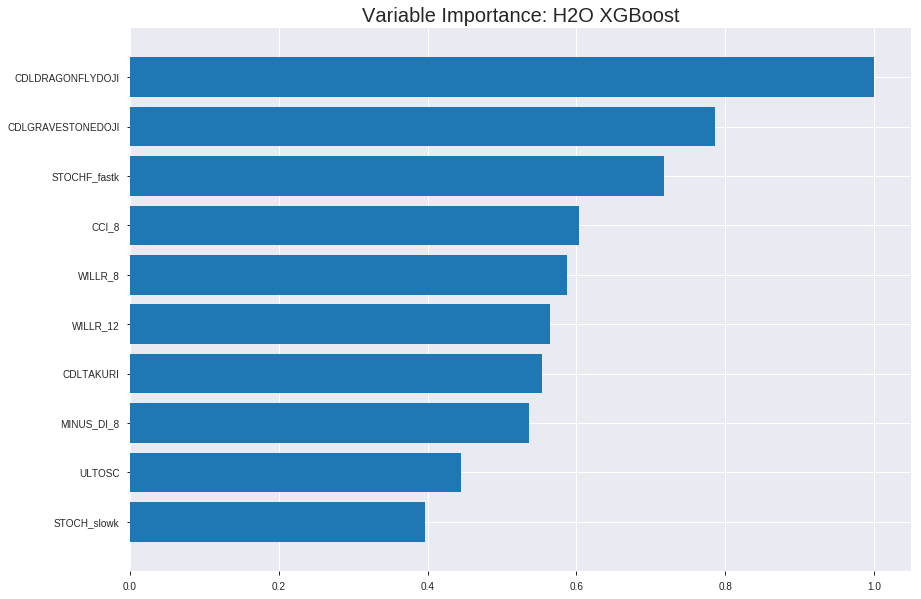

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_124708_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10603599049934392
RMSE: 0.3256316792011243
LogLoss: 0.3632970603000571
Mean Per-Class Error: 0.09541917293233082
AUC: 0.9577537593984962
pr_auc: 0.9565042753361688
Gini: 0.9155075187969923
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5067521035671234: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      777  98   0.112    (98.0/875.0)
1      75   837  0.0822   (75.0/912.0)
Total  852  935  0.0968   (173.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.506752     0.906335  206
max f2                       0.427915     0.929392  233
max f0point5                 0.551731     0.914522  186
max accuracy                 0.538135     0.904309  193
max precision                0.959227     1         0
max recall                   0.119738     1         359
max specificity              0.959227     1         0
max absolute_mcc             0.538135     0.809025  193
max min_per_class_accuracy   0.525902     0.901316  198
max mean_per_class_accuracy  0.538135     0.904581  193

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 50.79 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.941678           1.95943    1.95943            1                0.950629   1                           0.950629            0.0197368       0.0197368                  95.943    95.943
    2        0.0201455                   0.932512           1.95943    1.95943            1                0.937116   1                           0.943873            0.0197368       0.0394737                  95.943    95.943
    3        0.0302182                   0.922663           1.95943    1.95943            1                0.927412   1                           0.938386            0.0197368       0.0592105                  95.943    95.943
    4        0.040291                    0.915703           1.95943    1.95943            1                0.919782   1                           0.933735            0.0197368       0.0789474                  95.943    95.943
    5        0.0503637                   0.908298           1.95943    1.95943            1                0.911874   1                           0.929363            0.0197368       0.0986842                  95.943    95.943
    6        0.100168                    0.868997           1.95943    1.95943            1                0.889047   1                           0.909317            0.0975877       0.196272                   95.943    95.943
    7        0.149972                    0.826926           1.9154     1.94481            0.977528         0.847878   0.992537                    0.888914            0.0953947       0.291667                   91.5398   94.4807
    8        0.200336                    0.788069           1.87234    1.92659            0.955556         0.808858   0.98324                     0.868788            0.0942982       0.385965                   87.2344   92.659
    9        0.299944                    0.707834           1.88237    1.91191            0.960674         0.745765   0.975746                    0.827934            0.1875          0.573465                   88.2374   91.1906
    10       0.400112                    0.632889           1.70766    1.86077            0.871508         0.670505   0.94965                     0.788521            0.171053        0.744518                   70.766    86.0773
    11       0.50028                     0.532473           1.52157    1.79286            0.776536         0.583519   0.914989                    0.747475            0.152412        0.89693                    52.1568   79.2856
    12       0.599888                    0.414918           0.638466   1.60118            0.325843         0.47688    0.817164                    0.702544            0.0635965       0.960526                   -36.1534  60.1176
    13       0.700056                    0.312313           0.218931   1.4034             0.111732         0.365461   0.716227                    0.654312            0.0219298       0.982456                   -78.1069  40.3397
    14       0.799664                    0.209655           0.0770562  1.23818            0.0393258        0.263187   0.63191                     0.605593            0.00767544      0.990132                   -92.2944  23.8184
    15       0.899832                    0.109682           0.0985188  1.11132            0.0502793        0.160524   0.567164                    0.556048            0.00986842      1                          -90.1481  11.1318
    16       1                           0.0342776          0          1                  0                0.0753027  0.510353        



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17743530667642146
RMSE: 0.4212307048120085
LogLoss: 0.5313845514431097
Mean Per-Class Error: 0.25681038181038185
AUC: 0.8179735858307287
pr_auc: 0.8014163202188119
Gini: 0.6359471716614573
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4453796446323395: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      158  101  0.39     (101.0/259.0)
1      33   219  0.131    (33.0/252.0)
Total  191  320  0.2622   (134.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44538      0.765734  247
max f2                       0.196967     0.85595   336
max f0point5                 0.744579     0.763575  117
max accuracy                 0.65747      0.741683  154
max precision                0.965112     1         0
max recall                   0.050837     1         395
max specificity              0.965112     1         0
max absolute_mcc             0.460256     0.49779   239
max min_per_class_accuracy   0.574556     0.72619   190
max mean_per_class_accuracy  0.460256     0.74319   239

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 54.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.947029           2.02778   2.02778            1                0.955581  1                           0.955581            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.935759           2.02778   2.02778            1                0.938661  1                           0.94789             0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.929158           1.62222   1.90104            0.8              0.933325  0.9375                      0.943339            0.015873        0.0595238                  62.2222   90.1042
    4        0.0410959                   0.923982           1.62222   1.83466            0.8              0.92578   0.904762                    0.939158            0.015873        0.0753968                  62.2222   83.4656
    5        0.0508806                   0.916468           1.62222   1.7938             0.8              0.920067  0.884615                    0.935487            0.015873        0.0912698                  62.2222   79.3803
    6        0.101761                    0.889817           1.87179   1.8328             0.923077         0.900598  0.903846                    0.918042            0.0952381       0.186508                   87.1795   83.2799
    7        0.150685                    0.860008           1.78444   1.8171             0.88             0.874232  0.896104                    0.903818            0.0873016       0.27381                    78.4444   81.71
    8        0.201566                    0.829344           1.63782   1.77184            0.807692         0.844268  0.873786                    0.888786            0.0833333       0.357143                   63.7821   77.1845
    9        0.30137                     0.754507           1.63017   1.72493            0.803922         0.795428  0.850649                    0.857869            0.162698        0.519841                   63.0174   72.4928
    10       0.401174                    0.661754           1.23257   1.60244            0.607843         0.707481  0.790244                    0.820455            0.123016        0.642857                   23.2571   60.2439
    11       0.500978                    0.567912           0.874728  1.45747            0.431373         0.61871   0.71875                     0.780264            0.0873016       0.730159                   -12.5272  45.7465
    12       0.600783                    0.464909           1.15305   1.40689            0.568627         0.518026  0.693811                    0.7367              0.115079        0.845238                   15.305    40.6895
    13       0.700587                    0.361187           0.636166  1.2971             0.313725         0.416294  0.639665                    0.691055            0.0634921       0.90873                    -36.3834  29.7098
    14       0.800391                    0.24579            0.397603  1.18494            0.196078         0.312374  0.584352                    0.643836            0.0396825       0.948413                   -60.2397  18.4936
    15       0.900196                    0.128697           0.318083  1.08883            0.156863         0.182969  0.536957                    0.59274             0.031746        0.980159                   -68.1917  8.88285
    16       1                           0.0355161          0.198802  1                  0.0980392        0.082851  0.493151                    0.541851           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 12:47:27  13.205 sec  0                  0.5              0.693147            0.5             0                  1                0.489647                         0.5                0.693147              0.5               0                    1                  0.506849
    2019-07-25 12:47:28  13.394 sec  5                  0.466544         0.627932            0.867885        0.873187           1.95943          0.214885                         0.471469           0.637206              0.806214          0.77445              1.7381             0.264188
    2019-07-25 12:47:28  13.494 sec  10                 0.440414         0.578328            0.891182        0.89327            1.95943          0.187465                         0.454039           0.603156              0.810075          0.802833             2.02778            0.273973
    2019-07-25 12:47:28  13.595 sec  15                 0.420181         0.539911            0.899333        0.901283           1.95943          0.189144                         0.441006           0.576825              0.812251          0.804726             2.02778            0.25636
    2019-07-25 12:47:28  13.694 sec  20                 0.405161         0.510909            0.905204        0.905178           1.95943          0.174035                         0.434241           0.562244              0.810665          0.791543             2.02778            0.272016
    2019-07-25 12:47:28  13.799 sec  25                 0.392018         0.485582            0.912123        0.914787           1.95943          0.157806                         0.429224           0.551245              0.813737          0.798067             2.02778            0.270059
    2019-07-25 12:47:28  13.897 sec  30                 0.382269         0.46657             0.918204        0.919918           1.95943          0.156128                         0.426375           0.543997              0.815514          0.802273             2.02778            0.277886
    2019-07-25 12:47:28  13.998 sec  35                 0.37195          0.44706             0.92537         0.925101           1.95943          0.144376                         0.4231             0.536778              0.818387          0.805521             2.02778            0.262231
    2019-07-25 12:47:28  14.103 sec  40                 0.364075         0.432232            0.931722        0.932795           1.95943          0.132625                         0.422347           0.534708              0.81733           0.800061             2.02778            0.258317
    2019-07-25 12:47:28  14.205 sec  45                 0.35652          0.418208            0.936779        0.935458           1.95943          0.124231                         0.42214            0.533293              0.817139          0.801727             2.02778            0.260274
    2019-07-25 12:47:29  14.298 sec  50                 0.350891         0.407413            0.939964        0.94072            1.95943          0.123111                         0.421765           0.53222               0.818533          0.802816             2.02778            0.262231
    2019-07-25 12:47:29  14.426 sec  55                 0.343622         0.394422            0.945375        0.943842           1.95943          0.11136                          0.42197            0.532984              0.817338          0.

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ----------------------
CDLDRAGONFLYDOJI    842.3612670898438      1.0                   0.07726218126912235
CDLGRAVESTONEDOJI   662.0416870117188      0.7859355752418604    0.060723096880188565
STOCHF_fastk        604.733154296875       0.7179023750535006    0.055466703434917025
CCI_8               507.8759765625         0.6029194318455426    0.046582870433926574
WILLR_8             494.3517150878906      0.5868642521940227    0.04534241223338252
---                 ---                    ---                   ---
CDLRICKSHAWMAN      25.301952362060547     0.030036937060832256  0.002320719275963241
CDLLONGLEGGEDDOJI   23.163175582885742     0.02749791151118446   0.0021245486236994198
CDLDOJI             15.771650314331055     0.018723142825427298  0.0014465908549058314
CDLCLOSINGMARUBOZU  5.04948616027832       0.005994442476828362  0.0004631437012520397
CDLSHOOTINGSTAR     1.6830902099609375     0.001998062204089239  0.00015437464419932494


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.73828125)

('F1', 0.7752442996742671)

('auc', 0.822152981427175)

('logloss', 0.510921816071807)

('mean_per_class_error', 0.2620967741935484)

('rmse', 0.41442907261890705)

('mse', 0.17175145623176735)

xgboost prediction progress: |████████████████████████████████████████████| 100%


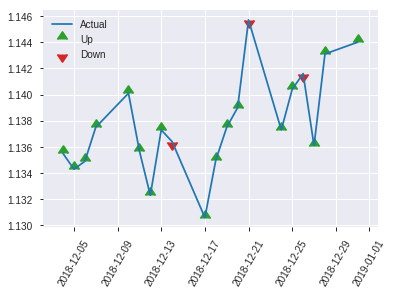


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17175145623176735
RMSE: 0.41442907261890705
LogLoss: 0.510921816071807
Mean Per-Class Error: 0.2620967741935484
AUC: 0.822152981427175
pr_auc: 0.8313112971663525
Gini: 0.6443059628543499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40332189202308655: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   56   0.4516   (56.0/124.0)
1      13   119  0.0985   (13.0/132.0)
Total  81   175  0.2695   (69.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403322     0.775244  174
max f2                       0.185164     0.870147  218
max f0point5                 0.6618       0.779915  83
max accuracy                 0.516622     0.738281  132
max precision                0.955099     1         0
max recall                   0.0879526    1         239
max specificity              0.955099     1         0
max absolute_mcc             0.6618       0.49421   83
max min_per_class_accuracy   0.520765     0.725806  129
max mean_per_class_accuracy  0.516622     0.737903  132

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 52.13 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.9334             1.93939    1.93939            1                0.947614   1                           0.947614            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.927641           1.93939    1.93939            1                0.928971   1                           0.938293            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.913146           1.93939    1.93939            1                0.920324   1                           0.9338              0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.910767           1.93939    1.93939            1                0.911718   1                           0.927778            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.905044           1.93939    1.93939            1                0.908461   1                           0.924806            0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.858812           1.93939    1.93939            1                0.88263    1                           0.903718            0.0984848       0.19697                    93.9394   93.9394
    7        0.152344                    0.817309           1.64103    1.83994            0.846154         0.836155   0.948718                    0.881197            0.0833333       0.280303                   64.1026   83.9938
    8        0.203125                    0.781727           1.19347    1.67832            0.615385         0.796309   0.865385                    0.859975            0.0606061       0.340909                   19.3473   67.8322
    9        0.300781                    0.681986           1.70667    1.68752            0.88             0.739181   0.87013                     0.820756            0.166667        0.507576                   70.6667   68.7525
    10       0.402344                    0.607004           1.04429    1.52515            0.538462         0.643614   0.786408                    0.776041            0.106061        0.613636                   4.4289    52.5154
    11       0.5                         0.526896           1.00848    1.42424            0.52             0.57327    0.734375                    0.736437            0.0984848       0.712121                   0.848485  42.4242
    12       0.601562                    0.452783           0.895105   1.33491            0.461538         0.487834   0.688312                    0.694465            0.0909091       0.80303                    -10.4895  33.4908
    13       0.699219                    0.391152           1.08606    1.30015            0.56             0.419739   0.670391                    0.656095            0.106061        0.909091                   8.60606   30.0152
    14       0.800781                    0.271023           0.522145   1.20148            0.269231         0.341813   0.619512                    0.616235            0.0530303       0.962121                   -47.7855  20.1478
    15       0.898438                    0.131632           0.310303   1.10461            0.16             0.20211    0.569565                    0.571222            0.030303        0.992424                   -68.9697  10.4611
    16       1                           0.0455344          0.0745921  1                  0.0384615        0.0793764  0.515625 

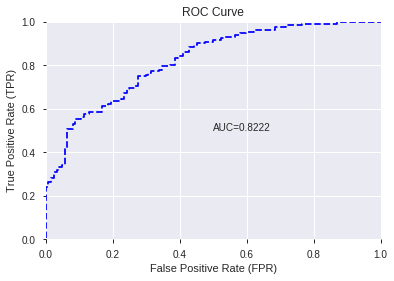

This function is available for GLM models only


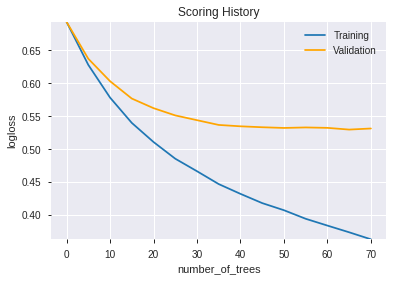

--2019-07-25 12:47:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Share

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_124708_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_124708_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'CCI_8',
 'WILLR_8',
 'WILLR_12',
 'CDLTAKURI',
 'MINUS_DI_8',
 'ULTOSC',
 'STOCH_slowk',
 'CCI_14',
 'WILLR_14',
 'TRANGE',
 'CORREL_8',
 'PLUS_DM_8',
 'DX_8',
 'CCI_12',
 'DIV',
 'MINUS_DM_8',
 'PLUS_DI_8',
 'SUB',
 'CCI_30',
 'MINUS_DM_12',
 'PLUS_DI_14',
 'MINUS_DI_14',
 'CCI_24',
 'aroonup_24',
 'PLUS_DI_12',
 'PLUS_DM_12',
 'CCI_20',
 'aroonup_8',
 'aroonup_12',
 'STOCHRSI_fastk',
 'PLUS_DM_14',
 'MINUS_DI_12',
 'days_in_month',
 'AROONOSC_12',
 'STOCHF_fastd',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLCLOSINGMARUBOZU',
 'CDLSHOOTINGSTAR']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [914] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


16

['MINUS_DI_8',
 'PLUS_DI_8',
 'WILLR_8',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'ULTOSC',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLTAKURI']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_124744_model_6  0.785252  0.530361              0.357649  0.426915  0.182257
1  DeepLearning_grid_1_AutoML_20190725_124744_model_5  0.785007  0.566033              0.341276  0.439474  0.193137
2  DeepLearning_grid_1_AutoML_20190725_124744_model_7  0.779570  0.554383              0.370235  0.436276  0.190336
3  DeepLearning_grid_1_AutoML_20190725_124744_model_3  0.772849  0.547926              0.336022  0.433624  0.188030
4               DeepLearning_1_AutoML_20190725_124744  0.768695  0.558331              0.310117  0.438661  0.192423
5  DeepLearning_grid_1_AutoML_20190725_124744_model_4  0.765457  0.577217              0.315371  0.446639  0.199486
6  DeepLearning_grid_1_AutoML_20190725_124744_model_1  0.757270  0.572386              0.339565  0.443063  0.196305
7  DeepLearning_grid_1_AutoML_20190725_124744_model_2  0.752749  0.568143              0.348363  0.443547  0.196734

variable  relative_importance  scaled_importance  percentage
0    CDLGRAVESTONEDOJI             1.000000           1.000000    0.110765
1     CDLDRAGONFLYDOJI             0.892749           0.892749    0.098886
2            CDLTAKURI             0.835160           0.835160    0.092507
3               ULTOSC             0.797279           0.797279    0.088311
4           MINUS_DI_8             0.740040           0.740040    0.081971
5            PLUS_DI_8             0.717505           0.717505    0.079475
6         STOCHF_fastk             0.692358           0.692358    0.076689
7              WILLR_8             0.472379           0.472379    0.052323
8          STOCH_slowk             0.427338           0.427338    0.047334
9         STOCHF_fastd             0.415948           0.415948    0.046073
10   CDLINVERTEDHAMMER             0.358851           0.358851    0.039748
11       CDLHANGINGMAN             0.352964           0.352964    0.039096
12  CDLCLOSINGMARUBOZU             0.340802           0.340802    0.037749
13           CDLHAMMER             0.333264           0.333264    0.036914
14         CDLBELTHOLD             0.331349           0.331349    0.036702
15     CDLSHOOTINGSTAR             0.320113           0.320113    0.035457

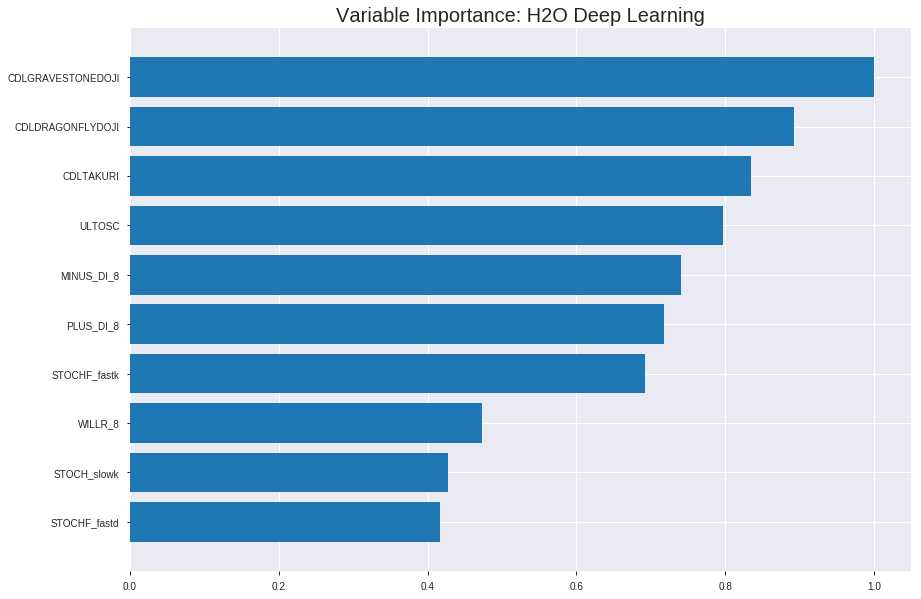

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_124744_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19647138135726205
RMSE: 0.44325092369589264
LogLoss: 0.5744581129598607
Mean Per-Class Error: 0.316421679197995
AUC: 0.7606334586466166
pr_auc: 0.7604922494818881
Gini: 0.5212669172932332
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3893980324128745: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      347  528   0.6034   (528.0/875.0)
1      78   834   0.0855   (78.0/912.0)
Total  425  1362  0.3391   (606.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389398     0.733509  280
max f2                       0.108055     0.860122  350
max f0point5                 0.565153     0.694444  161
max accuracy                 0.44405      0.686066  241
max precision                0.991483     1         0
max recall                   0.00420531   1         398
max specificity              0.991483     1         0
max absolute_mcc             0.443042     0.379445  242
max min_per_class_accuracy   0.475865     0.673143  215
max mean_per_class_accuracy  0.44405      0.683578  241

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 50.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100727                   0.983768           1.74172   1.74172            0.888889         0.987265   0.888889                    0.987265            0.0175439       0.0175439                  74.1715    74.1715
    2        0.0201455                   0.977228           1.74172   1.74172            0.888889         0.980766   0.888889                    0.984016            0.0175439       0.0350877                  74.1715    74.1715
    3        0.0302182                   0.970743           1.95943   1.81429            1                0.974374   0.925926                    0.980802            0.0197368       0.0548246                  95.943     81.4287
    4        0.040291                    0.964691           1.95943   1.85057            1                0.968089   0.944444                    0.977624            0.0197368       0.0745614                  95.943     85.0573
    5        0.0503637                   0.956133           1.74172   1.8288             0.888889         0.960342   0.933333                    0.974167            0.0175439       0.0921053                  74.1715    82.8801
    6        0.100168                    0.912153           1.80532   1.81712            0.921348         0.935789   0.927374                    0.955086            0.0899123       0.182018                   80.5317    81.7125
    7        0.149972                    0.7533             1.54112   1.72547            0.786517         0.816082   0.880597                    0.908924            0.0767544       0.258772                   54.1125    72.5468
    8        0.200336                    0.700819           1.30629   1.62009            0.666667         0.725095   0.826816                    0.86271             0.0657895       0.324561                   30.6287    62.0087
    9        0.299944                    0.593497           1.35399   1.53172            0.691011         0.643558   0.781716                    0.789932            0.134868        0.45943                    35.3988    53.1718
    10       0.400112                    0.514643           1.08371   1.41956            0.553073         0.550762   0.724476                    0.730056            0.108553        0.567982                   8.3707     41.9559
    11       0.50028                     0.475882           0.996135  1.33478            0.50838          0.49381    0.681208                    0.682754            0.0997807       0.667763                   -0.386528  33.4779
    12       0.599888                    0.449404           1.04576   1.28679            0.533708         0.463269   0.656716                    0.64631             0.104167        0.77193                    4.57631    28.679
    13       0.700056                    0.418632           0.897616  1.2311             0.458101         0.435726   0.628297                    0.616178            0.0899123       0.861842                   -10.2384   23.1105
    14       0.799664                    0.366535           0.715522  1.16688            0.365169         0.395849   0.595521                    0.588733            0.0712719       0.933114                   -28.4478   16.6882
    15       0.899832                    0.061114           0.547327  1.09791            0.27933          0.2696     0.560323                    0.553208            0.0548246       0.987939                   -45.2673   9.79143
    16       1                           0.00111227         0.120412  1                  0.0614525        0.0259622  0.510353   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1905026935599385
RMSE: 0.43646614251272514
LogLoss: 0.5700024492006248
Mean Per-Class Error: 0.27965465465465467
AUC: 0.788617699331985
pr_auc: 0.7869350792483226
Gini: 0.57723539866397
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45992218715223965: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      144  115  0.444    (115.0/259.0)
1      39   213  0.1548   (39.0/252.0)
Total  183  328  0.3014   (154.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459922     0.734483  256
max f2                       0.303016     0.848861  345
max f0point5                 0.529239     0.719064  190
max accuracy                 0.508623     0.720157  208
max precision                0.990357     1         0
max recall                   0.00237051   1         397
max specificity              0.990357     1         0
max absolute_mcc             0.507504     0.440751  209
max min_per_class_accuracy   0.510274     0.714286  205
max mean_per_class_accuracy  0.507504     0.720345  209

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 53.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.984821           2.02778   2.02778            1                0.987324   1                           0.987324            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.977279           2.02778   2.02778            1                0.98025    1                           0.984108            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.971017           2.02778   2.02778            1                0.97392    1                           0.980924            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.965095           1.62222   1.93122            0.8              0.969021   0.952381                    0.97809             0.015873        0.0793651                  62.2222   93.1217
    5        0.0508806                   0.957302           2.02778   1.94979            1                0.959845   0.961538                    0.974582            0.0198413       0.0992063                  102.778   94.9786
    6        0.101761                    0.935705           1.7938    1.87179            0.884615         0.943671   0.923077                    0.959126            0.0912698       0.190476                   79.3803   87.1795
    7        0.150685                    0.902765           1.94667   1.8961             0.96             0.924171   0.935065                    0.947777            0.0952381       0.285714                   94.6667   89.6104
    8        0.201566                    0.754807           1.24786   1.73247            0.615385         0.824251   0.854369                    0.916596            0.0634921       0.349206                   24.7863   73.247
    9        0.30137                     0.657825           1.35185   1.60642            0.666667         0.710471   0.792208                    0.848333            0.134921        0.484127                   35.1852   60.6421
    10       0.401174                    0.563858           1.23257   1.51341            0.607843         0.610932   0.746341                    0.789273            0.123016        0.607143                   23.2571   51.3415
    11       0.500978                    0.509865           1.15305   1.44162            0.568627         0.534246   0.710938                    0.738466            0.115079        0.722222                   15.305    44.1623
    12       0.600783                    0.473648           0.874728  1.34745            0.431373         0.492497   0.664495                    0.697605            0.0873016       0.809524                   -12.5272  34.7448
    13       0.700587                    0.442668           0.715686  1.25745            0.352941         0.45724    0.620112                    0.663363            0.0714286       0.880952                   -28.4314  25.7449
    14       0.800391                    0.373771           0.596405  1.17502            0.294118         0.412081   0.579462                    0.63203             0.0595238       0.940476                   -40.3595  17.502
    15       0.900196                    0.0485778          0.357843  1.08442            0.176471         0.252106   0.534783                    0.589908            0.0357143       0.97619                    -64.2157  8.44203
    16       1                           0.00126288         0.238562  1                  0.117647         0.0185228  0.493151                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 12:51:40  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 12:51:42  2 min 12.689 sec  931 obs/sec       1         1             1787       0.569924         1.11755             -0.299809      0.742652        0.745672           1.41514          0.37549                          0.52425            0.878539              -0.0995598       0.792732          0.792899             2.02778            0.2818
    2019-07-25 12:51:47  2 min 18.169 sec  2331 obs/sec      9         9             16083      0.4446           0.57591             0.208985       0.757485        0.756741           1.85057          0.344712                         0.438913           0.572631              0.229277         0.788296          0.790298             2.02778            0.287671
    2019-07-25 12:51:53  2 min 23.431 sec  2911 obs/sec      19        19            33953      0.443251         0.574458            0.213777       0.760633        0.760492           1.74172          0.339116                         0.436466           0.570002              0.237846         0.788618          0.786935             2.02778            0.30137
    2019-07-25 12:51:58  2 min 28.647 sec  3163 obs/sec      29        29            51823      0.442221         0.575551            0.217427       0.767487        0.768257           1.85057          0.336318                         0.438831           0.583697              0.229567         0.786948          0.787705             2.02778            0.32681
    2019-07-25 12:52:03  2 min 33.934 sec  3298 obs/sec      39        39            69693      0.441814         0.571052            0.218867       0.765133        0.764465           1.74172          0.321209                         0.439294           0.575629              0.227937         0.785484          0.767415             2.02778            0.320939
    2019-07-25 12:52:09  2 min 39.614 sec  3464 obs/sec      51        51            91137      0.442266         0.570604            0.217267       0.766454        0.768212           1.74172          0.31897                          0.439493           0.573364              0.227237         0.784328          0.771954             2.02778            0.311155
    2019-07-25 12:52:14  2 min 45.072 sec  3543 obs/sec      62        62            110794     0.441904         0.569252            0.218547       0.766154        0.76841            1.74172          0.323447                         0.439241           0.570862              0.228124         0.785301          0.773882             1.68981            0.293542
    2019-07-25 12:52:15  2 min 45.605 sec  3540 obs/sec      62        62            110794     0.443251         0.574458            0.213777       0.760633        0.760492           1.74172          0.339116                         0.436466           0.570002              0.237846         0.788618          0.786935             2.02778            0.30137

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
CDLGRAVESTONEDOJI   1                      1                    0.110765
CDLDRAGONFLYDOJI    0.892749               0.892749             0.0988856
CDLTAKURI           0.83516                0.83516              0.0925068
ULTOSC              0.797279               0.797279             0.0883108
MINUS_DI_8          0.74004                0.74004              0.0819707
PLUS_DI_8           0.717505               0.717505             0.0794747
STOCHF_fastk        0.692358               0.692358             0.0766893
WILLR_8             0.472379               0.472379             0.0523232
STOCH_slowk         0.427338               0.427338             0.0473342
STOCHF_fastd        0.415948               0.415948             0.0460726
CDLINVERTEDHAMMER   0.358851               0.358851             0.0397482
CDLHANGINGMAN       0.352964               0.352964             0.0390962
CDLCLOSINGMARUBOZU  0.340802               0.340802             0.037749
CDLHAMMER           0.333264               0.333264             0.0369141
CDLBELTHOLD         0.331349               0.331349             0.036702
CDLSHOOTINGSTAR     0.320113               0.320113             0.0354574

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7109375)

('F1', 0.7405247813411079)

('auc', 0.7852517106549365)

('logloss', 0.5303614466881286)

('mean_per_class_error', 0.28910068426197455)

('rmse', 0.42691521457780796)

('mse', 0.1822566004380158)

deeplearning prediction progress: |███████████████████████████████████████| 100%


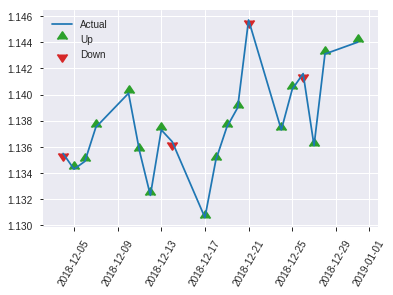


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1822566004380158
RMSE: 0.42691521457780796
LogLoss: 0.5303614466881286
Mean Per-Class Error: 0.28910068426197455
AUC: 0.7852517106549365
pr_auc: 0.8065238232670074
Gini: 0.570503421309873
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3709857627418244: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      40   84   0.6774   (84.0/124.0)
1      5    127  0.0379   (5.0/132.0)
Total  45   211  0.3477   (89.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.370986     0.740525  210
max f2                       0.277244     0.86755   226
max f0point5                 0.601497     0.752315  74
max accuracy                 0.482052     0.710938  129
max precision                0.981487     1         0
max recall                   0.0251118    1         240
max specificity              0.981487     1         0
max absolute_mcc             0.601497     0.45216   74
max min_per_class_accuracy   0.482052     0.709677  129
max mean_per_class_accuracy  0.482052     0.710899  129

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 51.81 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.9793             1.93939    1.93939            1                0.981069   1                           0.981069            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.972671           1.93939    1.93939            1                0.976226   1                           0.978648            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.964599           1.93939    1.93939            1                0.967896   1                           0.97596             0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.958271           1.93939    1.93939            1                0.961995   1                           0.972151            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.957324           1.93939    1.93939            1                0.957974   1                           0.96997             0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.933916           1.79021    1.8648             0.923077         0.945467   0.961538                    0.957718            0.0909091       0.189394                   79.021    86.4802
    7        0.152344                    0.876488           1.93939    1.88967            1                0.915028   0.974359                    0.943488            0.0984848       0.287879                   93.9394   88.9666
    8        0.203125                    0.709333           1.34266    1.75291            0.692308         0.750716   0.903846                    0.895295            0.0681818       0.356061                   34.2657   75.2914
    9        0.300781                    0.591057           1.39636    1.63715            0.72             0.644978   0.844156                    0.814023            0.136364        0.492424                   39.6364   63.7151
    10       0.402344                    0.513363           0.969697   1.46867            0.5              0.548451   0.757282                    0.746986            0.0984848       0.590909                   -3.0303   46.8667
    11       0.5                         0.484002           1.08606    1.39394            0.56             0.49517    0.71875                     0.697803            0.106061        0.69697                    8.60606   39.3939
    12       0.601562                    0.460133           0.745921   1.28453            0.384615         0.472322   0.662338                    0.659735            0.0757576       0.772727                   -25.4079  28.4534
    13       0.699219                    0.433487           0.775758   1.21348            0.4              0.445181   0.625698                    0.629769            0.0757576       0.848485                   -22.4242  21.3476
    14       0.800781                    0.383852           0.820513   1.16364            0.423077         0.410984   0.6                         0.602021            0.0833333       0.931818                   -17.9487  16.3636
    15       0.898438                    0.272123           0.620606   1.10461            0.32             0.33098    0.569565                    0.57256             0.0606061       0.992424                   -37.9394  10.4611
    16       1                           0.00285044         0.0745921  1                  0.0384615        0.0366619  0.515625 

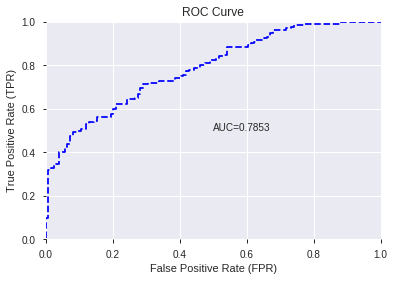

This function is available for GLM models only


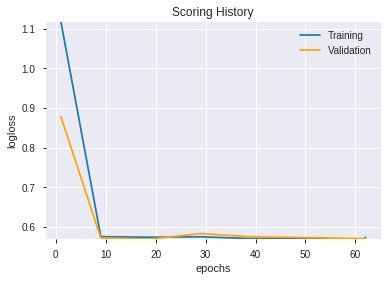

['CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'ULTOSC',
 'MINUS_DI_8',
 'PLUS_DI_8',
 'STOCHF_fastk',
 'WILLR_8',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'CDLBELTHOLD',
 'CDLSHOOTINGSTAR']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_125350_model_1  0.785618  0.541221              0.318671  0.430869  0.185648

variable  relative_importance  scaled_importance  percentage
0    CDLGRAVESTONEDOJI             0.588730           1.000000    0.207498
1     CDLDRAGONFLYDOJI             0.559840           0.950928    0.197316
2         STOCHF_fastk             0.433836           0.736901    0.152906
3            PLUS_DI_8             0.337876           0.573906    0.119084
4           MINUS_DI_8             0.216773           0.368205    0.076402
5               ULTOSC             0.188221           0.319707    0.066338
6            CDLTAKURI             0.136440           0.231752    0.048088
7   CDLCLOSINGMARUBOZU             0.066190           0.112428    0.023329
8              WILLR_8             0.058059           0.098617    0.020463
9          CDLBELTHOLD             0.056935           0.096708    0.020067
10     CDLSHOOTINGSTAR             0.045124           0.076646    0.015904
11       CDLHANGINGMAN             0.044938           0.076331    0.015839
12         STOCH_slowk             0.035723           0.060677    0.012590
13           CDLHAMMER             0.031132           0.052880    0.010973
14        STOCHF_fastd             0.028955           0.049182    0.010205
15   CDLINVERTEDHAMMER             0.008509           0.014454    0.002999

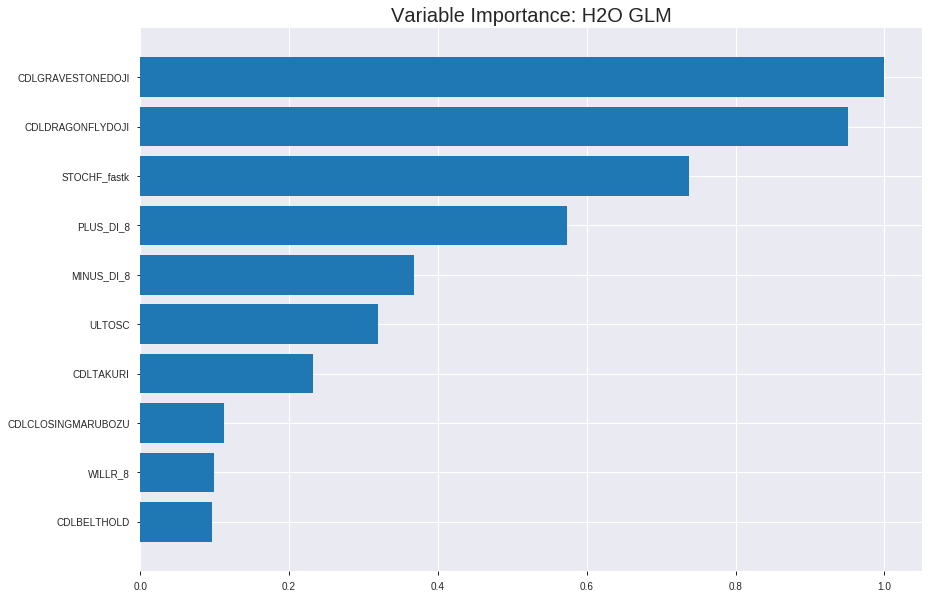

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_125350_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19681071938620884
RMSE: 0.4436335417731721
LogLoss: 0.5732276111830307
Null degrees of freedom: 1786
Residual degrees of freedom: 1770
Null deviance: 2476.5418801583887
Residual deviance: 2048.7154823681517
AIC: 2082.7154823681517
AUC: 0.7608552631578948
pr_auc: 0.759298420168918
Gini: 0.5217105263157895
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4484123169620331: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      418  457   0.5223   (457.0/875.0)
1      119  793   0.1305   (119.0/912.0)
Total  537  1250  0.3223   (576.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448412     0.73358   245
max f2                       0.190968     0.858567  336
max f0point5                 0.538294     0.696218  181
max accuracy                 0.500577     0.687745  209
max precision                0.976947     1         0
max recall                   0.0298022    1         393
max specificity              0.976947     1         0
max absolute_mcc             0.448412     0.378598  245
max min_per_class_accuracy   0.519148     0.68      196
max mean_per_class_accuracy  0.500577     0.68666   209

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 51.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100727                   0.944971           1.74172   1.74172            0.888889         0.955431   0.888889                    0.955431            0.0175439       0.0175439                  74.1715    74.1715
    2        0.0201455                   0.935528           1.74172   1.74172            0.888889         0.939842   0.888889                    0.947636            0.0175439       0.0350877                  74.1715    74.1715
    3        0.0302182                   0.926578           1.74172   1.74172            0.888889         0.93174    0.888889                    0.942338            0.0175439       0.0526316                  74.1715    74.1715
    4        0.040291                    0.918811           1.85057   1.76893            0.944444         0.922578   0.902778                    0.937398            0.0186404       0.0712719                  85.0573    76.893
    5        0.0503637                   0.910801           1.85057   1.78526            0.944444         0.914377   0.911111                    0.932794            0.0186404       0.0899123                  85.0573    78.5258
    6        0.100168                    0.86307            1.80532   1.79523            0.921348         0.89002    0.916201                    0.911526            0.0899123       0.179825                   80.5317    79.5232
    7        0.149972                    0.708467           1.49709   1.69622            0.764045         0.77241    0.865672                    0.865327            0.0745614       0.254386                   49.7092    69.6223
    8        0.200336                    0.655591           1.32806   1.60367            0.677778         0.67697    0.818436                    0.817975            0.066886        0.321272                   32.8058    60.3667
    9        0.299944                    0.594462           1.24391   1.48419            0.634831         0.619024   0.757463                    0.751905            0.123904        0.445175                   24.3908    48.4195
    10       0.400112                    0.55302            1.2698    1.43052            0.648045         0.570493   0.73007                     0.706489            0.127193        0.572368                   26.9798    43.0521
    11       0.50028                     0.51963            1.05087   1.35451            0.536313         0.535608   0.691275                    0.672275            0.105263        0.677632                   5.08674    35.4505
    12       0.599888                    0.485029           0.990723  1.2941             0.505618         0.502259   0.660448                    0.644044            0.0986842       0.776316                   -0.927705  29.4101
    13       0.700056                    0.447378           0.930456  1.24207            0.47486          0.466586   0.633893                    0.618653            0.0932018       0.869518                   -6.95445   24.2069
    14       0.799664                    0.387749           0.67149   1.171              0.342697         0.41936    0.597621                    0.593828            0.066886        0.936404                   -32.851    17.0996
    15       0.899832                    0.103506           0.470701  1.09304            0.240223         0.289999   0.557836                    0.560006            0.0471491       0.983553                   -52.9299   9.30401
    16       1                           0.00265005         0.164198  1                  0.0837989        0.0642992  0.510353   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1904106015648187
RMSE: 0.4363606324645003
LogLoss: 0.5536681977873693
Null degrees of freedom: 510
Residual degrees of freedom: 494
Null deviance: 708.9054443622276
Residual deviance: 565.8488981386914
AIC: 599.8488981386914
AUC: 0.7896672182386468
pr_auc: 0.7947299858167775
Gini: 0.5793344364772937
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4925871285565199: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      142  117  0.4517   (117.0/259.0)
1      35   217  0.1389   (35.0/252.0)
Total  177  334  0.2975   (152.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492587     0.740614  255
max f2                       0.0975547    0.848033  360
max f0point5                 0.596742     0.712316  166
max accuracy                 0.547209     0.7182    210
max precision                0.969928     1         0
max recall                   0.0587479    1         389
max specificity              0.969928     1         0
max absolute_mcc             0.547209     0.43824   210
max min_per_class_accuracy   0.564928     0.702703  196
max mean_per_class_accuracy  0.547209     0.718683  210

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 54.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.950327           2.02778   2.02778            1                0.958757   1                           0.958757            0.0238095       0.0238095                  102.778    102.778
    2        0.0215264                   0.943226           2.02778   2.02778            1                0.945784   1                           0.95286             0.0198413       0.0436508                  102.778    102.778
    3        0.0313112                   0.936669           2.02778   2.02778            1                0.939497   1                           0.948684            0.0198413       0.0634921                  102.778    102.778
    4        0.0410959                   0.93336            2.02778   2.02778            1                0.934328   1                           0.945266            0.0198413       0.0833333                  102.778    102.778
    5        0.0508806                   0.929387           2.02778   2.02778            1                0.931198   1                           0.942561            0.0198413       0.103175                   102.778    102.778
    6        0.101761                    0.900606           1.94979   1.98878            0.961538         0.914448   0.980769                    0.928505            0.0992063       0.202381                   94.9786    98.8782
    7        0.150685                    0.843795           1.78444   1.92244            0.88             0.878029   0.948052                    0.912116            0.0873016       0.289683                   78.4444    92.2439
    8        0.201566                    0.712913           1.24786   1.75216            0.615385         0.780068   0.864078                    0.878784            0.0634921       0.353175                   24.7863    75.2157
    9        0.30137                     0.643929           1.11329   1.54058            0.54902          0.671362   0.75974                     0.810092            0.111111        0.464286                   11.329     54.0584
    10       0.401174                    0.599163           1.39161   1.50352            0.686275         0.621534   0.741463                    0.763183            0.138889        0.603175                   39.1612    50.3523
    11       0.500978                    0.563853           1.03377   1.40994            0.509804         0.58008    0.695312                    0.726705            0.103175        0.706349                   3.37691    40.9939
    12       0.600783                    0.517203           0.994009  1.34084            0.490196         0.537978   0.661238                    0.695353            0.0992063       0.805556                   -0.599129  34.0843
    13       0.700587                    0.471281           0.795207  1.26311            0.392157         0.494096   0.622905                    0.666682            0.0793651       0.884921                   -20.4793   26.3113
    14       0.800391                    0.402203           0.636166  1.18494            0.313725         0.434169   0.584352                    0.637689            0.0634921       0.948413                   -36.3834   18.4936
    15       0.900196                    0.107299           0.318083  1.08883            0.156863         0.28921    0.536957                    0.599054            0.031746        0.980159                   -68.1917   8.88285
    16       1                           0.0216624          0.198802  1                  0.0980392        0.0731074  0.493151  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 12:53:51  0.000 sec   2            .16E2     17            1.3706077010779396  1.3697387716088234
     2019-07-25 12:53:51  0.030 sec   4            .99E1     17            1.3622586273688522  1.3601010750541704
     2019-07-25 12:53:51  0.055 sec   6            .61E1     17            1.3501037184204097  1.34602831457447
     2019-07-25 12:53:51  0.079 sec   8            .38E1     17            1.3333101582999143  1.3264991795295533
     2019-07-25 12:53:51  0.104 sec   10           .24E1     17            1.311628341829238   1.3011376121424025
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 12:53:51  0.239 sec   38           .3E-2     17            1.1458224733020257  1.1073629597702628
     2019-07-25 12:53:51  0.244 sec   39           .19E-2    17            1.1453102592605686  1.1074824239578733
     2019-07-25 12:53:51  0.248 sec   40           .12E-2    17            1.1448962891618268  1.1076327738863299
     2019-07-25 12:53:51  0.252 sec   41           .72E-3    17            1.1445977292821021  1.107784256753319
     2019-07-25 12:53:51  0.255 sec   42           .45E-3    17            1.1444050911697499  1.1079198373587624


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7109375)

('F1', 0.7435897435897436)

('auc', 0.7856182795698925)

('logloss', 0.5412206897526217)

('mean_per_class_error', 0.28616813294232646)

('rmse', 0.43086884879179616)

('mse', 0.18564796485916768)

glm prediction progress: |████████████████████████████████████████████████| 100%


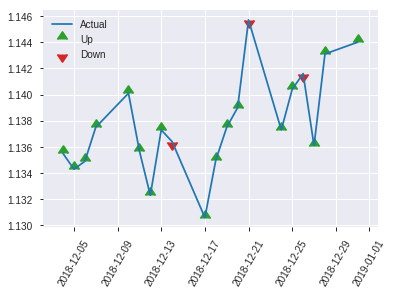


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18564796485916768
RMSE: 0.43086884879179616
LogLoss: 0.5412206897526217
Null degrees of freedom: 255
Residual degrees of freedom: 239
Null deviance: 354.6697985653149
Residual deviance: 277.1049931533423
AIC: 311.1049931533423
AUC: 0.7856182795698925
pr_auc: 0.8114580153754773
Gini: 0.571236559139785
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44940780244335327: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   64   0.5161   (64.0/124.0)
1      16   116  0.1212   (16.0/132.0)
Total  76   180  0.3125   (80.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449408     0.74359   179
max f2                       0.307742     0.86755   226
max f0point5                 0.614549     0.742574  67
max accuracy                 0.552384     0.710938  105
max precision                0.963305     1         0
max recall                   0.0628336    1         248
max specificity              0.963305     1         0
max absolute_mcc             0.637863     0.444873  62
max min_per_class_accuracy   0.524205     0.69697   128
max mean_per_class_accuracy  0.552384     0.713832  105

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 53.02 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.955613           1.93939    1.93939            1                0.960869   1                           0.960869            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.943271           1.93939    1.93939            1                0.947382   1                           0.954126            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.938041           1.93939    1.93939            1                0.939711   1                           0.950522            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.932124           1.93939    1.93939            1                0.934749   1                           0.94622             0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.923514           1.93939    1.93939            1                0.9262     1                           0.94314             0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.873848           1.93939    1.93939            1                0.896353   1                           0.919746            0.0984848       0.19697                    93.9394   93.9394
    7        0.152344                    0.75811            1.79021    1.88967            0.923077         0.839342   0.974359                    0.892945            0.0909091       0.287879                   79.021    88.9666
    8        0.203125                    0.663922           1.34266    1.75291            0.692308         0.70747    0.903846                    0.846576            0.0681818       0.356061                   34.2657   75.2914
    9        0.300781                    0.600898           1.24121    1.58678            0.64             0.628406   0.818182                    0.775742            0.121212        0.477273                   24.1212   58.6777
    10       0.402344                    0.55631            1.19347    1.4875             0.615385         0.578232   0.76699                     0.725885            0.121212        0.598485                   19.3473   48.7496
    11       0.5                         0.52469            0.930909   1.37879            0.48             0.540701   0.710938                    0.689716            0.0909091       0.689394                   -6.90909  37.8788
    12       0.601562                    0.501465           0.895105   1.29713            0.461538         0.514454   0.668831                    0.660127            0.0909091       0.780303                   -10.4895  29.7127
    13       0.699219                    0.451841           0.930909   1.24598            0.48             0.476228   0.642458                    0.634442            0.0909091       0.871212                   -6.90909  24.5979
    14       0.800781                    0.392394           0.522145   1.15418            0.269231         0.424488   0.595122                    0.607814            0.0530303       0.924242                   -47.7855  15.4176
    15       0.898438                    0.278554           0.698182   1.10461            0.36             0.345642   0.569565                    0.579317            0.0681818       0.992424                   -30.1818  10.4611
    16       1                           0.0373224          0.0745921  1                  0.0384615        0.0953291  0.515625 

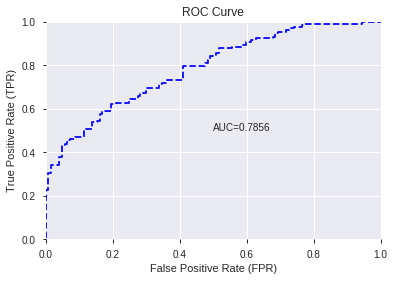

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


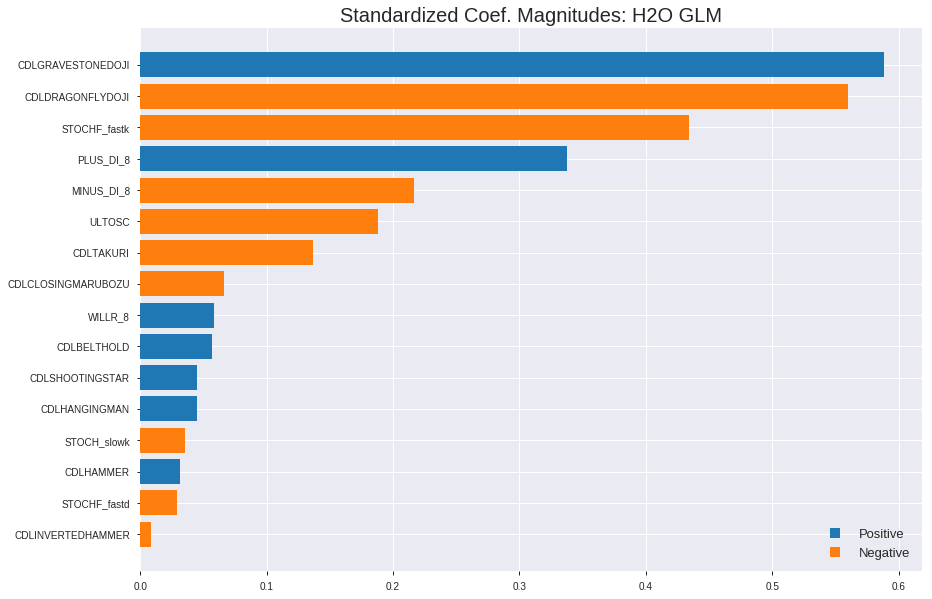

'log_likelihood'
--2019-07-25 12:53:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_125350_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_125350_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'STOCHF_fastk',
 'PLUS_DI_8',
 'MINUS_DI_8',
 'ULTOSC',
 'CDLTAKURI',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'CDLBELTHOLD',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'STOCH_slowk',
 'CDLHAMMER',
 'STOCHF_fastd',
 'CDLINVERTEDHAMMER']

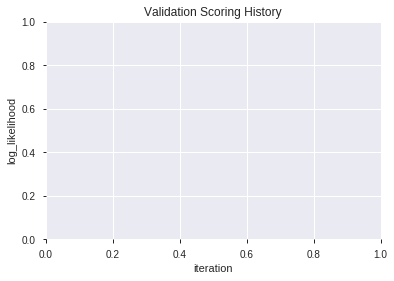

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_125406_model_3  0.788917  0.542584              0.320381  0.430540  0.185364
1               XGBoost_3_AutoML_20190725_125406  0.786718  0.539280              0.311828  0.429720  0.184659
2  XGBoost_grid_1_AutoML_20190725_125406_model_6  0.786657  0.539784              0.362170  0.430345  0.185197
3  XGBoost_grid_1_AutoML_20190725_125406_model_1  0.784855  0.540383              0.309873  0.430388  0.185233
4  XGBoost_grid_1_AutoML_20190725_125406_model_2  0.783724  0.547510              0.298998  0.432931  0.187429
5  XGBoost_grid_1_AutoML_20190725_125406_model_4  0.782930  0.553761              0.308040  0.434116  0.188456
6               XGBoost_2_AutoML_20190725_125406  0.774194  0.556456              0.321725  0.437325  0.191253
7               XGBoost_1_AutoML_20190725_125406  0.759958  0.570524              0.355938  0.444867  0.197907
8  XGBoost_grid_1_AutoML_20190725_125406_model_7  0.753299  0.579472              0.390640  0.448750  0.201377
9  XGBoost_grid_1_AutoML_20190725_125406_model_5  0.752871  0.579754              0.374267  0.451719  0.204050

variable  relative_importance  scaled_importance  percentage
0     CDLDRAGONFLYDOJI           927.600891           1.000000    0.167828
1           MINUS_DI_8           734.416504           0.791738    0.132876
2    CDLGRAVESTONEDOJI           669.419312           0.721667    0.121116
3               ULTOSC           579.416138           0.624639    0.104832
4              WILLR_8           571.049133           0.615619    0.103318
5         STOCHF_fastk           566.492859           0.610708    0.102494
6            PLUS_DI_8           455.370026           0.490912    0.082389
7          STOCH_slowk           393.796082           0.424532    0.071248
8            CDLTAKURI           360.563782           0.388706    0.065236
9         STOCHF_fastd           219.545868           0.236681    0.039722
10   CDLINVERTEDHAMMER            21.805975           0.023508    0.003945
11  CDLCLOSINGMARUBOZU            12.867641           0.013872    0.002328
12         CDLBELTHOLD             8.753477           0.009437    0.001584
13     CDLSHOOTINGSTAR             3.909652           0.004215    0.000707
14           CDLHAMMER             1.672121           0.001803    0.000303
15       CDLHANGINGMAN             0.402499           0.000434    0.000073

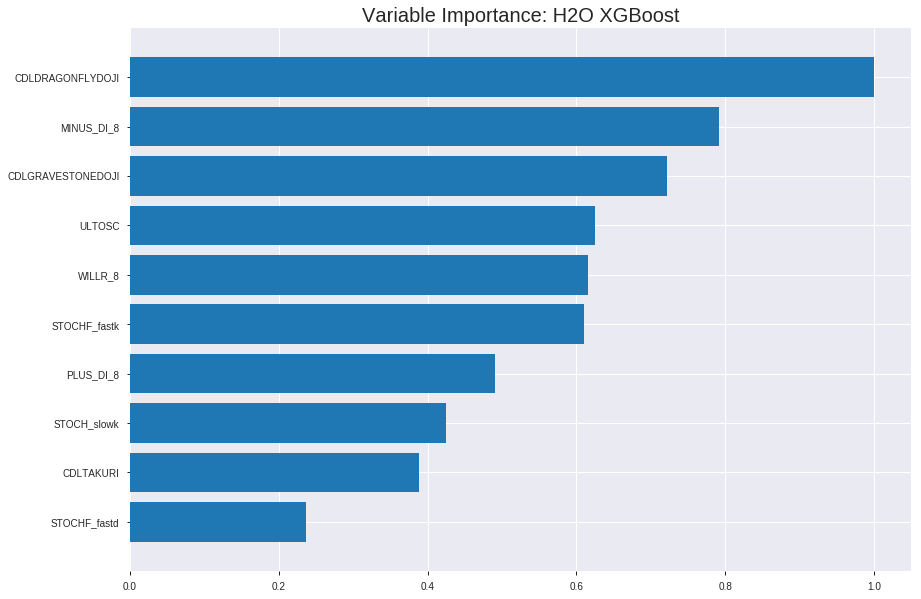

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_125406_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16712977053966727
RMSE: 0.40881508110595344
LogLoss: 0.5049921621420188
Mean Per-Class Error: 0.23567982456140357
AUC: 0.8477456140350877
pr_auc: 0.8498225153108883
Gini: 0.6954912280701755
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45441319545110065: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      557  318   0.3634   (318.0/875.0)
1      127  785   0.1393   (127.0/912.0)
Total  684  1103  0.249    (445.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454413     0.779156  232
max f2                       0.34071      0.874064  294
max f0point5                 0.578047     0.788582  165
max accuracy                 0.517012     0.76441   198
max precision                0.93974      1         0
max recall                   0.112149     1         365
max specificity              0.93974      1         0
max absolute_mcc             0.570841     0.528811  169
max min_per_class_accuracy   0.519109     0.76      197
max mean_per_class_accuracy  0.517012     0.76432   198

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 51.09 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.910993           1.95943    1.95943            1                0.921631   1                           0.921631            0.0197368       0.0197368                  95.943    95.943
    2        0.0201455                   0.896167           1.95943    1.95943            1                0.902672   1                           0.912152            0.0197368       0.0394737                  95.943    95.943
    3        0.0302182                   0.891007           1.95943    1.95943            1                0.893579   1                           0.905961            0.0197368       0.0592105                  95.943    95.943
    4        0.040291                    0.879228           1.85057    1.93222            0.944444         0.885578   0.986111                    0.900865            0.0186404       0.0778509                  85.0573   93.2216
    5        0.0503637                   0.869737           1.85057    1.91589            0.944444         0.873039   0.977778                    0.8953              0.0186404       0.0964912                  85.0573   91.5887
    6        0.100168                    0.827938           1.87137    1.89375            0.955056         0.849096   0.96648                     0.872327            0.0932018       0.189693                   87.1366   89.3751
    7        0.149972                    0.76593            1.67322    1.82052            0.853933         0.796603   0.929104                    0.84718             0.0833333       0.273026                   67.3221   82.0515
    8        0.200336                    0.709634           1.69817    1.78976            0.866667         0.735372   0.913408                    0.819072            0.0855263       0.358553                   69.8173   78.9759
    9        0.299944                    0.634126           1.49709    1.69257            0.764045         0.668517   0.863806                    0.769074            0.149123        0.507675                   49.7092   69.2567
    10       0.400112                    0.580141           1.42305    1.62509            0.726257         0.607665   0.829371                    0.728665            0.142544        0.650219                   42.305    62.5094
    11       0.500839                    0.521948           1.05591    1.51062            0.538889         0.551357   0.77095                     0.693006            0.10636         0.756579                   5.5915    51.0622
    12       0.599888                    0.464759           0.863478   1.40377            0.440678         0.492111   0.716418                    0.659835            0.0855263       0.842105                   -13.6522  40.3771
    13       0.700056                    0.402955           0.777204   1.31412            0.396648         0.433489   0.670663                    0.627449            0.0778509       0.919956                   -22.2796  31.4118
    14       0.799664                    0.337446           0.528386   1.21625            0.269663         0.37434    0.620714                    0.595921            0.0526316       0.972588                   -47.1614  21.6245
    15       0.899832                    0.135852           0.240824   1.10766            0.122905         0.255929   0.565299                    0.558073            0.0241228       0.996711                   -75.9176  10.7663
    16       1                           0.045425           0.0328396  1                  0.0167598        0.0872339  0.510353    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19040273686087533
RMSE: 0.43635162066947264
LogLoss: 0.5572602643225386
Mean Per-Class Error: 0.2819069069069069
AUC: 0.7922718637004351
pr_auc: 0.7942138505243631
Gini: 0.5845437274008702
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45163485407829285: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      146  113  0.4363   (113.0/259.0)
1      34   218  0.1349   (34.0/252.0)
Total  180  331  0.2877   (147.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451635     0.747856  257
max f2                       0.271456     0.850622  341
max f0point5                 0.709818     0.731132  113
max accuracy                 0.623159     0.7182    171
max precision                0.938171     1         0
max recall                   0.0989785    1         375
max specificity              0.938171     1         0
max absolute_mcc             0.462144     0.452212  251
max min_per_class_accuracy   0.579674     0.706349  190
max mean_per_class_accuracy  0.462144     0.718093  251

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 54.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.920529           2.02778   2.02778            1                0.925145   1                           0.925145            0.0238095       0.0238095                  102.778    102.778
    2        0.0215264                   0.91202            2.02778   2.02778            1                0.915042   1                           0.920553            0.0198413       0.0436508                  102.778    102.778
    3        0.0313112                   0.904961           1.62222   1.90104            0.8              0.908105   0.9375                      0.916663            0.015873        0.0595238                  62.2222    90.1042
    4        0.0410959                   0.897149           2.02778   1.93122            1                0.900811   0.952381                    0.912889            0.0198413       0.0793651                  102.778    93.1217
    5        0.0508806                   0.890567           2.02778   1.94979            1                0.893855   0.961538                    0.909228            0.0198413       0.0992063                  102.778    94.9786
    6        0.101761                    0.85762            2.02778   1.98878            1                0.875753   0.980769                    0.892491            0.103175        0.202381                   102.778    98.8782
    7        0.150685                    0.83437            1.54111   1.84343            0.76             0.844109   0.909091                    0.876782            0.0753968       0.277778                   54.1111    84.3434
    8        0.201566                    0.790819           1.24786   1.6931             0.615385         0.811652   0.834951                    0.860342            0.0634921       0.34127                    24.7863    69.3096
    9        0.30137                     0.700507           1.59041   1.65909            0.784314         0.741479   0.818182                    0.820978            0.15873         0.5                        59.0414    65.9091
    10       0.401174                    0.651409           1.11329   1.52331            0.54902          0.676049   0.75122                     0.784922            0.111111        0.611111                   11.329     52.3306
    11       0.500978                    0.577626           0.954248  1.40994            0.470588         0.620042   0.695312                    0.752075            0.0952381       0.706349                   -4.57516   40.9939
    12       0.600783                    0.485345           0.994009  1.34084            0.490196         0.527786   0.661238                    0.714815            0.0992063       0.805556                   -0.599129  34.0843
    13       0.700587                    0.421318           0.834967  1.26878            0.411765         0.451837   0.625698                    0.677352            0.0833333       0.888889                   -16.5033   26.8777
    14       0.800391                    0.337178           0.437364  1.1651             0.215686         0.37684    0.574572                    0.63988             0.0436508       0.93254                    -56.2636   16.5105
    15       0.900196                    0.124687           0.477124  1.08883            0.235294         0.245073   0.536957                    0.596108            0.047619        0.980159                   -52.2876   8.88285
    16       1                           0.0563948          0.198802  1                  0.0980392        0.0900801  0.493151  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 12:54:13  1.874 sec   0                  0.5              0.693147            0.5             0                  1                0.489647                         0.5                0.693147              0.5               0                    1                  0.506849
    2019-07-25 12:54:13  1.953 sec   5                  0.477351         0.648511            0.792576        0.787825           1.95943          0.317292                         0.477128           0.648055              0.775594          0.761947             1.89259            0.299413
    2019-07-25 12:54:13  2.028 sec   10                 0.462399         0.61904             0.802631        0.803873           1.95943          0.315053                         0.462167           0.618464              0.788319          0.784785             2.02778            0.285714
    2019-07-25 12:54:13  2.085 sec   15                 0.451131         0.596131            0.80459         0.805509           1.95943          0.316172                         0.451115           0.595743              0.794202          0.789894             2.02778            0.279843
    2019-07-25 12:54:13  2.148 sec   20                 0.442003         0.577239            0.810667        0.813657           1.95943          0.292669                         0.444251           0.581046              0.797014          0.795463             2.02778            0.2818
    2019-07-25 12:54:13  2.215 sec   25                 0.436128         0.564122            0.813702        0.817414           1.95943          0.3061                           0.439703           0.570295              0.798109          0.800202             2.02778            0.287671
    2019-07-25 12:54:13  2.282 sec   30                 0.430664         0.552285            0.821447        0.823038           1.95943          0.294908                         0.438144           0.565804              0.795635          0.797495             2.02778            0.287671
    2019-07-25 12:54:13  2.358 sec   35                 0.42708          0.544198            0.823613        0.824997           1.95943          0.273643                         0.43716            0.562644              0.794616          0.796968             2.02778            0.277886
    2019-07-25 12:54:13  2.433 sec   40                 0.422852         0.535214            0.829896        0.83131            1.95943          0.276441                         0.436151           0.559736              0.794915          0.798076             2.02778            0.289628
    2019-07-25 12:54:13  2.505 sec   45                 0.419327         0.527447            0.833991        0.833478           1.95943          0.271964                         0.436295           0.559214              0.794371          0.795974             2.02778            0.291585
    2019-07-25 12:54:13  2.583 sec   50                 0.416687         0.521761            0.837588        0.839238           1.95943          0.268607                         0.435485           0.557167              0.794248          0.796369             2.02778            0.283757
    2019-07-25 12:54:13  2.679 sec   55                 0.41397          0.515957            0.841148        0.843223           1.95943          0.258534                         0.435643           0.55684               0.794172          0.7

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
CDLDRAGONFLYDOJI    927.601                1                    0.167828
MINUS_DI_8          734.417                0.791738             0.132876
CDLGRAVESTONEDOJI   669.419                0.721667             0.121116
ULTOSC              579.416                0.624639             0.104832
WILLR_8             571.049                0.615619             0.103318
STOCHF_fastk        566.493                0.610708             0.102494
PLUS_DI_8           455.37                 0.490912             0.0823889
STOCH_slowk         393.796                0.424532             0.0712485
CDLTAKURI           360.564                0.388706             0.0652358
STOCHF_fastd        219.546                0.236681             0.0397218
CDLINVERTEDHAMMER   21.806                 0.0235079            0.0039453
CDLCLOSINGMARUBOZU  12.8676                0.013872             0.00232811
CDLBELTHOLD         8.75348                0.00943668           0.00158374
CDLSHOOTINGSTAR     3.90965                0.0042148            0.000707363
CDLHAMMER           1.67212                0.00180263           0.000302532
CDLHANGINGMAN       0.402499               0.000433914          7.28231e-05

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.703125)

('F1', 0.7546012269938651)

('auc', 0.7889173998044966)

('logloss', 0.5425838234798206)

('mean_per_class_error', 0.29740957966764414)

('rmse', 0.4305397603592907)

('mse', 0.18536448525023547)

xgboost prediction progress: |████████████████████████████████████████████| 100%


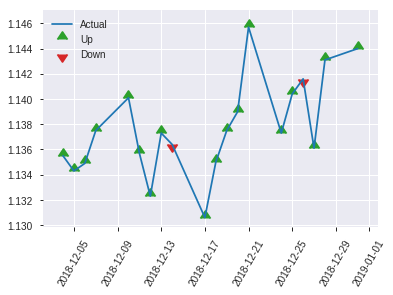


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18536448525023547
RMSE: 0.4305397603592907
LogLoss: 0.5425838234798206
Mean Per-Class Error: 0.29740957966764414
AUC: 0.7889173998044966
pr_auc: 0.810310661105311
Gini: 0.5778347996089932
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37062737345695496: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   71   0.5726   (71.0/124.0)
1      9    123  0.0682   (9.0/132.0)
Total  62   194  0.3125   (80.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.370627     0.754601  193
max f2                       0.227173     0.866402  227
max f0point5                 0.769697     0.725309  47
max accuracy                 0.544022     0.703125  133
max precision                0.949241     1         0
max recall                   0.0808023    1         246
max specificity              0.949241     1         0
max absolute_mcc             0.769697     0.445574  47
max min_per_class_accuracy   0.548126     0.693548  129
max mean_per_class_accuracy  0.544022     0.70259   133

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 53.11 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.927563           1.93939    1.93939            1                0.939302  1                           0.939302            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.911412           1.93939    1.93939            1                0.917082  1                           0.928192            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.887852           1.93939    1.93939            1                0.896525  1                           0.920275            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.882114           1.93939    1.93939            1                0.884317  1                           0.910469            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.877155           1.93939    1.93939            1                0.879678  1                           0.905732            0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.854599           1.93939    1.93939            1                0.86654   1                           0.886136            0.0984848       0.19697                    93.9394   93.9394
    7        0.152344                    0.81269            1.79021    1.88967            0.923077         0.832572  0.974359                    0.868281            0.0909091       0.287879                   79.021    88.9666
    8        0.203125                    0.755771           1.49184    1.79021            0.769231         0.780085  0.923077                    0.846232            0.0757576       0.363636                   49.1841   79.021
    9        0.300781                    0.656724           1.16364    1.58678            0.6              0.70067   0.818182                    0.798972            0.113636        0.477273                   16.3636   58.6777
    10       0.402344                    0.588047           1.04429    1.44984            0.538462         0.618621  0.747573                    0.753446            0.106061        0.583333                   4.4289    44.9838
    11       0.5                         0.548823           1.08606    1.37879            0.56             0.567388  0.710938                    0.717107            0.106061        0.689394                   8.60606   37.8788
    12       0.601562                    0.477062           0.820513   1.28453            0.423077         0.519787  0.662338                    0.683793            0.0833333       0.772727                   -17.9487  28.4534
    13       0.699219                    0.417367           1.00848    1.24598            0.52             0.446098  0.642458                    0.650595            0.0984848       0.871212                   0.848485  24.5979
    14       0.800781                    0.337112           0.745921   1.18256            0.384615         0.380051  0.609756                    0.616282            0.0757576       0.94697                    -25.4079  18.2557
    15       0.898438                    0.177731           0.465455   1.10461            0.24             0.28099   0.569565                    0.579838            0.0454545       0.992424                   -53.4545  10.4611
    16       1                           0.0508635          0.0745921  1                  0.0384615        0.100143  0.515625                    

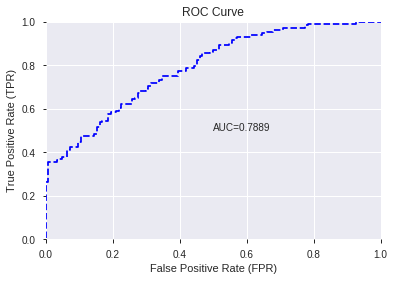

This function is available for GLM models only


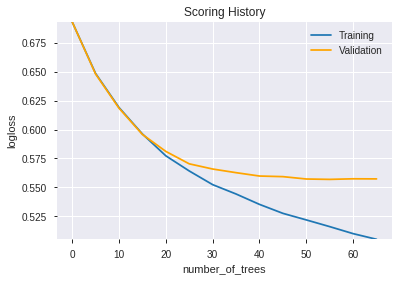

--2019-07-25 12:54:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.121.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.121.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_125406_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_125406_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLDRAGONFLYDOJI',
 'MINUS_DI_8',
 'CDLGRAVESTONEDOJI',
 'ULTOSC',
 'WILLR_8',
 'STOCHF_fastk',
 'PLUS_DI_8',
 'STOCH_slowk',
 'CDLTAKURI',
 'STOCHF_fastd',
 'CDLINVERTEDHAMMER',
 'CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD',
 'CDLSHOOTINGSTAR',
 'CDLHAMMER',
 'CDLHANGINGMAN']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

727

['BBANDS_upperband_8_8_2',
 'BBANDS_middleband_8_8_2',
 'BBANDS_lowerband_8_8_2',
 'BBANDS_upperband_8_8_3',
 'BBANDS_middleband_8_8_3',
 'BBANDS_lowerband_8_8_3',
 'BBANDS_upperband_8_8_4',
 'BBANDS_middleband_8_8_4',
 'BBANDS_lowerband_8_8_4',
 'BBANDS_upperband_8_8_5',
 'BBANDS_middleband_8_8_5',
 'BBANDS_lowerband_8_8_5',
 'DEMA_12',
 'EMA_12',
 'KAMA_12',
 'MIDPOINT_12',
 'MIDPRICE_12',
 'SAR_0.12',
 'SMA_12',
 'TEMA_12',
 'TRIMA_12',
 'WMA_12',
 'MA_12_0',
 'MAVP_12_0',
 'BBANDS_upperband_12_0_2',
 'BBANDS_middleband_12_0_2',
 'BBANDS_lowerband_12_0_2',
 'BBANDS_upperband_12_0_3',
 'BBANDS_middleband_12_0_3',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_upperband_12_0_4',
 'BBANDS_middleband_12_0_4',
 'BBANDS_lowerband_12_0_4',
 'BBANDS_upperband_12_0_5',
 'BBANDS_middleband_12_0_5',
 'BBANDS_lowerband_12_0_5',
 'MA_12_1',
 'MAVP_12_1',
 'BBANDS_upperband_12_1_2',
 'BBANDS_middleband_12_1_2',
 'BBANDS_lowerband_12_1_2',
 'BBANDS_upperband_12_1_3',
 'BBANDS_middleband_12_1_3',
 'BBANDS_lo

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_125551_model_9  0.807979  0.535793              0.266740  0.426603  0.181990
1  DeepLearning_grid_1_AutoML_20190725_125551_model_8  0.798204  0.566674              0.287879  0.439089  0.192799
2  DeepLearning_grid_1_AutoML_20190725_125551_model_3  0.791178  1.485651              0.328690  0.537426  0.288827
3  DeepLearning_grid_1_AutoML_20190725_125551_model_6  0.790017  0.553344              0.282380  0.434308  0.188623
4  DeepLearning_grid_1_AutoML_20190725_125551_model_7  0.785496  0.555527              0.304741  0.435668  0.189806
5  DeepLearning_grid_1_AutoML_20190725_125551_model_5  0.780731  0.553893              0.296432  0.435604  0.189751
6  DeepLearning_grid_1_AutoML_20190725_125551_model_2  0.778409  0.699251              0.285679  0.484298  0.234544
7  DeepLearning_grid_1_AutoML_20190725_125551_model_4  0.735032  0.726893              0.369257  0.490670  0.240757
8  DeepLearning_grid_1_AutoML_20190725_125551_model_1  0.728189  1.167270              0.344086  0.549336  0.301770
9               DeepLearning_1_AutoML_20190725_125551  0.712915  0.613701              0.334189  0.462224  0.213651

variable  relative_importance  scaled_importance  percentage
0           CDLGRAVESTONEDOJI             1.000000           1.000000    0.008096
1            CDLDRAGONFLYDOJI             0.953334           0.953334    0.007719
2                   CDLTAKURI             0.879260           0.879260    0.007119
3                STOCHF_fastk             0.704746           0.704746    0.005706
4          CDLCLOSINGMARUBOZU             0.617777           0.617777    0.005002
..                        ...                  ...                ...         ...
721  BBANDS_middleband_12_7_3             0.122506           0.122506    0.000992
722   BBANDS_lowerband_12_6_2             0.121600           0.121600    0.000985
723  BBANDS_middleband_20_2_3             0.120255           0.120255    0.000974
724                CDL3INSIDE             0.112785           0.112785    0.000913
725       CDLXSIDEGAP3METHODS             0.106935           0.106935    0.000866

[726 rows x 4 columns]

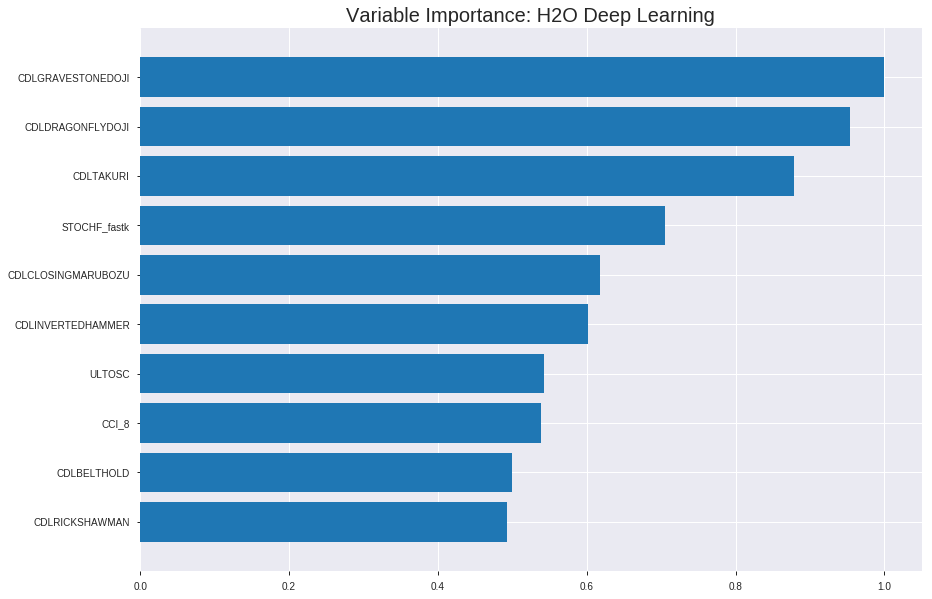

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_125551_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1693361197715806
RMSE: 0.4115047020042184
LogLoss: 0.5138542616040757
Mean Per-Class Error: 0.25919172932330825
AUC: 0.8321303258145364
pr_auc: 0.8344671062585268
Gini: 0.6642606516290728
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4716422608172419: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      462  413   0.472    (413.0/875.0)
1      72   840   0.0789   (72.0/912.0)
Total  534  1253  0.2714   (485.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471642     0.775982  239
max f2                       0.372657     0.874555  278
max f0point5                 0.578139     0.765247  168
max accuracy                 0.539887     0.739228  188
max precision                0.998415     1         0
max recall                   2.06996e-07  1         399
max specificity              0.998415     1         0
max absolute_mcc             0.471642     0.490402  239
max min_per_class_accuracy   0.510624     0.726857  205
max mean_per_class_accuracy  0.539887     0.740808  188

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 51.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.981995           1.95943   1.95943            1                0.987815   1                           0.987815            0.0197368       0.0197368                  95.943    95.943
    2        0.0201455                   0.976217           1.85057   1.905              0.944444         0.97975    0.972222                    0.983783            0.0186404       0.0383772                  85.0573   90.5001
    3        0.0302182                   0.965892           1.74172   1.85057            0.888889         0.971828   0.944444                    0.979798            0.0175439       0.0559211                  74.1715   85.0573
    4        0.040291                    0.959256           1.85057   1.85057            0.944444         0.963035   0.944444                    0.975607            0.0186404       0.0745614                  85.0573   85.0573
    5        0.0503637                   0.953379           1.95943   1.87234            1                0.956427   0.955556                    0.971771            0.0197368       0.0942982                  95.943    87.2344
    6        0.100168                    0.896389           1.82733   1.84996            0.932584         0.928933   0.944134                    0.950472            0.0910088       0.185307                   82.7333   84.9964
    7        0.149972                    0.822414           1.89338   1.86438            0.966292         0.860546   0.951493                    0.920609            0.0942982       0.279605                   89.3382   86.4383
    8        0.200336                    0.735009           1.61109   1.80071            0.822222         0.780762   0.918994                    0.885451            0.0811404       0.360746                   61.1087   80.0705
    9        0.299944                    0.612965           1.47508   1.69257            0.752809         0.665876   0.863806                    0.812533            0.14693         0.507675                   47.5076   69.2567
    10       0.400112                    0.555105           1.22601   1.57577            0.625698         0.583189   0.804196                    0.755116            0.122807        0.630482                   22.6012   57.5765
    11       0.50028                     0.511527           0.941402  1.44875            0.480447         0.529958   0.739374                    0.710034            0.0942982       0.724781                   -5.8598   44.8751
    12       0.599888                    0.49516            0.979715  1.37087            0.5              0.502114   0.699627                    0.67551             0.0975877       0.822368                   -2.02851  37.087
    13       0.700056                    0.471417           0.974242  1.31412            0.497207         0.48573    0.670663                    0.648355            0.0975877       0.919956                   -2.57584  31.4118
    14       0.799664                    0.340298           0.50637   1.2135             0.258427         0.419954   0.619314                    0.619905            0.0504386       0.970395                   -49.363   21.3503
    15       0.899832                    0.0721269          0.175145  1.09791            0.0893855        0.196668   0.560323                    0.572791            0.0175439       0.987939                   -82.4855  9.79143
    16       1                           2.06996e-07        0.120412  1                  0.0614525        0.0329504  0.510353                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18792267166814075
RMSE: 0.43350048635283067
LogLoss: 0.5537358115187289
Mean Per-Class Error: 0.2680716430716431
AUC: 0.809707666850524
pr_auc: 0.8066360926249443
Gini: 0.619415333701048
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5090169536104274: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      154  105  0.4054   (105.0/259.0)
1      35   217  0.1389   (35.0/252.0)
Total  189  322  0.274    (140.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.509017     0.756098  244
max f2                       0.451496     0.854004  300
max f0point5                 0.56782      0.739051  171
max accuracy                 0.545866     0.731898  198
max precision                0.974854     1         0
max recall                   0.02767      1         396
max specificity              0.974854     1         0
max absolute_mcc             0.511542     0.472184  240
max min_per_class_accuracy   0.545866     0.730159  198
max mean_per_class_accuracy  0.545473     0.731928  199

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 53.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.956303           2.02778   2.02778            1                0.963433   1                           0.963433            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.941584           2.02778   2.02778            1                0.948389   1                           0.956595            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.923552           2.02778   2.02778            1                0.93125    1                           0.948675            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.899469           2.02778   2.02778            1                0.909623   1                           0.939377            0.0198413       0.0833333                  102.778   102.778
    5        0.0508806                   0.891463           2.02778   2.02778            1                0.894257   1                           0.9307              0.0198413       0.103175                   102.778   102.778
    6        0.101761                    0.853654           1.71581   1.87179            0.846154         0.873423   0.923077                    0.902062            0.0873016       0.190476                   71.5812   87.1795
    7        0.150685                    0.787098           1.78444   1.84343            0.88             0.823038   0.909091                    0.876404            0.0873016       0.277778                   78.4444   84.3434
    8        0.201566                    0.668433           1.48184   1.75216            0.730769         0.722619   0.864078                    0.837585            0.0753968       0.353175                   48.1838   75.2157
    9        0.30137                     0.599392           1.47113   1.65909            0.72549          0.627677   0.818182                    0.76807             0.146825        0.5                        47.1133   65.9091
    10       0.401174                    0.570224           1.23257   1.55298            0.607843         0.582843   0.765854                    0.721989            0.123016        0.623016                   23.2571   55.2981
    11       0.500978                    0.544685           1.11329   1.46539            0.54902          0.557662   0.722656                    0.689252            0.111111        0.734127                   11.329    46.5386
    12       0.600783                    0.517537           0.914488  1.37387            0.45098          0.530688   0.677524                    0.662911            0.0912698       0.825397                   -8.5512   37.3869
    13       0.700587                    0.483805           0.755447  1.28577            0.372549         0.501779   0.634078                    0.639956            0.0753968       0.900794                   -24.4553  28.577
    14       0.800391                    0.444543           0.556645  1.19485            0.27451          0.467218   0.589242                    0.618417            0.0555556       0.956349                   -44.3355  19.4852
    15       0.900196                    0.162629           0.318083  1.09764            0.156863         0.313012   0.541304                    0.584557            0.031746        0.988095                   -68.1917  9.76449
    16       1                           0.0132634          0.119281  1                  0.0588235        0.0841388  0.493151                    


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 13:14:37  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 13:14:39  6 min 28.697 sec   175 obs/sec       0.265249  1             474        0.631901         1.84011             -0.597881      0.553499        0.503856           1.08857          0.48629                          0.711334           3.86207               -1.02437         0.539246          0.526993             1.01389            0.495108
    2019-07-25 13:15:17  7 min  6.693 sec   252 obs/sec       5.20313   19            9298       0.470153         0.632579            0.115447       0.721638        0.712773           1.74172          0.371572                         0.493765           0.680733              0.0246018        0.766172          0.768099             2.02778            0.324853
    2019-07-25 13:15:57  7 min 46.098 sec   272 obs/sec       11.0431   40            19734      0.451805         0.595459            0.183138       0.786269        0.781085           1.74172          0.302182                         0.471957           0.637629              0.108858         0.805418          0.800962             2.02778            0.320939
    2019-07-25 13:16:35  8 min 24.859 sec   283 obs/sec       17.042    62            30454      0.448207         0.586543            0.196096       0.805239        0.800603           1.85057          0.276441                         0.472441           0.637386              0.107029         0.798102          0.794314             2.02778            0.287671
    2019-07-25 13:17:15  9 min  4.665 sec   292 obs/sec       23.4348   85            41878      0.442266         0.573677            0.217267       0.772805        0.77227            1.85057          0.30554                          0.4623             0.614376              0.144953         0.775395          0.778786             2.02778            0.313112
    2019-07-25 13:17:54  9 min 43.856 sec   299 obs/sec       29.9754   109           53566      0.4294           0.547593            0.262147       0.803915        0.810797           1.85057          0.310017                         0.444262           0.578495              0.210377         0.804207          0.803599             2.02778            0.299413
    2019-07-25 13:18:34  10 min 23.204 sec  304 obs/sec       36.4997   133           65225      0.43229          0.553893            0.25218        0.826008        0.826978           1.85057          0.27812                          0.457953           0.608143              0.160958         0.801618          0.804093             2.02778            0.322896
    2019-07-25 13:19:13  11 min  2.492 sec  308 obs/sec       43.0476   157           76926      0.429372         0.548179            0.262244       0.820489        0.823115           1.85057          0.295467                         0.438655           0.567941              0.230181         0.812918          0.807516             2.02778            0.303327
    2019-07-

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLGRAVESTONEDOJI         1.0                    1.0                  0.008096448916054865
CDLDRAGONFLYDOJI          0.9533337354660034     0.9533337354660034   0.007718617889152258
CDLTAKURI                 0.8792595267295837     0.8792595267295837   0.007118879842120652
STOCHF_fastk              0.7047455906867981     0.7047455906867981   0.005705936673810572
CDLCLOSINGMARUBOZU        0.6177771687507629     0.6177771687507629   0.005001801288295558
---                       ---                    ---                  ---
BBANDS_middleband_12_7_3  0.12250550091266632    0.12250550091266632  0.0009918595300751154
BBANDS_lowerband_12_6_2   0.12159989029169083    0.12159989029169083  0.0009845272999445505
BBANDS_middleband_20_2_3  0.1202550083398819     0.1202550083398819   0.0009736385319236055
CDL3INSIDE                0.11278548091650009    0.11278548091650009  0.0009131618847131237
CDLXSIDEGAP3METHODS       0.10693535208702087    0.10693535208702087  0.0008657966154929054


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.74609375)

('F1', 0.7788778877887789)

('auc', 0.8079789833822092)

('logloss', 0.5357931021211231)

('mean_per_class_error', 0.2569648093841642)

('rmse', 0.42660276373761136)

('mse', 0.18198991802856823)

deeplearning prediction progress: |███████████████████████████████████████| 100%


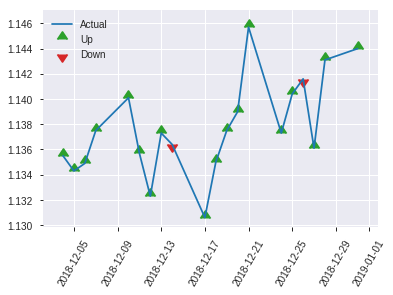


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18198991802856823
RMSE: 0.42660276373761136
LogLoss: 0.5357931021211231
Mean Per-Class Error: 0.2569648093841642
AUC: 0.8079789833822092
pr_auc: 0.8110726708298936
Gini: 0.6159579667644184
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4768307080633096: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   53   0.4274   (53.0/124.0)
1      14   118  0.1061   (14.0/132.0)
Total  85   171  0.2617   (67.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476831     0.778878  170
max f2                       0.393498     0.883152  207
max f0point5                 0.490336     0.738032  154
max accuracy                 0.490336     0.746094  154
max precision                0.981738     1         0
max recall                   0.0288319    1         254
max specificity              0.981738     1         0
max absolute_mcc             0.486725     0.499733  158
max min_per_class_accuracy   0.512311     0.712121  128
max mean_per_class_accuracy  0.490336     0.743035  154

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 52.04 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.969867           1.93939    1.93939            1                0.974554   1                           0.974554            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.960718           1.93939    1.93939            1                0.965517   1                           0.970036            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.952598           1.93939    1.93939            1                0.954157   1                           0.966066            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.935628           1.93939    1.93939            1                0.945104   1                           0.960349            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.922924           1.93939    1.93939            1                0.928182   1                           0.9554              0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.838663           1.93939    1.93939            1                0.880977   1                           0.918189            0.0984848       0.19697                    93.9394   93.9394
    7        0.152344                    0.745151           1.64103    1.83994            0.846154         0.794367   0.948718                    0.876915            0.0833333       0.280303                   64.1026   83.9938
    8        0.203125                    0.636366           1.49184    1.75291            0.769231         0.689844   0.903846                    0.830147            0.0757576       0.356061                   49.1841   75.2914
    9        0.300781                    0.576086           0.930909   1.48603            0.48             0.597262   0.766234                    0.754535            0.0909091       0.44697                    -6.90909  48.6029
    10       0.402344                    0.540625           1.26807    1.43101            0.653846         0.554699   0.737864                    0.704091            0.128788        0.575758                   26.8065   43.1009
    11       0.5                         0.513244           1.31879    1.40909            0.68             0.526798   0.726562                    0.669464            0.128788        0.704545                   31.8788   40.9091
    12       0.601562                    0.491069           1.26807    1.38528            0.653846         0.50086    0.714286                    0.640998            0.128788        0.833333                   26.8065   38.5281
    13       0.699219                    0.471132           0.775758   1.30015            0.4              0.480137   0.670391                    0.618531            0.0757576       0.909091                   -22.4242  30.0152
    14       0.800781                    0.423749           0.671329   1.2204             0.346154         0.453283   0.629268                    0.597573            0.0681818       0.977273                   -32.8671  22.0399
    15       0.898438                    0.219704           0.155152   1.10461            0.08             0.34715    0.569565                    0.570353            0.0151515       0.992424                   -84.4848  10.4611
    16       1                           0.0256863          0.0745921  1                  0.0384615        0.0784556  0.515625 

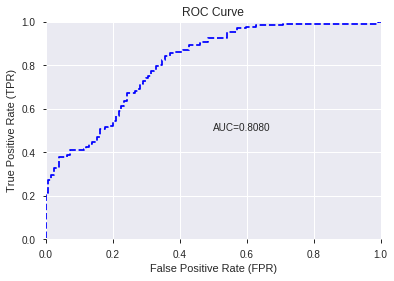

This function is available for GLM models only


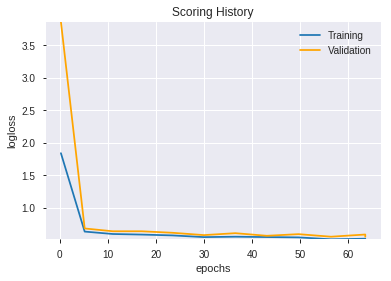

--2019-07-25 13:21:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.99.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.99.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_125551_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_125551_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CDLINVERTEDHAMMER',
 'ULTOSC',
 'CCI_8',
 'CDLBELTHOLD',
 'CDLRICKSHAWMAN',
 'MINUS_DI_8',
 'CDLSHOOTINGSTAR',
 'PLUS_DI_8',
 'CDLHANGINGMAN',
 'MINUS_DM_8',
 'DIV',
 'CDLLONGLEGGEDDOJI',
 'TRANGE',
 'CDLDOJI',
 'CCI_14',
 'CCI_12',
 'CDLHIKKAKE',
 'CORREL_8',
 'PLUS_DM_8',
 'WILLR_8',
 'aroonup_8',
 'CDLHAMMER',
 'WILLR_12',
 'WILLR_14',
 'CCI_20',
 'PLUS_DM_12',
 'MINUS_DI_12',
 'PLUS_DI_12',
 'STOCHRSI_fastk',
 'CCI_24',
 'CCI_30',
 'aroonup_12',
 'PLUS_DM_14',
 'aroonup_24',
 'DX_8',
 'PLUS_DI_14',
 'AROONOSC_12',
 'aroonup_20',
 'CDLMATCHINGLOW',
 'CDLHIGHWAVE',
 'CDLSPINNINGTOP',
 'HT_TRENDMODE',
 'MINUS_DI_14',
 'BETA_24',
 'STOCHF_fastd',
 'AROONOSC_8',
 'HT_DCPERIOD',
 'STDDEV_8',
 'DX_12',
 'DX_14',
 'CDLSTICKSANDWICH',
 'CDLSEPARATINGLINES',
 'ADXR_12',
 'ADXR_14',
 'MINUS_DM_14',
 'CORREL_20',
 'PLUS_DI_30',
 'LINEARREG_ANGLE_8',
 'STOCH_slowk',
 'STOCHRSI_fastd',
 'CDLHIKKAKE

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_132135_model_1  0.810545  0.525851              0.284335  0.421441  0.177612

variable  relative_importance  scaled_importance    percentage
0                       CCI_8             0.415827           1.000000  2.441195e-02
1                STOCHF_fastk             0.405329           0.974754  2.379564e-02
2           CDLGRAVESTONEDOJI             0.370276           0.890457  2.173778e-02
3                  MINUS_DI_8             0.321888           0.774092  1.889708e-02
4            CDLDRAGONFLYDOJI             0.289657           0.696581  1.700489e-02
..                        ...                  ...                ...           ...
721   BBANDS_upperband_12_1_3             0.000115           0.000276  6.746226e-06
722   BBANDS_upperband_24_1_3             0.000109           0.000262  6.388576e-06
723   BBANDS_lowerband_20_3_4             0.000078           0.000187  4.555992e-06
724  BBANDS_middleband_30_5_4             0.000068           0.000164  4.006931e-06
725  BBANDS_middleband_30_5_5             0.000016           0.000040  9.686329e-07

[726 rows x 4 columns]

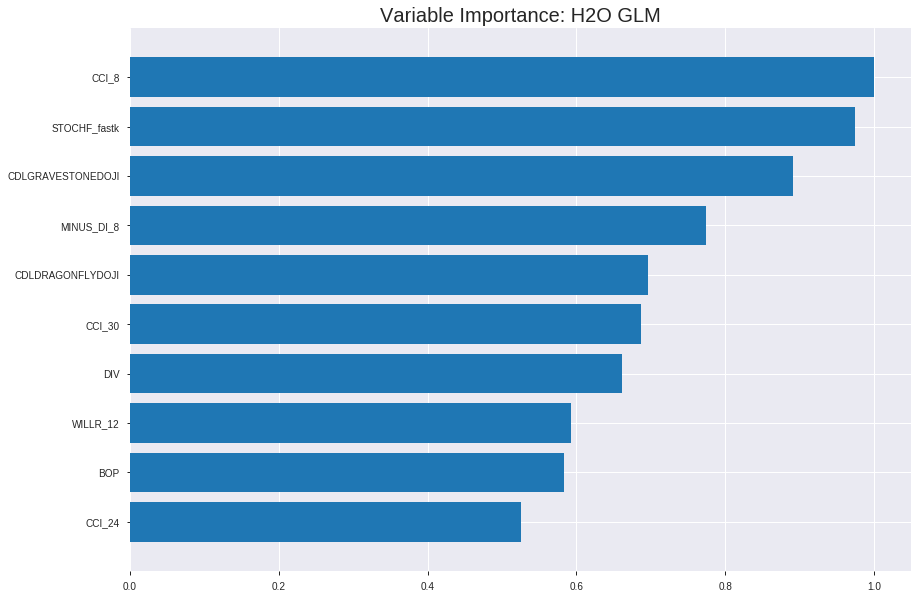

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_132135_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17190389978679047
RMSE: 0.4146129517836973
LogLoss: 0.5135673692914489
Null degrees of freedom: 1786
Residual degrees of freedom: 1060
Null deviance: 2476.5418801583887
Residual deviance: 1835.4897778476384
AIC: 3289.4897778476384
AUC: 0.8260200501253132
pr_auc: 0.8289569058739829
Gini: 0.6520401002506264
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40529599924966575: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      474  401   0.4583   (401.0/875.0)
1      91   821   0.0998   (91.0/912.0)
Total  565  1222  0.2753   (492.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405296     0.769447  255
max f2                       0.29418      0.867987  302
max f0point5                 0.589614     0.756615  159
max accuracy                 0.507979     0.740907  204
max precision                0.996693     1         0
max recall                   0.0318025    1         390
max specificity              0.996693     1         0
max absolute_mcc             0.456512     0.483605  231
max min_per_class_accuracy   0.519523     0.734857  196
max mean_per_class_accuracy  0.507979     0.740367  204

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 51.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100727                   0.965478           1.95943   1.95943            1                0.978691   1                           0.978691            0.0197368       0.0197368                  95.943     95.943
    2        0.0201455                   0.953077           1.85057   1.905              0.944444         0.958604   0.972222                    0.968647            0.0186404       0.0383772                  85.0573    90.5001
    3        0.0302182                   0.940983           1.85057   1.88686            0.944444         0.947152   0.962963                    0.961482            0.0186404       0.0570175                  85.0573    88.6858
    4        0.040291                    0.92821            1.95943   1.905              1                0.93527    0.972222                    0.954929            0.0197368       0.0767544                  95.943     90.5001
    5        0.0503637                   0.914888           1.85057   1.89412            0.944444         0.920326   0.966667                    0.948009            0.0186404       0.0953947                  85.0573    89.4115
    6        0.100168                    0.859015           1.84935   1.87186            0.94382          0.888591   0.955307                    0.918466            0.0921053       0.1875                     84.9349    87.1858
    7        0.149972                    0.786981           1.71725   1.82052            0.876404         0.823231   0.929104                    0.886839            0.0855263       0.273026                   71.7253    82.0515
    8        0.200336                    0.723646           1.71994   1.79523            0.877778         0.752547   0.916201                    0.853079            0.0866228       0.359649                   71.9944    79.5232
    9        0.299944                    0.644134           1.35399   1.6487             0.691011         0.679006   0.841418                    0.795271            0.134868        0.494518                   35.3988    64.8699
    10       0.400112                    0.575516           1.28074   1.55658            0.653631         0.608631   0.794406                    0.748546            0.128289        0.622807                   28.0745    55.6582
    11       0.50028                     0.521169           1.07276   1.45971            0.547486         0.548166   0.744966                    0.708425            0.107456        0.730263                   7.27605    45.9709
    12       0.599888                    0.46226            0.990723  1.38184            0.505618         0.493809   0.705224                    0.672789            0.0986842       0.828947                   -0.927705  38.1837
    13       0.700056                    0.39011            0.788151  1.29689            0.402235         0.426393   0.661871                    0.637533            0.0789474       0.907895                   -21.1849   29.6889
    14       0.799664                    0.305249           0.583426  1.20802            0.297753         0.352866   0.616515                    0.602075            0.058114        0.966009                   -41.6574   20.8018
    15       0.899832                    0.127              0.207984  1.0967             0.106145         0.226626   0.559701                    0.56028             0.0208333       0.986842                   -79.2016   9.66958
    16       1                           0.00365226         0.131358  1                  0.0670391        0.0618401  0.510353   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17409351276555132
RMSE: 0.41724514708448235
LogLoss: 0.523874787526271
Null degrees of freedom: 510
Residual degrees of freedom: -216
Null deviance: 708.9054443622276
Residual deviance: 535.4000328518489
AIC: 1989.400032851849
AUC: 0.8212140712140713
pr_auc: 0.8122231704172634
Gini: 0.6424281424281426
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3690432247141206: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      149  110  0.4247   (110.0/259.0)
1      28   224  0.1111   (28.0/252.0)
Total  177  334  0.2701   (138.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369043     0.764505  256
max f2                       0.181294     0.847872  328
max f0point5                 0.547255     0.76107   164
max accuracy                 0.509018     0.749511  186
max precision                0.990463     1         0
max recall                   0.0337404    1         387
max specificity              0.990463     1         0
max absolute_mcc             0.509018     0.49948   186
max min_per_class_accuracy   0.473959     0.738095  198
max mean_per_class_accuracy  0.509018     0.749035  186

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 48.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.9766             1.68981   1.68981            0.833333         0.981065   0.833333                    0.981065            0.0198413       0.0198413                  68.9815   68.9815
    2        0.0215264                   0.963858           2.02778   1.84343            1                0.970846   0.909091                    0.97642             0.0198413       0.0396825                  102.778   84.3434
    3        0.0313112                   0.942747           2.02778   1.90104            1                0.949569   0.9375                      0.968029            0.0198413       0.0595238                  102.778   90.1042
    4        0.0410959                   0.935106           2.02778   1.93122            1                0.939204   0.952381                    0.961166            0.0198413       0.0793651                  102.778   93.1217
    5        0.0508806                   0.924859           2.02778   1.94979            1                0.927909   0.961538                    0.954771            0.0198413       0.0992063                  102.778   94.9786
    6        0.101761                    0.867831           2.02778   1.98878            1                0.893085   0.980769                    0.923928            0.103175        0.202381                   102.778   98.8782
    7        0.150685                    0.813249           1.46      1.8171             0.72             0.835952   0.896104                    0.895364            0.0714286       0.27381                    46        81.71
    8        0.201566                    0.745054           1.71581   1.79153            0.846154         0.781815   0.883495                    0.866701            0.0873016       0.361111                   71.5812   79.1532
    9        0.30137                     0.63661            1.43137   1.67226            0.705882         0.687012   0.824675                    0.807194            0.142857        0.503968                   43.1373   67.2258
    10       0.401174                    0.550609           1.39161   1.60244            0.686275         0.587711   0.790244                    0.752591            0.138889        0.642857                   39.1612   60.2439
    11       0.500978                    0.469724           0.954248  1.47331            0.470588         0.512347   0.726562                    0.704729            0.0952381       0.738095                   -4.57516  47.3307
    12       0.600783                    0.408457           1.03377   1.40029            0.509804         0.439822   0.690554                    0.660722            0.103175        0.84127                    3.37691   40.029
    13       0.700587                    0.340983           0.636166  1.29143            0.313725         0.373524   0.636872                    0.619808            0.0634921       0.904762                   -36.3834  29.1434
    14       0.800391                    0.235892           0.357843  1.17502            0.176471         0.293571   0.579462                    0.579128            0.0357143       0.940476                   -64.2157  17.502
    15       0.900196                    0.0927021          0.397603  1.08883            0.196078         0.159454   0.536957                    0.532599            0.0396825       0.980159                   -60.2397  8.88285
    16       1                           0.000369793        0.198802  1                  0.0980392        0.0466581  0.493151                    0.4


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-07-25 13:21:38  0.000 sec   2            .16E2     611           1.364647612068712   1.365443711782464
     2019-07-25 13:21:39  1.167 sec   4            .12E2     631           1.3576988048069485  1.3581117466394144
     2019-07-25 13:21:40  2.342 sec   6            .84E1     666           1.3488415101812583  1.348652257937491
     2019-07-25 13:21:41  3.560 sec   8            .61E1     706           1.3377402429889254  1.336618001431284
     2019-07-25 13:21:42  4.726 sec   10           .45E1     723           1.3241357362830246  1.3217446383201576
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-07-25 13:22:04  26.628 sec  46           .15E-1    727           1.0184055360170083  1.0478091126582296
     2019-07-25 13:22:06  27.877 sec  48           .11E-1    727           1.010833799641712   1.048791804195969
     2019-07-25 13:22:07  29.094 sec  50           .78E-2    727           1.0041604953460996  1.050334838569129
     2019-07-25 13:22:08  30.380 sec  52           .57E-2    727           0.9982028005266048  1.0523160580650186
     2019-07-25 13:22:09  31.585 sec  54           .41E-2    727           0.9928474496343387  1.0544615454326924


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.73046875)

('F1', 0.7774294670846396)

('auc', 0.8105449657869012)

('logloss', 0.5258511790279015)

('mean_per_class_error', 0.2718719452590421)

('rmse', 0.421440726687159)

('mse', 0.17761228611060065)

glm prediction progress: |████████████████████████████████████████████████| 100%


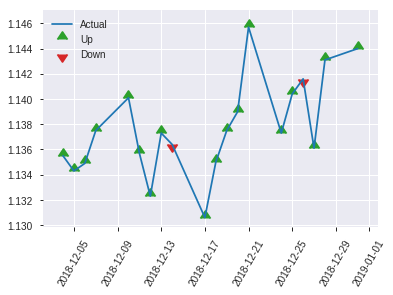


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.17761228611060065
RMSE: 0.421440726687159
LogLoss: 0.5258511790279015
Null degrees of freedom: 255
Residual degrees of freedom: -471
Null deviance: 354.6697985653149
Residual deviance: 269.23580366228555
AIC: 1723.2358036622854
AUC: 0.8105449657869012
pr_auc: 0.8146891534806263
Gini: 0.6210899315738023
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3489964604115375: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      61   63   0.5081   (63.0/124.0)
1      8    124  0.0606   (8.0/132.0)
Total  69   187  0.2773   (71.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348996     0.777429  186
max f2                       0.267446     0.883152  207
max f0point5                 0.553547     0.746124  95
max accuracy                 0.443664     0.730469  148
max precision                0.977373     1         0
max recall                   0.0378435    1         252
max specificity              0.977373     1         0
max absolute_mcc             0.348996     0.485805  186
max min_per_class_accuracy   0.484654     0.693548  129
max mean_per_class_accuracy  0.443664     0.728128  148

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 49.07 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.960019           1.93939    1.93939            1                0.970802   1                           0.970802            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.946812           1.93939    1.93939            1                0.953408   1                           0.962105            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.922767           1.93939    1.93939            1                0.929771   1                           0.954021            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.909943           1.93939    1.93939            1                0.915711   1                           0.943573            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.905407           1.93939    1.93939            1                0.90789    1                           0.938084            0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.848318           1.79021    1.8648             0.923077         0.873022   0.961538                    0.905553            0.0909091       0.189394                   79.021    86.4802
    7        0.152344                    0.753105           1.79021    1.83994            0.923077         0.808374   0.948718                    0.87316             0.0909091       0.280303                   79.021    83.9938
    8        0.203125                    0.69387            1.34266    1.71562            0.692308         0.721667   0.884615                    0.835286            0.0681818       0.348485                   34.2657   71.5618
    9        0.300781                    0.609222           1.24121    1.56159            0.64             0.655528   0.805195                    0.776923            0.121212        0.469697                   24.1212   56.159
    10       0.402344                    0.541766           1.26807    1.4875             0.653846         0.571084   0.76699                     0.724964            0.128788        0.598485                   26.8065   48.7496
    11       0.5                         0.486602           0.930909   1.37879            0.48             0.516341   0.710938                    0.684217            0.0909091       0.689394                   -6.90909  37.8788
    12       0.601562                    0.427296           1.26807    1.36009            0.653846         0.461331   0.701299                    0.646587            0.128788        0.818182                   26.8065   36.0094
    13       0.699219                    0.364702           0.930909   1.30015            0.48             0.392177   0.670391                    0.611055            0.0909091       0.909091                   -6.90909  30.0152
    14       0.800781                    0.296689           0.596737   1.21094            0.307692         0.333329   0.62439                     0.575831            0.0606061       0.969697                   -40.3263  21.0939
    15       0.898438                    0.160966           0.232727   1.10461            0.12             0.231252   0.569565                    0.538377            0.0227273       0.992424                   -76.7273  10.4611
    16       1                           0.0316719          0.0745921  1                  0.0384615        0.0691321  0.515625  

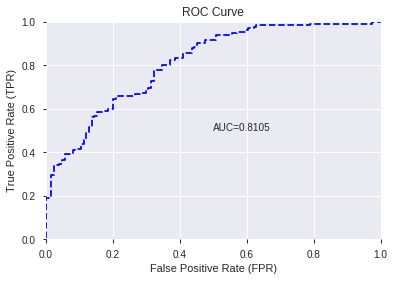

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


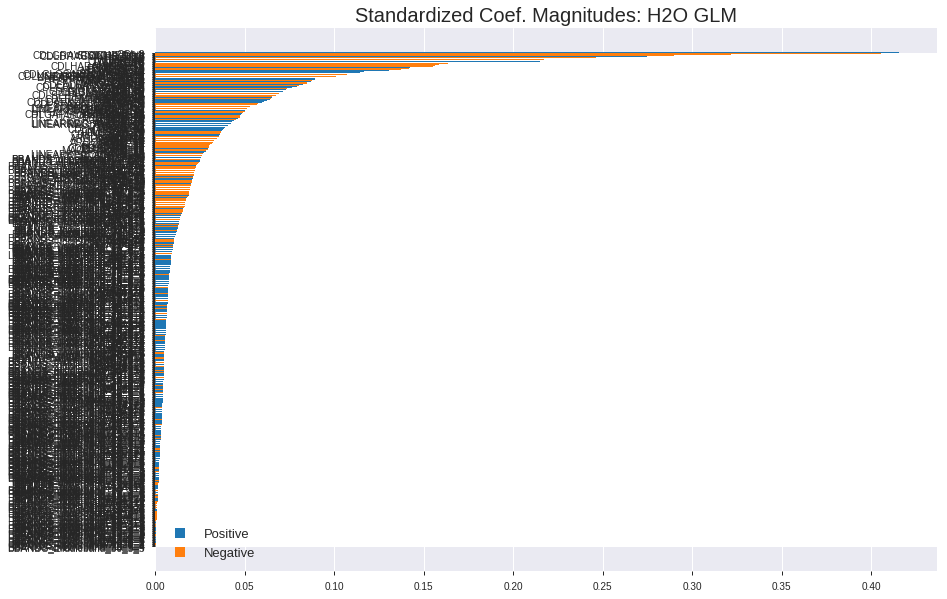

'log_likelihood'
--2019-07-25 13:22:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_132135_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_132135_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CCI_8',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'MINUS_DI_8',
 'CDLDRAGONFLYDOJI',
 'CCI_30',
 'DIV',
 'WILLR_12',
 'BOP',
 'CCI_24',
 'WILLR_14',
 'PLUS_DI_8',
 'CDLTAKURI',
 'CCI_20',
 'CCI_14',
 'ULTOSC',
 'TAN',
 'WILLR_8',
 'aroonup_12',
 'CDLHARAMICROSS',
 'WILLR_24',
 'PLUS_DM_8',
 'BETA_8',
 'CORREL_30',
 'MINUS_DI_12',
 'WILLR_20',
 'BETA_24',
 'CCI_12',
 'STOCH_slowd',
 'AROONOSC_12',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DI_12',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_8',
 'CDLXSIDEGAP3METHODS',
 'CDLSPINNINGTOP',
 'MINUS_DM_24',
 'MEDPRICE',
 'HT_PHASOR_inphase',
 'PLUS_DI_14',
 'MINUS_DI_14',
 'MINUS_DM_8',
 'ADD',
 'ADXR_8',
 'CMO_8',
 'RSI_8',
 'CDLADVANCEBLOCK',
 'CDLHANGINGMAN',
 'SAR_0.12',
 'RSI_12',
 'CDLCOUNTERATTACK',
 'MINUS_DM_20',
 'CORREL_20',
 'CMO_12',
 'DX_30',
 'CDLRICKSHAWMAN',
 'VAR_30',
 'CDL3LINESTRIKE',
 'CORREL_8',
 'SAR_0.14',
 'CMO_14',
 'CDLSEPARATINGLINES',
 'RSI_14',
 'aroonup_20',
 'MIDPRICE_20',
 'CDLTASUKIGAP',
 'VAR_12',
 'ADX_8',
 'CDLHOMINGPIGEO

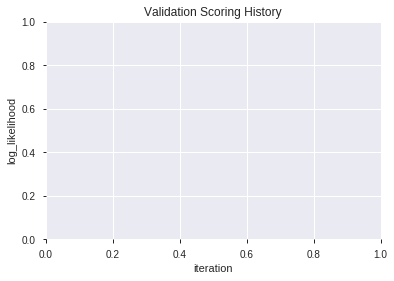

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_132239_model_4  0.816410  0.529942              0.282869  0.421105  0.177329
1  XGBoost_grid_1_AutoML_20190725_132239_model_7  0.812256  0.525084              0.261241  0.420845  0.177110
2               XGBoost_3_AutoML_20190725_132239  0.811767  0.525732              0.287634  0.421088  0.177315
3  XGBoost_grid_1_AutoML_20190725_132239_model_2  0.811339  0.530076              0.304497  0.422510  0.178515
4  XGBoost_grid_1_AutoML_20190725_132239_model_3  0.811339  0.531069              0.278104  0.422290  0.178329
5  XGBoost_grid_1_AutoML_20190725_132239_model_1  0.808223  0.532360              0.313050  0.423525  0.179374
6  XGBoost_grid_1_AutoML_20190725_132239_model_6  0.807918  0.532172              0.278592  0.423487  0.179341
7               XGBoost_2_AutoML_20190725_132239  0.805474  0.531585              0.303275  0.424752  0.180414
8               XGBoost_1_AutoML_20190725_132239  0.797226  0.541774              0.271139  0.428852  0.183914
9  XGBoost_grid_1_AutoML_20190725_132239_model_5  0.794049  0.548309              0.337488  0.431861  0.186504

variable  relative_importance  scaled_importance  percentage
0     CDLDRAGONFLYDOJI           901.801880           1.000000    0.135267
1    CDLGRAVESTONEDOJI           693.878052           0.769435    0.104079
2         STOCHF_fastk           551.906555           0.612004    0.082784
3                CCI_8           421.043121           0.466891    0.063155
4              WILLR_8           348.803223           0.386785    0.052319
..                 ...                  ...                ...         ...
146              DX_14             4.568675           0.005066    0.000685
147              DX_24             4.504461           0.004995    0.000676
148        MINUS_DI_24             4.386720           0.004864    0.000658
149            NATR_14             4.371274           0.004847    0.000656
150              DX_30             4.304355           0.004773    0.000646

[151 rows x 4 columns]

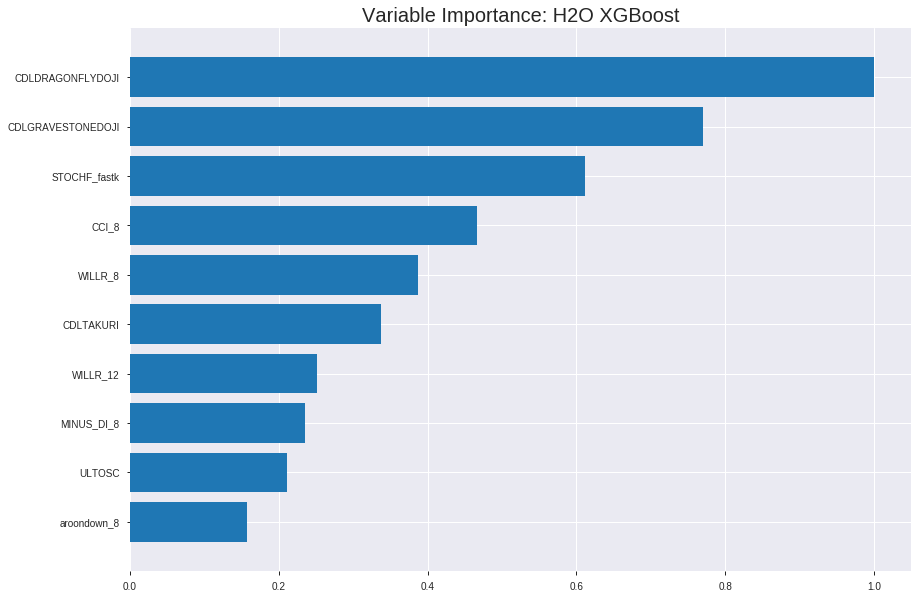

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_132239_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15433556755869107
RMSE: 0.39285565740955175
LogLoss: 0.48010112953186274
Mean Per-Class Error: 0.19222932330827058
AUC: 0.8827926065162908
pr_auc: 0.8777855252175238
Gini: 0.7655852130325815
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4346577078104019: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      581  294   0.336    (294.0/875.0)
1      71   841   0.0779   (71.0/912.0)
Total  652  1135  0.2043   (365.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434658     0.82169   239
max f2                       0.355722     0.88742   279
max f0point5                 0.59253      0.816104  157
max accuracy                 0.493725     0.808618  208
max precision                0.929452     1         0
max recall                   0.119098     1         377
max specificity              0.929452     1         0
max absolute_mcc             0.493725     0.61818   208
max min_per_class_accuracy   0.518767     0.797714  194
max mean_per_class_accuracy  0.493725     0.807771  208

Gains/Lift Table: Avg response rate: 51.04 %, avg score: 51.04 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.90274            1.95943    1.95943            1                0.91158   1                           0.91158             0.0197368       0.0197368                  95.943    95.943
    2        0.0201455                   0.892774           1.95943    1.95943            1                0.897012  1                           0.904296            0.0197368       0.0394737                  95.943    95.943
    3        0.0302182                   0.882646           1.95943    1.95943            1                0.887498  1                           0.898697            0.0197368       0.0592105                  95.943    95.943
    4        0.040291                    0.873407           1.74172    1.905              0.888889         0.878138  0.972222                    0.893557            0.0175439       0.0767544                  74.1715   90.5001
    5        0.0503637                   0.861547           1.85057    1.89412            0.944444         0.867251  0.966667                    0.888296            0.0186404       0.0953947                  85.0573   89.4115
    6        0.100168                    0.812588           1.84935    1.87186            0.94382          0.838499  0.955307                    0.863536            0.0921053       0.1875                     84.9349   87.1858
    7        0.149972                    0.767161           1.80532    1.84976            0.921348         0.791938  0.94403                     0.839759            0.0899123       0.277412                   80.5317   84.976
    8        0.200336                    0.715165           1.74172    1.8226             0.888889         0.738007  0.930168                    0.814179            0.0877193       0.365132                   74.1715   82.2598
    9        0.299944                    0.649247           1.66221    1.76934            0.848315         0.678549  0.902985                    0.769138            0.16557         0.530702                   66.2213   76.9336
    10       0.400112                    0.583109           1.39021    1.67442            0.709497         0.615978  0.854545                    0.730794            0.139254        0.669956                   39.021    67.4422
    11       0.50028                     0.522691           1.21507    1.58245            0.620112         0.55375   0.807606                    0.695346            0.121711        0.791667                   21.5065   58.2448
    12       0.599888                    0.455481           0.979715   1.48237            0.5              0.489551  0.75653                     0.661175            0.0975877       0.889254                   -2.02851  48.2367
    13       0.700056                    0.396766           0.602059   1.35641            0.307263         0.425407  0.692246                    0.62744             0.060307        0.949561                   -39.7941  35.6408
    14       0.799664                    0.315404           0.286209   1.2231             0.146067         0.3543    0.624213                    0.593417            0.0285088       0.97807                    -71.3791  22.3101
    15       0.899832                    0.164685           0.131358   1.10157            0.0670391        0.238197  0.562189                    0.553874            0.0131579       0.991228                   -86.8642  10.157
    16       1                           0.0578494          0.0875723  1                  0.0446927        0.119829  0.510353                    0.51



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.175606214765606
RMSE: 0.41905395209400664
LogLoss: 0.5263654805995798
Mean Per-Class Error: 0.25246675246675254
AUC: 0.820823374394803
pr_auc: 0.819763443629653
Gini: 0.641646748789606
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37124836444854736: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      132  127  0.4903   (127.0/259.0)
1      21   231  0.0833   (21.0/252.0)
Total  153  358  0.2896   (148.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371248     0.757377  283
max f2                       0.283021     0.849257  318
max f0point5                 0.603885     0.761719  156
max accuracy                 0.515043     0.747554  204
max precision                0.913944     1         0
max recall                   0.124375     1         375
max specificity              0.913944     1         0
max absolute_mcc             0.515043     0.495044  204
max min_per_class_accuracy   0.515043     0.746032  204
max mean_per_class_accuracy  0.515043     0.747533  204

Gains/Lift Table: Avg response rate: 49.32 %, avg score: 50.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.898487           2.02778   2.02778            1                0.907324  1                           0.907324            0.0238095       0.0238095                  102.778   102.778
    2        0.0215264                   0.891266           2.02778   2.02778            1                0.893226  1                           0.900916            0.0198413       0.0436508                  102.778   102.778
    3        0.0313112                   0.885104           2.02778   2.02778            1                0.888149  1                           0.896926            0.0198413       0.0634921                  102.778   102.778
    4        0.0410959                   0.873658           2.02778   2.02778            1                0.879266  1                           0.892721            0.0198413       0.0833333                  102.778   102.778
    5        0.0508806                   0.864299           2.02778   2.02778            1                0.868761  1                           0.888113            0.0198413       0.103175                   102.778   102.778
    6        0.101761                    0.830251           1.7938    1.91079            0.884615         0.849139  0.942308                    0.868626            0.0912698       0.194444                   79.3803   91.0791
    7        0.150685                    0.792901           1.86556   1.8961             0.92             0.80791   0.935065                    0.848913            0.0912698       0.285714                   86.5556   89.6104
    8        0.201566                    0.756239           1.63782   1.83091            0.807692         0.777681  0.902913                    0.830932            0.0833333       0.369048                   63.7821   83.0906
    9        0.30137                     0.666908           1.43137   1.69859            0.705882         0.707038  0.837662                    0.789902            0.142857        0.511905                   43.1373   69.8593
    10       0.401174                    0.589014           1.31209   1.60244            0.647059         0.623741  0.790244                    0.748565            0.130952        0.642857                   31.2092   60.2439
    11       0.500978                    0.512603           1.03377   1.48915            0.509804         0.542474  0.734375                    0.707507            0.103175        0.746032                   3.37691   48.9149
    12       0.600783                    0.453558           0.795207  1.37387            0.392157         0.482022  0.677524                    0.670049            0.0793651       0.825397                   -20.4793  37.3869
    13       0.700587                    0.371248           0.914488  1.30843            0.45098          0.415728  0.645251                    0.633819            0.0912698       0.916667                   -8.5512   30.8426
    14       0.800391                    0.276449           0.357843  1.18989            0.176471         0.326158  0.586797                    0.595455            0.0357143       0.952381                   -64.2157  18.9894
    15       0.900196                    0.15565            0.318083  1.09324            0.156863         0.207751  0.53913                     0.552471            0.031746        0.984127                   -68.1917  9.32367
    16       1                           0.0611198          0.159041  1                  0.0784314        0.121468  0.493151                    0.509455         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 13:23:16  14.982 sec  0                  0.5              0.693147            0.5             0                  1                0.489647                         0.5                0.693147              0.5               0                    1                  0.506849
    2019-07-25 13:23:16  15.875 sec  5                  0.477432         0.648643            0.791905        0.595728           1.75893          0.299384                         0.475465           0.644824              0.783845          0.494549             1.83915            0.307241
    2019-07-25 13:23:17  16.160 sec  10                 0.46291          0.619948            0.808125        0.608489           1.75893          0.281477                         0.461404           0.616854              0.787898          0.501413             1.83915            0.2818
    2019-07-25 13:23:17  16.420 sec  15                 0.451463         0.596977            0.820661        0.777267           1.75317          0.255736                         0.451549           0.596539              0.791215          0.759778             2.02778            0.307241
    2019-07-25 13:23:17  16.693 sec  20                 0.441476         0.576799            0.829291        0.78091            1.86612          0.251819                         0.442051           0.576914              0.806712          0.731702             1.84343            0.305284
    2019-07-25 13:23:18  16.985 sec  25                 0.435236         0.563758            0.831469        0.82011            1.87424          0.253497                         0.436743           0.565402              0.808352          0.793231             2.02778            0.313112
    2019-07-25 13:23:18  17.279 sec  30                 0.428631         0.550483            0.841711        0.836232           1.95943          0.239508                         0.43292            0.556934              0.809746          0.805115             2.02778            0.305284
    2019-07-25 13:23:18  17.564 sec  35                 0.423452         0.540192            0.847055        0.839371           1.95943          0.225518                         0.429475           0.549772              0.814503          0.812154             2.02778            0.303327
    2019-07-25 13:23:18  17.844 sec  40                 0.418669         0.530667            0.851855        0.843659           1.95943          0.234471                         0.427074           0.544596              0.815216          0.814775             2.02778            0.258317
    2019-07-25 13:23:19  18.157 sec  45                 0.414272         0.521661            0.854366        0.846472           1.95943          0.225518                         0.425297           0.540281              0.816365          0.815083             2.02778            0.30137
    2019-07-25 13:23:19  18.448 sec  50                 0.410377         0.513751            0.857233        0.848246           1.95943          0.233912                         0.424766           0.538561              0.81556           0.814954             2.02778            0.305284
    2019-07-25 13:23:19  18.751 sec  55                 0.406799         0.506795            0.862674        0.855684           1.95943          0.217124                         0.423819           0.536464              0.814672          0.81

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
CDLDRAGONFLYDOJI   901.8018798828125      1.0                   0.13526702805287935
CDLGRAVESTONEDOJI  693.8780517578125      0.7694351356286602    0.10407920407595299
STOCHF_fastk       551.9065551757812      0.6120042189837755    0.08278399185775888
CCI_8              421.0431213378906      0.4668909332863715    0.06315494897048264
WILLR_8            348.80322265625        0.3867847588669657    0.05231922482808402
---                ---                    ---                   ---
DX_14              4.568674564361572      0.005066162165192274  0.0006852846997194993
DX_24              4.50446081161499       0.004994956111868315  0.0006756528685069925
MINUS_DI_24        4.386719703674316      0.004864394055426412  0.0006579921271556241
NATR_14            4.371273517608643      0.00484726591851492   0.0006556752549795237
DX_30              4.304354667663574      0.004773060207218594  0.0006456376689479196


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7421875)

('F1', 0.7687296416938111)

('auc', 0.8164100684261975)

('logloss', 0.5299424254697787)

('mean_per_class_error', 0.25757575757575757)

('rmse', 0.42110475042572937)

('mse', 0.1773292108311158)

xgboost prediction progress: |████████████████████████████████████████████| 100%


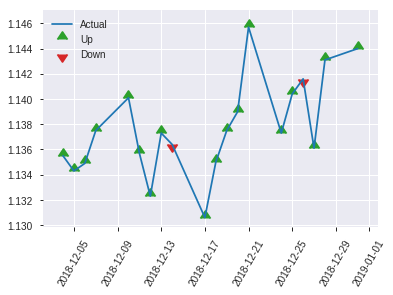


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1773292108311158
RMSE: 0.42110475042572937
LogLoss: 0.5299424254697787
Mean Per-Class Error: 0.25757575757575757
AUC: 0.8164100684261975
pr_auc: 0.8283231136749564
Gini: 0.6328201368523949
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3586290180683136: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   57   0.4597   (57.0/124.0)
1      14   118  0.1061   (14.0/132.0)
Total  81   175  0.2773   (71.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358629     0.76873   174
max f2                       0.222006     0.868102  214
max f0point5                 0.636764     0.757576  65
max accuracy                 0.479813     0.742188  127
max precision                0.909628     1         0
max recall                   0.0924798    1         252
max specificity              0.909628     1         0
max absolute_mcc             0.448607     0.485035  145
max min_per_class_accuracy   0.474907     0.741935  129
max mean_per_class_accuracy  0.479813     0.742424  127

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 48.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.893764           1.93939   1.93939            1                0.904616  1                           0.904616            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.884588           1.93939   1.93939            1                0.887529  1                           0.896073            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.877246           1.93939   1.93939            1                0.882202  1                           0.892605            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.855017           1.93939   1.93939            1                0.865938  1                           0.885332            0.0227273       0.0833333                  93.9394   93.9394
    5        0.0507812                   0.848815           1.93939   1.93939            1                0.852565  1                           0.880291            0.0151515       0.0984848                  93.9394   93.9394
    6        0.101562                    0.797386           1.93939   1.93939            1                0.822756  1                           0.851523            0.0984848       0.19697                    93.9394   93.9394
    7        0.152344                    0.757845           1.79021   1.88967            0.923077         0.77591   0.974359                    0.826319            0.0909091       0.287879                   79.021    88.9666
    8        0.203125                    0.690685           1.64103   1.82751            0.846154         0.719267  0.942308                    0.799556            0.0833333       0.371212                   64.1026   82.7506
    9        0.300781                    0.60247            1.16364   1.61196            0.6              0.642279  0.831169                    0.748492            0.113636        0.484848                   16.3636   61.1964
    10       0.402344                    0.545064           1.19347   1.50633            0.615385         0.572886  0.776699                    0.704164            0.121212        0.606061                   19.3473   50.6325
    11       0.5                         0.479464           1.31879   1.4697             0.68             0.514624  0.757812                    0.667145            0.128788        0.734848                   31.8788   46.9697
    12       0.601562                    0.423675           0.820513  1.36009            0.423077         0.453216  0.701299                    0.631027            0.0833333       0.818182                   -17.9487  36.0094
    13       0.699219                    0.35111            0.775758  1.27848            0.4              0.382161  0.659218                    0.596269            0.0757576       0.893939                   -22.4242  27.8483
    14       0.800781                    0.283475           0.596737  1.19202            0.307692         0.316697  0.614634                    0.560811            0.0606061       0.954545                   -40.3263  19.2018
    15       0.898438                    0.161742           0.310303  1.09618            0.16             0.209261  0.565217                    0.522599            0.030303        0.984848                   -68.9697  9.61792
    16       1                           0.0683368          0.149184  1                  0.0769231        0.119748  0.515625                    0.481685         

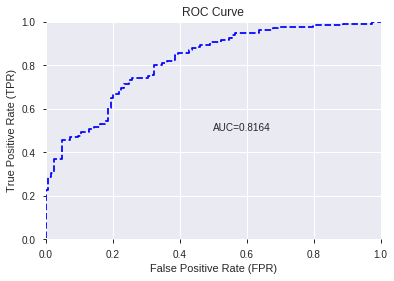

This function is available for GLM models only


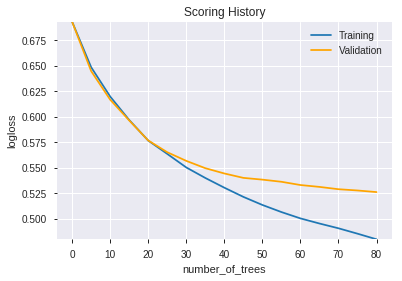

--2019-07-25 13:23:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_132239_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_132239_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a38f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'CCI_8',
 'WILLR_8',
 'CDLTAKURI',
 'WILLR_12',
 'MINUS_DI_8',
 'ULTOSC',
 'aroondown_8',
 'aroonup_12',
 'LINEARREG_ANGLE_8',
 'WILLR_14',
 'CORREL_20',
 'PLUS_DI_8',
 'CCI_20',
 'HT_DCPERIOD',
 'CCI_14',
 'STOCH_slowk',
 'PLUS_DM_8',
 'CMO_8',
 'aroondown_14',
 'LINEARREG_INTERCEPT_30',
 'CCI_24',
 'BETA_8',
 'BETA_14',
 'BBANDS_upperband_30_2_5',
 'MINUS_DM_8',
 'CCI_12',
 'MACDFIX_hist_20',
 'ADX_8',
 'MINUS_DI_12',
 'DIV',
 'STDDEV_8',
 'STDDEV_12',
 'aroonup_8',
 'AROONOSC_20',
 'TRANGE',
 'NATR_30',
 'BBANDS_upperband_24_6_5',
 'ADX_12',
 'BBANDS_lowerband_24_7_2',
 'STDDEV_24',
 'STOCH_slowd',
 'BETA_12',
 'MAVP_12_4',
 'ADX_24',
 'HT_PHASOR_inphase',
 'MACDFIX_hist_8',
 'CORREL_30',
 'PLUS_DI_14',
 'MACD_hist',
 'AROONOSC_8',
 'WILLR_30',
 'CDLRICKSHAWMAN',
 'MINUS_DI_20',
 'TRIX_14',
 'BBANDS_upperband_14_0_2',
 'aroonup_20',
 'LINEARREG_INTERCEPT_12',
 'MOM_8',
 'MINUS_DI_30',
 'DX_8',
 'aroondown_30',
 'STDDEV_14'

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.746
GLM             0.738
XGBoost         0.754
dtype: float64

DeepLearning    GLM  XGBoost
All          0.719  0.738    0.754
DLF          0.742  0.738    0.738
Fwe          0.711  0.711    0.703
RFE          0.746  0.730    0.742
XGBF         0.746  0.738    0.738





F1


DeepLearning    0.790
GLM             0.777
XGBoost         0.775
dtype: float64

DeepLearning    GLM  XGBoost
All          0.770  0.777    0.775
DLF          0.779  0.773    0.775
Fwe          0.741  0.744    0.755
RFE          0.779  0.777    0.769
XGBF         0.790  0.773    0.775





auc


DeepLearning    0.826
GLM             0.817
XGBoost         0.827
dtype: float64

DeepLearning    GLM  XGBoost
All          0.790  0.801    0.827
DLF          0.809  0.817    0.822
Fwe          0.785  0.786    0.789
RFE          0.808  0.811    0.816
XGBF         0.826  0.817    0.822





logloss


DeepLearning    0.549
GLM             0.541
XGBoost         0.543
dtype: float64

DeepLearning    GLM  XGBoost
All          0.549  0.533    0.511
DLF          0.506  0.512    0.511
Fwe          0.530  0.541    0.543
RFE          0.536  0.526    0.530
XGBF         0.504  0.512    0.511





mean_per_class_error


DeepLearning    0.289
GLM             0.286
XGBoost         0.297
dtype: float64

DeepLearning    GLM  XGBoost
All          0.287  0.266    0.247
DLF          0.258  0.260    0.262
Fwe          0.289  0.286    0.297
RFE          0.257  0.272    0.258
XGBF         0.254  0.260    0.262





rmse


DeepLearning    0.434
GLM             0.431
XGBoost         0.431
dtype: float64

DeepLearning    GLM  XGBoost
All          0.434  0.426    0.413
DLF          0.418  0.417    0.414
Fwe          0.427  0.431    0.431
RFE          0.427  0.421    0.421
XGBF         0.411  0.417    0.414





mse


DeepLearning    0.189
GLM             0.186
XGBoost         0.185
dtype: float64

DeepLearning    GLM  XGBoost
All          0.189  0.181    0.171
DLF          0.175  0.174    0.172
Fwe          0.182  0.186    0.185
RFE          0.182  0.178    0.177
XGBF         0.169  0.174    0.172

{'F1':       DeepLearning    GLM  XGBoost
 All          0.770    NaN      NaN
 DLF          0.779    NaN      NaN
 DLF            NaN  0.773      NaN
 DLF            NaN    NaN    0.775
 All            NaN  0.777      NaN
 All            NaN    NaN    0.775
 XGBF         0.790    NaN      NaN
 XGBF           NaN  0.773      NaN
 XGBF           NaN    NaN    0.775
 Fwe          0.741    NaN      NaN
 Fwe            NaN  0.744      NaN
 Fwe            NaN    NaN    0.755
 RFE          0.779    NaN      NaN
 RFE            NaN  0.777      NaN
 RFE            NaN    NaN    0.769,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.719    NaN      NaN
 DLF          0.742    NaN      NaN
 DLF            NaN  0.738      NaN
 DLF            NaN    NaN    0.738
 All            NaN  0.738      NaN
 All            NaN    NaN    0.754
 XGBF         0.746    NaN      NaN
 XGBF           NaN  0.738      NaN
 XGBF           NaN    NaN    0.738
 Fwe          0.711    NaN      NaN
 Fwe     